# CS 8803 Internet Data Science Final Project
- Georgia Tech Spring 2022
- Instructors: [Dr. Alberto Dainotti](https://faculty.cc.gatech.edu/~adainotti6/), [Dr. Zachary Bischof](https://www.zbischof.com/)
- Student: Reagan Kan

This is the notebook for the final project for [CS 8803-IDS course](https://faculty.cc.gatech.edu/~adainotti6/cs8803-ids/index.html). The research goals and methodology are explained in the project [proposal slides](https://docs.google.com/presentation/d/1n17QRd0yAoLL48AYaxtxZHHl1jy3oyV3WrPFbc_PAc0/edit?usp=sharing). The project demo/[presentation slides](https://docs.google.com/presentation/d/1YWCJEtS-wCa6kVuHjF5kVQ2PyyjCLi056oELPD3XLrM/edit?usp=sharing) show preliminary results and contain some adjustments to the data encoding methodology.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display

import os
import re
import json
import pickle
from collections import defaultdict, Counter

# IP address
import netaddr
import ipaddress

# Visualization
import matplotlib
import matplotlib.pyplot as plt

# Data Preprocessing
import pandas as pd
import numpy as np
from sklearn import preprocessing

# Clustering
from sklearn.cluster import KMeans

# Autoencoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from pytorch_model_summary import summary #https://pypi.org/project/pytorch-model-summary/

# Featuree Attribution
import captum
from captum.attr import NeuronGradient

# hilbert feature maps
from hilbert import decode, encode

**NOTE**: Due to a failure to save the original autoencoder (AE) model weights, the weights for the AE shown in the presentation slides was lost. Only, **similar** weights were saved (the AE was trained for more epochs with different hyperparameters).

Attempts to replicate the original AE training were unsuccessful, likely due to different pseudo-random initializations of the AE weights and using different data encoding schemes.

For these reasons, the **feature importance heatmaps** will have slightly different values than those shown in the project presentation. However, since the weights were not changed too much, **the overall trends/findings remain the same**. Those trends will be covered in this notebook's text cells.

By setting the `DEMO` variable to `True`, the notebook will load in the **similar** AE weights. Otherwise, a new AE will be trained from scratch and the embedding cluster heatmap might show different trends than those explained in this notebook and in the presentation slides.

In [3]:
DEMO = True

# Choosing ASes

The project chooses to focus on IPs from cloud service providers. We choose ASes from [Amazon Web Services](https://aws.amazon.com/) using [CAIDA's](https://www.caida.org/) ASRank [tool](https://asrank.caida.org/asns/by-name?name=Amazon&type=by_name) .

- ASN 19047 (AWS-01)
    - 30 prefixes and 7680 IPs
    - a small AS for a quick study and iterative development
- ASN 16509 
    - 6998 prefixes	and 58942592 IPs
    - a larger AS in hopes of finding more complex patterns

# Retrieving Data

The project leverages internet probe data from [Censys](https://search.censys.io/data/universal-internet-dataset/definitions). Thanks to Dr. Dainotti, permission to the data was granted by Censys reserchers and accessed via Google [BigQuery](https://cloud.google.com/bigquery) using [SQL](https://en.wikipedia.org/wiki/SQL) commands shown here.

### Available Dates
```mysql
SELECT
    distinct DATE(dataset.snapshot_date)
FROM `censys-io.research_1m.universal_internet_dataset` as dataset
WHERE DATE(dataset.snapshot_date) > DATE_SUB(CURRENT_DATE(), INTERVAL 2 MONTH)
    AND dataset.autonomous_system.asn = 19047 -- or 16509
```
**Query Results**  
ASN [19047](https://drive.google.com/file/d/1frwRopzQCW25zZd-Q9wXWlwn3AihGP1B/view?usp=sharing)  
ASN [16509](https://drive.google.com/file/d/1XNmNUnXudXsh3CdHZQYh_oT6Tt6E8o4K/view?usp=sharing)  

### Services Features
```mysql
SELECT
    dataset.autonomous_system.asn,
    dataset.autonomous_system.bgp_prefix,
    dataset.host_identifier.ipv4,
    dataset.services 
FROM `censys-io.research_1m.universal_internet_dataset` as dataset
WHERE DATE(dataset.snapshot_date) = '2022-02-22'
AND dataset.autonomous_system.asn = 19047 -- or 16509
```
**Query Results**  
ASN [19047](https://drive.google.com/file/d/1H-Z-SVWuixrK6SMny03S_eMaOQwRKCNe/view?usp=sharing)  
ASN [16509](https://drive.google.com/drive/folders/1dKL_Axh_4__bBPlDoNeJNQGzHQN79T9F?usp=sharing)

### Operating System Features
```mysql
SELECT
    dataset.autonomous_system.asn,
    dataset.autonomous_system.bgp_prefix,
    dataset.host_identifier.ipv4,
    dataset.operating_system 
FROM `censys-io.research_1m.universal_internet_dataset` as dataset
WHERE DATE(dataset.snapshot_date) = '2022-02-22'
AND dataset.autonomous_system.asn = 19047 -- or 16509
```
**Query Results**  
ASN [19047](https://drive.google.com/file/d/1ZcyNBolNA9oooiuAcn3Yrak1I9eLx08R/view?usp=sharing)  
ASN [16509](https://drive.google.com/file/d/183_AvYqsJtGcJBCfor_gnq1rEYQ-lXGe/view?usp=sharing)  


# Load in data

This notebook should load in raw Censys data from JSON files.
Assume each filename has a common format: `ASN{ASN}_{snapshot_date}.json`

In [4]:
DIRECTORY = os.path.join(".", "bigquery_data")
JSON_FILEPATH = os.path.join(DIRECTORY, "ASN19047-20220222-test1.json")
OS_JSON_FILEPATH = os.path.join(DIRECTORY, "ASN19047-20220222-test1-os.json")

In [5]:
def load_json(filepath):
    rows = []
    for line in open(filepath, 'r'):
        rows.append(json.loads(line))
    return rows

In [6]:
service_data = load_json(JSON_FILEPATH)
len(service_data)

1262

In [7]:
os_data = load_json(OS_JSON_FILEPATH)
len(os_data)

1262

In [8]:
sum([d != None for d in os_data])

1262

In [9]:
## TODO: merge service and os features
data = service_data

### Explore data

In [10]:
for d in data:
    # ports_list and service_names_list are summaries of services
    
    ## check lengths
    assert(len(d["services"]) == len(d["ports_list"]))
    assert(len(d["ports_list"]) == len(d["service_names_list"]))
    
    ## check details
    assert(all([s["port"] == p for s, p in zip(d["services"], d["ports_list"])]))
    assert(all([s["service_name"] == sname for s, sname in zip(d["services"], d["service_names_list"])]))

In [11]:
def find_by_ip(ip):
    for d in data:
        if d["host_identifier"]["ipv4"] == ip:
            return d
row = find_by_ip("70.130.217.57")

In [12]:
data[0].keys()

dict_keys(['host_identifier', 'services', 'snapshot_date', 'ipv4_int', 'location', 'autonomous_system', 'ports_list', 'service_names_list'])

In [13]:
for s in row["services"]:
    print(s.keys())

dict_keys(['port', 'transport', 'service_name', 'perspective', 'observed_at', 'banner', 'software', 'source_ip', 'extended_service_name', 'http', 'truncated'])
dict_keys(['port', 'transport', 'service_name', 'perspective', 'observed_at', 'banner', 'software', 'source_ip', 'extended_service_name', 'http', 'truncated'])


In [14]:
print(json.dumps(d, indent=2))

{
  "host_identifier": {
    "ipv4": "70.130.193.37"
  },
  "services": [
    {
      "port": "80",
      "transport": "TCP",
      "service_name": "HTTP",
      "perspective": "HE",
      "observed_at": "2022-02-23 11:03:51.423765 UTC",
      "banner": "SFRUUC8xLjEgNDAzIEZvcmJpZGRlbgpYLUFtei1DZi1Qb3A6IE1TUDIwMC1CQzIKVmlhOiAxLjEgYTQ4OTI1ZWNhZWViNTU1NmY3MDRhMjAwMzc5MGVjN2MuY2xvdWRmcm9udC5uZXQgKENsb3VkRnJvbnQpCkNvbnRlbnQtVHlwZTogdGV4dC9odG1sCkRhdGU6IDxSRURBQ1RFRD4KWC1BbXotQ2YtSWQ6IGtQcU52WlV3ZjVkdzJVWkZfRnRId0NvNWtWeWdzVjltdnZ1YW84c2EtbEdvMFN0TWJQb0p1dz09ClgtQ2FjaGU6IEVycm9yIGZyb20gY2xvdWRmcm9udApTZXJ2ZXI6IENsb3VkRnJvbnQKQ29ubmVjdGlvbjoga2VlcC1hbGl2ZQpDb250ZW50LUxlbmd0aDogOTE1",
      "software": [
        {
          "uniform_resource_identifier": "cpe:2.3:a:amazon:amazon_cloudfront:*:*:*:*:*:*:*:*",
          "part": "a",
          "vendor": "Amazon",
          "product": "CloudFront Load Balancer",
          "component_uniform_resource_identifiers": [],
          "other": [
          

# Group IPs by IP prefix

The goal of the project is to seek IP patterns within IP prefixes, not entire ASes, under the assumption that IP patterns are unique for each IP prefixes. Thus, we group the IPs by IP prefix and try to characterize prefixes with some simple counts/statistics.

In [15]:
class IPServiceAndPorts:
    def __init__(self, json_dict):
        self.ip = json_dict["host_identifier"]["ipv4"]
        self.prefix = json_dict["autonomous_system"]["bgp_prefix"]
        self.ports_list = json_dict['ports_list']
        self.service_names_list = json_dict['service_names_list']
        self.port_and_services = f"{self.ports_list}, {self.service_names_list}"
    
    def __hash__(self):
        return hash(self.ip)
    def __str__(self):
        return f"{self.ip}, {self.prefix}, {self.port_and_services}"

In [16]:
prefix_to_ip = defaultdict(set)
for d in data:
    ip_tuple = IPServiceAndPorts(d)
    prefix_to_ip[ip_tuple.prefix].add(ip_tuple)

In [17]:
print("IP prefix,\t\tnum IPs, \tnum IPs with >1 services \tnum IPs with >1 ports")
total = 0
for k, v in prefix_to_ip.items():
    print(k, "\t", len(v), "\t\t", len([_ for ip in v if len(ip.service_names_list) > 1]), "\t\t\t\t", len([_ for ip in v if len(ip.ports_list) > 1]))
    total += len(v)
total == len(data), total, len(data)

IP prefix,		num IPs, 	num IPs with >1 services 	num IPs with >1 ports
70.130.206.0/24 	 43 		 42 				 42
70.130.212.0/24 	 45 		 43 				 43
70.130.224.0/24 	 45 		 43 				 43
70.130.227.0/24 	 44 		 42 				 42
70.130.200.0/24 	 45 		 43 				 43
70.130.208.0/24 	 45 		 43 				 43
70.130.192.0/24 	 45 		 43 				 43
70.130.205.0/24 	 45 		 43 				 43
70.130.209.0/24 	 44 		 42 				 42
70.130.203.0/24 	 43 		 42 				 42
70.130.202.0/24 	 45 		 43 				 43
70.130.226.0/24 	 45 		 43 				 43
70.130.217.0/24 	 41 		 41 				 41
70.130.216.0/24 	 41 		 41 				 41
70.130.211.0/24 	 43 		 43 				 43
70.130.199.0/24 	 42 		 42 				 42
70.130.198.0/24 	 39 		 39 				 39
70.130.218.0/24 	 41 		 41 				 41
70.130.193.0/24 	 42 		 42 				 42
70.130.196.0/24 	 43 		 43 				 43
70.130.197.0/24 	 43 		 43 				 43
70.130.194.0/24 	 43 		 43 				 43
70.130.201.0/24 	 43 		 43 				 43
70.130.210.0/24 	 42 		 42 				 42
70.130.195.0/24 	 43 		 43 				 43
70.130.207.0/24 	 43 		 43 				 43
70.130.213.0/24 	 43

(True, 1262, 1262)

## Find smallest subnet for each prefix

Since Censys gives us few datapoints for every IP prefix in this AS, we try to find the smallest enclosing subnet for each prefix. For example, `70.130.206.0/24` has **256 IP addresses** but we only have data for **43 IPs**. Let's see if we can find a IP subnet with a larger bitmask (e.g. /25 or /26).

This gives us a sense of the distribution of IP data availability for each IP prefix and ensures the Hilbert Feature Maps (in the last section) will be as dense as possible.

In [18]:
netaddr.spanning_cidr(['63.223.64.0', '63.223.127.255'])

IPNetwork('63.223.64.0/18')

In [19]:
raw_prefix_to_ip = defaultdict(set)
for d in data:
    ip = d["host_identifier"]["ipv4"]
    prefix = d["autonomous_system"]["bgp_prefix"]
    raw_prefix_to_ip[prefix].add(ip)

dense_prefix_to_ip = {}
raw_prefix_to_dense_prefix = {}
print("original\t\tsmallest success")
for pfx, ip_set in raw_prefix_to_ip.items():
    ip1, ip2 = pfx, netaddr.spanning_cidr([str(ip) for ip in ip_set])
    ip1 = ipaddress.ip_network(ip1)
    ip2 = ipaddress.ip_network(ip2)
    print(ip1, "-->", ip2, ip1.num_addresses > ip2.num_addresses)
    dense_prefix_to_ip[str(ip2)] = ip_set
    raw_prefix_to_dense_prefix[str(ip1)] = str(ip2)

original		smallest success
70.130.206.0/24 --> 70.130.206.0/26 True
70.130.212.0/24 --> 70.130.212.0/26 True
70.130.224.0/24 --> 70.130.224.0/26 True
70.130.227.0/24 --> 70.130.227.0/26 True
70.130.200.0/24 --> 70.130.200.0/26 True
70.130.208.0/24 --> 70.130.208.0/26 True
70.130.192.0/24 --> 70.130.192.0/26 True
70.130.205.0/24 --> 70.130.205.0/26 True
70.130.209.0/24 --> 70.130.209.0/26 True
70.130.203.0/24 --> 70.130.203.0/26 True
70.130.202.0/24 --> 70.130.202.0/26 True
70.130.226.0/24 --> 70.130.226.0/26 True
70.130.217.0/24 --> 70.130.217.0/26 True
70.130.216.0/24 --> 70.130.216.0/26 True
70.130.211.0/24 --> 70.130.211.0/26 True
70.130.199.0/24 --> 70.130.199.0/26 True
70.130.198.0/24 --> 70.130.198.0/26 True
70.130.218.0/24 --> 70.130.218.0/26 True
70.130.193.0/24 --> 70.130.193.0/26 True
70.130.196.0/24 --> 70.130.196.0/26 True
70.130.197.0/24 --> 70.130.197.0/26 True
70.130.194.0/24 --> 70.130.194.0/26 True
70.130.201.0/24 --> 70.130.201.0/26 True
70.130.210.0/24 --> 70.130.210

In [20]:
dense_prefix_to_ip.keys()

dict_keys(['70.130.206.0/26', '70.130.212.0/26', '70.130.224.0/26', '70.130.227.0/26', '70.130.200.0/26', '70.130.208.0/26', '70.130.192.0/26', '70.130.205.0/26', '70.130.209.0/26', '70.130.203.0/26', '70.130.202.0/26', '70.130.226.0/26', '70.130.217.0/26', '70.130.216.0/26', '70.130.211.0/26', '70.130.199.0/26', '70.130.198.0/26', '70.130.218.0/26', '70.130.193.0/26', '70.130.196.0/26', '70.130.197.0/26', '70.130.194.0/26', '70.130.201.0/26', '70.130.210.0/26', '70.130.195.0/26', '70.130.207.0/26', '70.130.213.0/26', '70.130.204.0/26', '70.130.225.0/27', '70.130.219.0/26'])

### Characterize IPs and IP prefixes

Let's look at the following:
- how many services do IP's have?
- how specific are each of the prefixes? are they mostly /24's?
- what is the data availability for prefixes? do we have data for most of the IPs in a IP prefix range?

In [21]:
def scatter_plot(xs, ys):

    lines = []
    for i in range(len(xs)):
        pair=[(xs[i],0), (xs[i], ys[i])]
        lines.append(pair)
        
    fig, ax = plt.subplots()
    ax.add_collection(matplotlib.collections.LineCollection(lines))
    plt.scatter(xs, ys)
    for i in range(len(xs)):
        ax.annotate(ys[i], (xs[i], ys[i]+0.2))

distribution of IPs with X number of services


Text(0, 0.5, 'number of IPs')

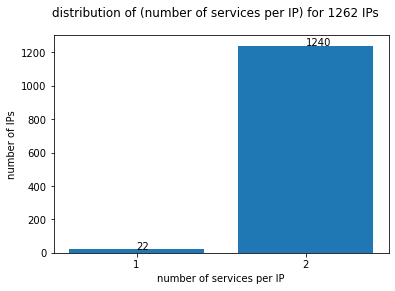

In [22]:
print("distribution of IPs with X number of services")
cnt = list(Counter([len(d["services"]) for d in data]).items())
xs = [x for x, _ in cnt]
ys = [y for _, y in cnt]

plt.suptitle(f"distribution of (number of services per IP) for {len(data)} IPs")
plt.bar(xs, ys)
plt.xticks(xs)
rects = plt.gca().patches
labels = ys
for rect, label in zip(rects, labels):
    height = rect.get_height()
    plt.gca().annotate(
        label,
        (rect.get_x() + rect.get_width() / 2, height)
    )


plt.xlabel("number of services per IP")
plt.ylabel("number of IPs")

Text(0, 0.5, 'number of prefixes')

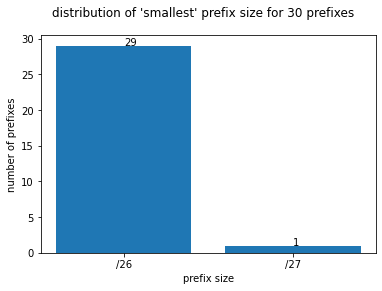

In [23]:
cnt = Counter([pfx[pfx.rfind("/"):] for pfx in dense_prefix_to_ip])

plt.suptitle(f"distribution of \'smallest\' prefix size for {len(dense_prefix_to_ip)} prefixes")
plt.bar(cnt.keys(), cnt.values())

rects = plt.gca().patches
labels = list(cnt.values())
for rect, label in zip(rects, labels):
    height = rect.get_height()
    plt.gca().annotate(
        label,
        (rect.get_x() + rect.get_width() / 2, height)
    )

plt.xlabel("prefix size")
plt.ylabel("number of prefixes")

Counter({0.671875: 11, 0.703125: 8, 0.65625: 4, 0.640625: 3, 0.6875: 2, 0.609375: 1, 0.34375: 1})


Text(0, 0.5, 'number of prefixes')

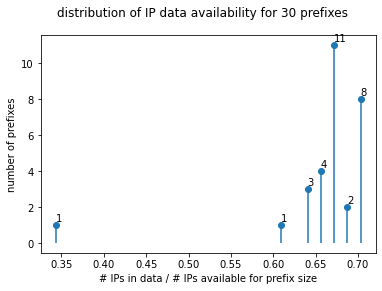

In [24]:
cnt = Counter([len(ips)/ipaddress.ip_network(pfx).num_addresses for pfx, ips in dense_prefix_to_ip.items()])
print(cnt)

xs = list(cnt.keys())
ys = list(cnt.values())
scatter_plot(xs, ys) 
plt.suptitle(f"distribution of IP data availability for {len(dense_prefix_to_ip)} prefixes")
plt.xlabel("# IPs in data / # IPs available for prefix size")
plt.ylabel("number of prefixes")

## Converting JSON --> Pandas

Censys data were downloaded in as a list of JSON objects (one per IP). Censys data have a wide but sparse feature space with a nested structure which makes it hard to parse. Let's convert them into [pandas](https://pandas.pydata.org/) dataframes, since pandas makes it easy to:
- extract data from JSON dictionaries, even recursively nested ones!
- filter/transform data
- remember column names (raw feature names)
- convert to numpy arrays and torch tensors for training autoencoders

In general the data preparation steps will be:
- extract all top level features into a dataframe
    - row = IP address
    - column = top level features
- recursively extract sub-level/nested features into additional columns
- for IPs with more than 1 service, flatten feature matrix so that each feature get a column per service
    - e.g. `service.port` becomes 3 columns `service.port.0`, `service.port.1`, `service.port.2` for IPs with 3 services 
- drop sparse columns
    - e.g. all NaNs or exactly 1 non-NaN row
- data encoding to transform string features into integers for clustering and deep learning

In [25]:
def insert_df_into_df(src_df, dest_df, colname):
    i = list(dest_df).index(colname)
    for c in reversed(src_df.columns):
        dest_df.insert(i, c, src_df[c])
        
    # drop original column
    dest_df = dest_df.drop(columns=colname)
    return dest_df
    

def json_to_pandas(json_list, meta_list, prefix_drop_list, debug=False):
    """
    pd.json_normalize examples: https://github.com/BindiChen/machine-learning/blob/main/data-analysis/028-pandas-json_normalize/pandas-json_normalize.ipynb
    """
    
    # split based on number of services
    num_services_to_list = defaultdict(list)
    for ip in json_list:
        num_services_to_list[len(ip["services"])].append(ip)
        
    # json dict -> pandas dataframe
    num_services_to_df = defaultdict(dict) if debug else dict()
    for n_services, ip_list in num_services_to_list.items():
        
        # flatten services column into a dataframe
        df = pd.json_normalize(
            ip_list, 
            record_path =['services'],
            record_prefix="services.",
            meta=meta_list,
        )
        if debug:
            num_services_to_df[n_services]["services"] = df.copy()
        
        # flatten services.software column into sub-dataframe
        sub_df = pd.json_normalize(
            {'services.software': df['services.software'].tolist()[0]}, 
            record_path =['services.software'],
            record_prefix="services.software."
        )
        df = insert_df_into_df(sub_df, df, "services.software")
        if debug:
            num_services_to_df[n_services]["flat_services"] = df.copy()
        
        ## for tls columns with list of size <= 1, unwrap the list
        for c in df:
            if c.startswith("services.tls"):
                df[c] = df[c].transform(lambda l: l[0] if isinstance(l, list) and l else np.nan)
        if debug:
            num_services_to_df[n_services]["list_unwrap_services"] = df.copy()
        
        # flatten columns with dict
        for c in df:
            for v in df[c]:
                if isinstance(v, dict):
                    # print(c, v)
                    sub_df = pd.json_normalize(
                        df[c],
                        # json_normalize with pd.Series will break with record_prefix
                        # record_prefix=f"{c}." 
                    )
                    sub_df.columns = [f"{c}.{cname}" for cname in sub_df.columns]
                    df = insert_df_into_df(sub_df, df, c)
                    break
        if debug:
            num_services_to_df[n_services]["dict_unwrap_services"] = df.copy()
        
        
        # optionally, drop columns here
        cols_to_drop = []
        for c in df.columns:
            for prefix in prefix_drop_list:
                if c.startswith(prefix):
                    cols_to_drop.append(c)
        df = df.drop(columns=cols_to_drop)
        if debug:
            num_services_to_df[n_services]["drop_services"] = df.copy()
        
        if n_services == 1:
            # move meta columns to front
            cols = df.columns.tolist()
            meta_df = df[cols[-len(meta_list):]]
            services_df = df[cols[:-len(meta_list)]]
            df = pd.concat([meta_df, services_df], axis=1).copy()
            
            # remove columns with only n/a's
            df = df.dropna(axis=1, how="all")
            
            # drop columns with only 1 distinct value
            for col in df.columns:
                if len(df[col].unique()) == 1:
                    df.drop(col,inplace=True,axis=1)
            
            if debug:
                num_services_to_df[n_services]["final_services"] = df
            else:
                num_services_to_df[n_services] = df
            
        elif n_services > 1:
            
            # separate meta cols(ipv4, country, timezone, etc) and services
            cols = df.columns.tolist()
            meta_df = df[cols[-len(meta_list):]].drop_duplicates() # reduce to 1 row per IP
            meta_df = meta_df.sort_values(by="host_identifier.ipv4") # sort to match services_df ordering
            meta_df = meta_df.reset_index().drop(columns="index") # reindex to allow clean concat with services_df
            services_df = df[cols[:-(len(meta_list)-1)]] #keep ipv4 col for groupby
            
            # flatten rows of ips into a single row with many more columns
            groups = []
            for name, group in services_df.groupby("host_identifier.ipv4"):
                group = group.unstack().to_frame().transpose() 
                group.columns = group.columns.get_level_values(0)
                groups.append(group)

            # reset indexes
            services_df = pd.concat(groups, axis=0).reset_index().drop(columns="index")
            if debug:
                num_services_to_df[n_services]["flat_groups_services"] =services_df.copy()
            
            
            # flatten column names
            columns = services_df.columns.get_level_values(0).tolist() #tolist to allow mutable index
            for i, c in enumerate(columns):
                suffix = str(i%n_services)
                columns[i] = f"{c}.{suffix}"
            services_df.columns = columns
            if debug:
                num_services_to_df[n_services]["flat_colname_services"] =services_df.copy()
        
            # remove redundant ipv4 columns
            if debug:
                services_df = services_df[services_df.columns[:-1]]
                num_services_to_df[n_services]["one_ipv4_services"] =services_df.copy()
            else:
                services_df = services_df[services_df.columns[:-2]]
            
            # recombine meta_df & services_df
            df = pd.concat([meta_df, services_df], axis=1).copy()
            
            # remove columns with only n/a's
            df = df.dropna(axis=1, how="all")
            
            # drop columns with only 1 distinct value
            # make sure you look at duplicates across n_services
            pattern = re.compile(r"([0-9a-zA-Z_]+\.+)+\d+$")
            col_to_reduced_col = dict()
            reduced_col_to_unique_values = defaultdict(set)
            for c in df.columns:
                if pattern.fullmatch(c):
                    rc = c[:c.rindex(".")]
                    col_to_reduced_col[c] = rc
                    reduced_col_to_unique_values[rc] = reduced_col_to_unique_values[rc].union(set(df[c].unique().astype(str)))
                else:
                    ## non-duplicate column (i.e. any metacolumns) e.g. host_identifier.ipv4 location.country
                    col_to_reduced_col[c] = c
                    reduced_col_to_unique_values[c] = reduced_col_to_unique_values[c].union(set(df[c].unique().astype(str)))
            # look at unique values across reduced column
            for col in df.columns:
                if len(reduced_col_to_unique_values[col_to_reduced_col[col]]) == 1:
                    df.drop(col,inplace=True,axis=1)
            
            # save into dict
            if debug:
                num_services_to_df[n_services]["final_services"] = df
                num_services_to_df[n_services]["meta_df"] = meta_df.copy()
                num_services_to_df[n_services]["services_df"] = services_df.copy()
            else:
                num_services_to_df[n_services] = df

    
    return num_services_to_df

Before converting to dataframe, we can specify certain columns to drop.
Here, we drop columns that are not describing the IP, e.g. `http` and `observed_at` describe the Censys probe and not the IP itself.

In [26]:
## group data by prefix
prefix_to_data = defaultdict(list)
for d in data:
    prefix = d["autonomous_system"]["bgp_prefix"]
    prefix_to_data[prefix].append(d)

## specify meta columns (not service or operating_system)
meta_list = [
    ["host_identifier", "ipv4"],
    ["location", "country"],
    ["location", "timezone"]
]

## specify columns to drop
prefix_drop_list = [
    "services.http",
    "services.observed_at",
    "services.software.other",
    "services.software.component_uniform_resource_identifiers",
    "services.banner"
]

## convert JSON -> pandas DataFrame
prefix_to_dfdict = dict() #for debugging
prefix_to_df = dict()
for prefix, data_list in prefix_to_data.items():
#     prefix_to_dfdict[prefix] = json_to_pandas(data_list, meta_list=meta_list, prefix_drop_list=prefix_drop_list, debug=True)
    prefix_to_df[prefix] = json_to_pandas(data_list, meta_list=meta_list, prefix_drop_list=prefix_drop_list)

In [27]:
def debug_df_nrows(n_services):
    
    if n_services == 1:
        prefix = "70.130.206.0/24"
        df_dict = prefix_to_dfdict[prefix][n_services]["final_services"]
        return df_dict
    
    elif n_services == 2:
        prefix = "70.130.219.0/24"
        print(prefix)
        df_dict = prefix_to_dfdict[prefix][n_services]

        keys = list(df_dict.keys())

        print(keys) # return keys
        print()

        transitions = [
            "flatten services.software column", #services -> flat_services
            "unwrap isinstance(value, list)", #flat_services -> list_unwrap_services
            "unwrap isinstance(value, dict)", #'list_unwrap_services', 'dict_unwrap_services'
            "drop columns", #'dict_unwrap_services', 'drop_services'
            "IP rows --> single row + double columns", #'drop_services', 'flat_groups_services'
            "hier col name --> flat colnames e.g. attr.0, attr.1", #'flat_groups_services', 'flat_colname_services'
            "drop extra ipv4 columns", # 'flat_colname_services', 'one_ipv4_services',,
            "add meta cols to service cols", #'one_ipv4_services', 'final_services'
            "debug meta_df",
            "debug services_df"
        ]

        for i in range(len(keys)):
            if i == 0: continue
            prev = keys[i-1]
            curr = keys[i]
#             print(transitions[i-1])
#             print(df_dict[prev].shape, "->", df_dict[curr].shape)
#             print(" old cols", set(df_dict[prev].columns) - set(df_dict[curr].columns))
#             print(" new cols", set(df_dict[curr].columns) - set(df_dict[prev].columns))
#             print()
            
            # for slides
            if i == 5:
                display(df_dict[prev][["host_identifier.ipv4", "services.port", "services.perspective"]].sort_values(by="host_identifier.ipv4"))
#             if i == len(keys) - 3:
#                 display(df_dict[curr][["host_identifier.ipv4"] + list(df_dict[curr].columns)[:3]])
#                 break

        return df_dict["services"], df_dict["meta_df"], df_dict["services_df"], df_dict["final_services"]

# df0, mdf, sdf, fdf = debug_df_nrows(2)

# cols = ["host_identifier.ipv4"]
# cols0 = ["services.port", "services.perspective"]
# cols1 = ["services.port", "services.perspective"]
# for i in range(len(cols0)):
#     cols0[i] = cols0[i] + ".0"
#     cols1[i] = cols1[i] + ".1"
# for c in zip(cols0, cols1):
#     cols.extend(c)
# display(fdf.head()[cols])
# display(fdf.tail()[cols])
# print(fdf[cols].shape)

# fdf_sub = fdf[cols]
# encoder.encode_dataframe(fdf_sub)
# display(fdf_sub.head()[cols])
# display(fdf_sub.tail()[cols])
# print(fdf_sub[cols].shape)
# print(cols)
# df.columns
# fdf = debug_df_nrows(1)
# fdf

Here, we do some quick sanity checks on the dataframe:
- num rows = num IPs
- no NaN columns

In [28]:
## verify df shapes

# AS prefix --> n_services --> num IP addr
prefix2ns2numips = defaultdict(lambda: defaultdict(int))
for d in data:
    prefix = d["autonomous_system"]["bgp_prefix"]
    ns = len(d["services"])
    prefix2ns2numips[prefix][ns] += 1

for prefix, dfdict in prefix_to_df.items():
    for n_services in dfdict:
        expect = prefix2ns2numips[prefix][n_services]
        actual = dfdict[n_services].shape[0]
        err = f"ns={n_services}; {expect} != {actual}"
        assert(expect == actual), err
        
        # for debugging
#         if "final_services" in dfdict[n_services]:
#             expect = prefix2ns2numips[prefix][n_services]
#             actual = dfdict[n_services]["final_services"].shape[0]
#             err = f"ns={n_services}; {expect} != {actual}"
#             assert(expect == actual), err
#         else:
#             print(dfdict.keys(), dfdict[n_services].keys())


# for k in dd:
#     print("nan's", k, dd[k].shape)
#     nas_per_col = dd[k].isna().sum() #nrows per col that have Nans
#     print(" distri of na's_per_col\n", Counter(nas_per_col[nas_per_col != 0]))

MAX_NUM_SERVICES = 0
prefix2ns2nancounters = defaultdict(dict)
for prefix, dd in prefix_to_df.items():
    print("prefix", prefix)
    for k in dd:
        MAX_NUM_SERVICES = max(MAX_NUM_SERVICES, k)
        print("  num_services", k, "df.shape", dd[k].shape)
        nas_per_col = dd[k].isna().sum() #nrows per col that have Nans
        cnt = Counter(nas_per_col[nas_per_col != 0])
        print("    distri of nan's_per_col")
        for KEY, VALUE in cnt.items():
            print(f"      {VALUE} columns have {KEY} rows with NaNs")
        assert(dd[k].shape[0] not in cnt) #cannot have any N/A columns
        prefix2ns2nancounters[prefix][k] = cnt
    print()

print("df shapes OK!")

prefix 70.130.206.0/24
  num_services 1 df.shape (1, 0)
    distri of nan's_per_col
  num_services 2 df.shape (42, 39)
    distri of nan's_per_col
      6 columns have 41 rows with NaNs
      9 columns have 33 rows with NaNs
      7 columns have 40 rows with NaNs
      8 columns have 34 rows with NaNs

prefix 70.130.212.0/24
  num_services 1 df.shape (2, 1)
    distri of nan's_per_col
  num_services 2 df.shape (43, 38)
    distri of nan's_per_col
      5 columns have 42 rows with NaNs
      9 columns have 34 rows with NaNs
      7 columns have 41 rows with NaNs
      1 columns have 35 rows with NaNs
      7 columns have 37 rows with NaNs

prefix 70.130.224.0/24
  num_services 1 df.shape (2, 3)
    distri of nan's_per_col
  num_services 2 df.shape (43, 38)
    distri of nan's_per_col
      5 columns have 42 rows with NaNs
      9 columns have 34 rows with NaNs
      7 columns have 41 rows with NaNs
      8 columns have 35 rows with NaNs

prefix 70.130.227.0/24
  num_services 1 df.shape 

An assumption is that IP patterns will be unique to IP prefixes, i.e. two IP prefixes might not have the same IP usage patterns. So, the rest of the notebook operates on a **single** IP prefix.  

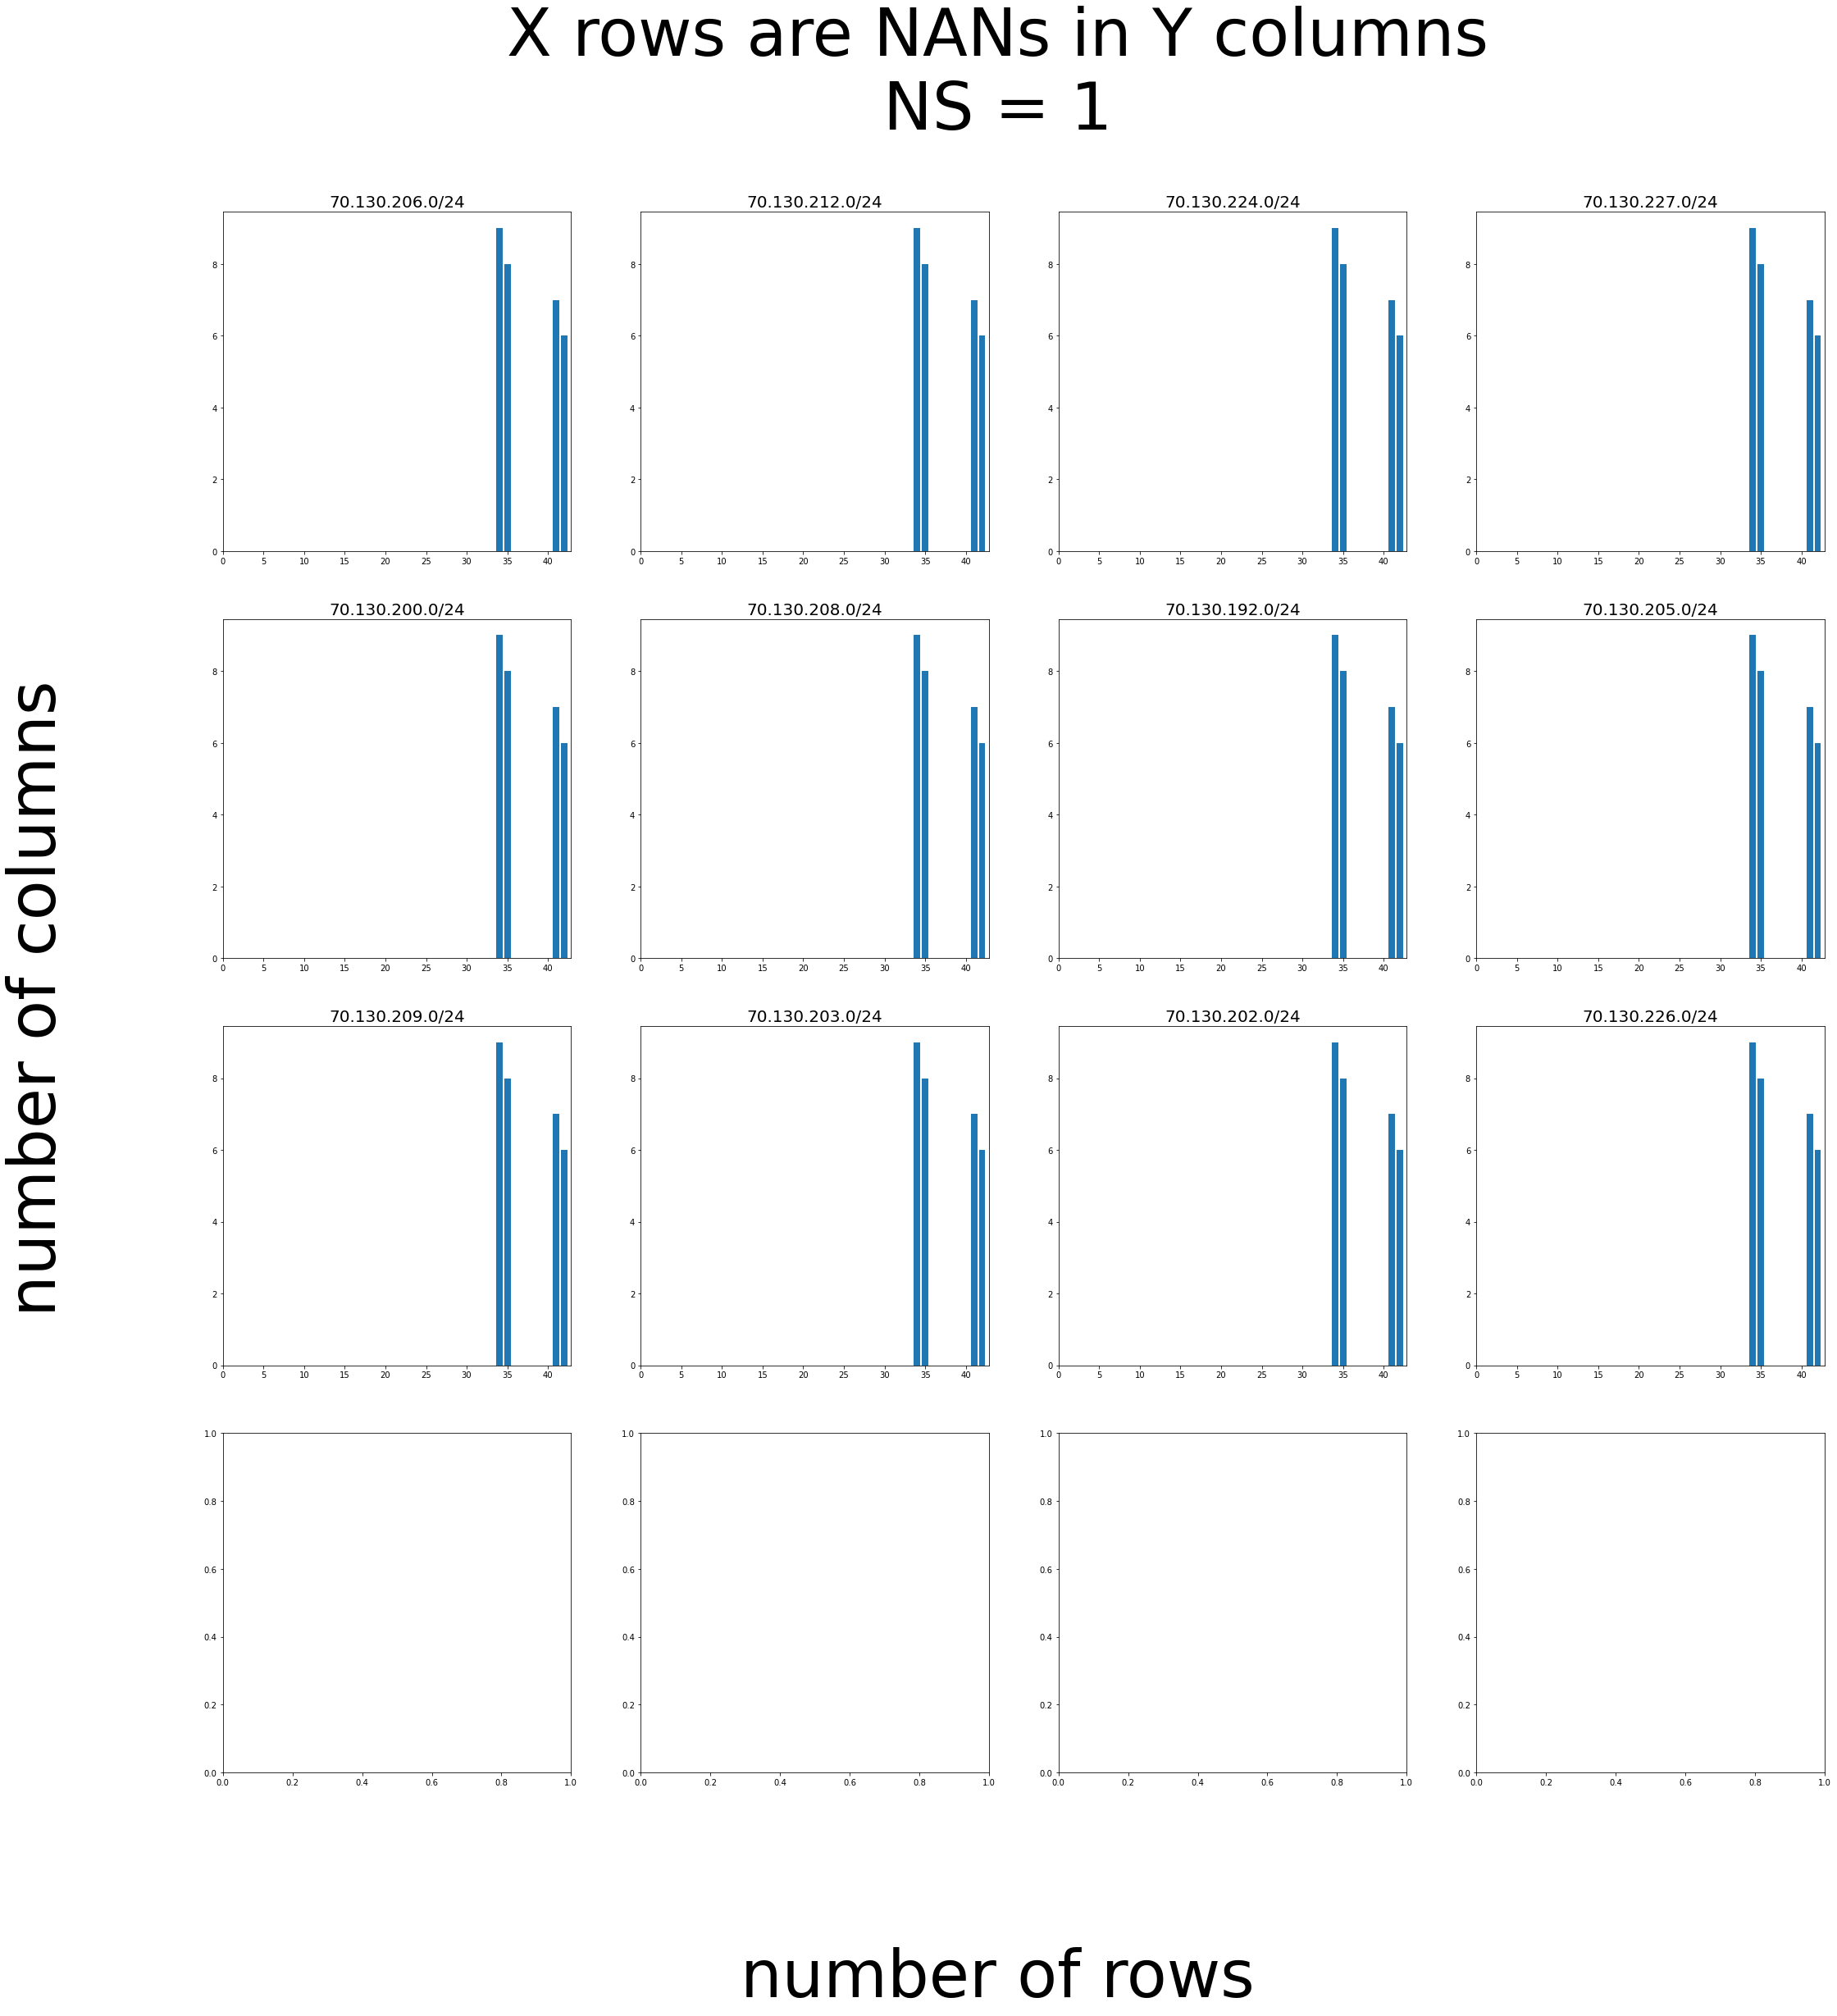

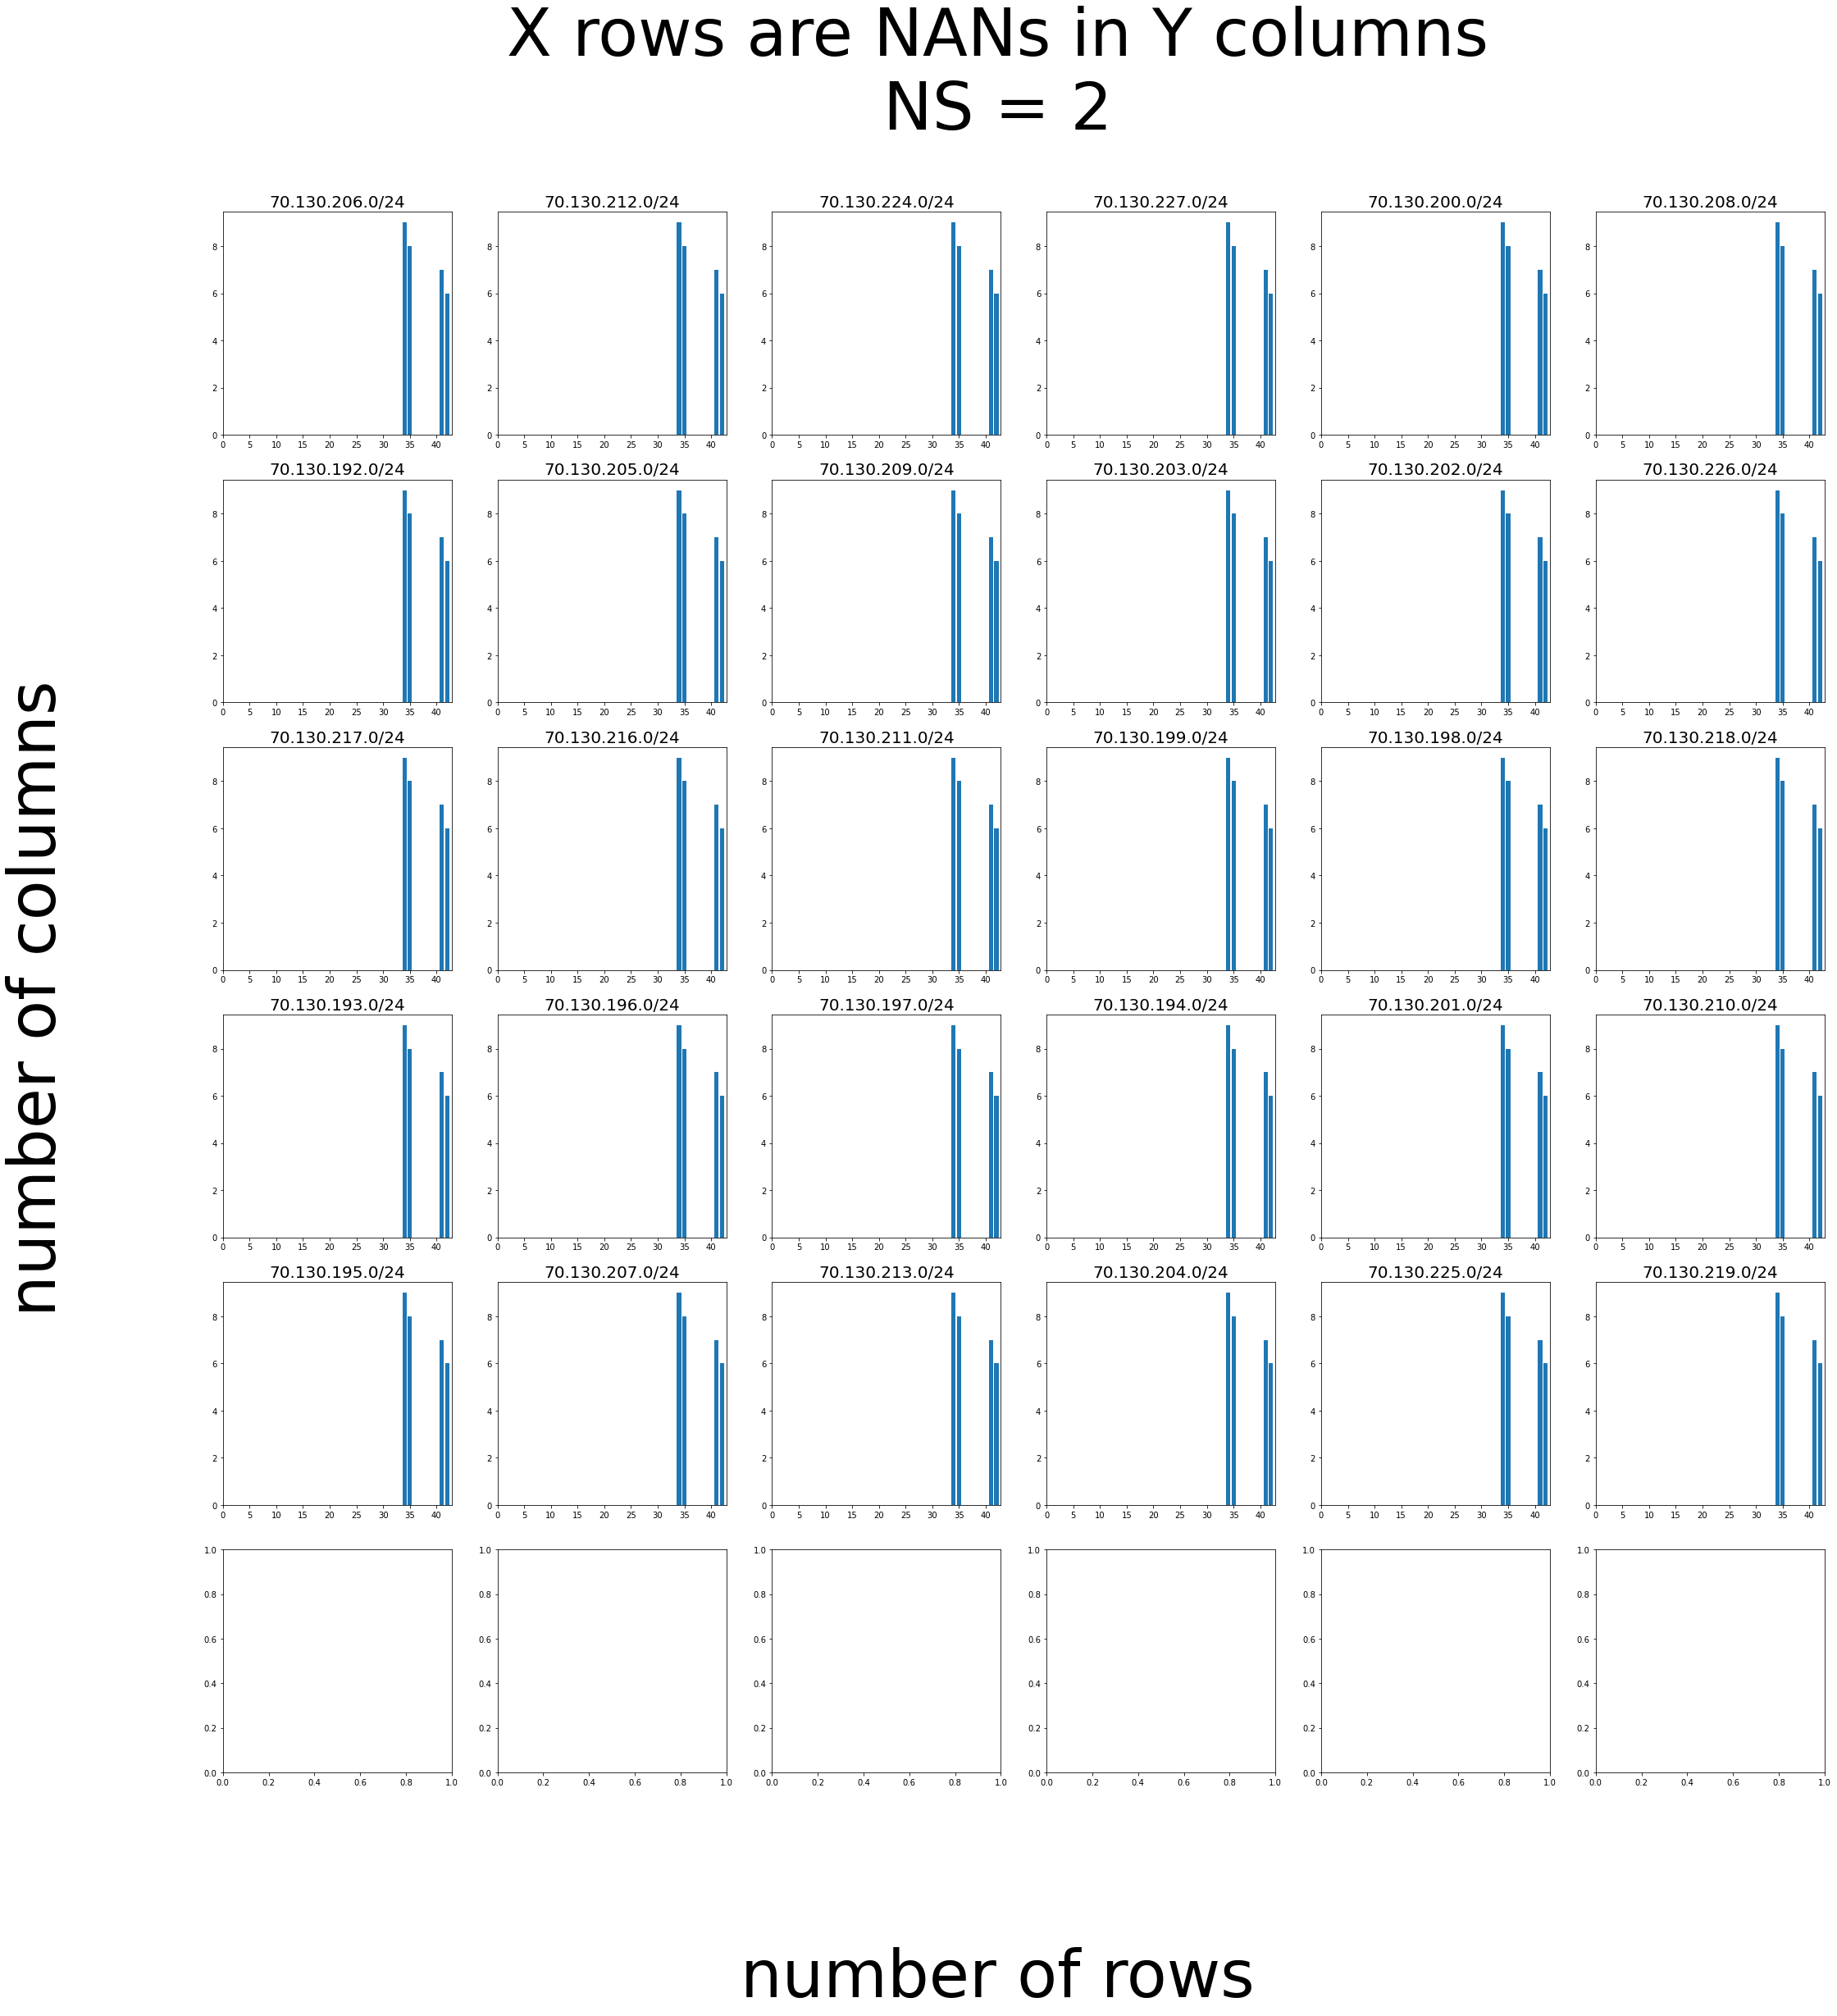

In [29]:

for ns in range(1, MAX_NUM_SERVICES+1):
    
    
    grid_dim = np.ceil(np.sqrt(sum([ns in dd for dd in prefix2ns2nancounters.values()]))).astype(int)
    fig, axes = plt.subplots(grid_dim, grid_dim, figsize=(35, 35))
    
    
    fig.suptitle(f"X rows are NANs in Y columns\nNS = {ns}", fontsize=80)
    fig.supxlabel("number of rows", fontsize=80)
    fig.supylabel("number of columns", fontsize=80)
    
    i = 0
    for prefix, dd in prefix2ns2nancounters.items():

            
        if ns in dd:
        
            counter = dd[ns][prefix]

            r, c = divmod(i, grid_dim)
            axes[r][c].bar(x=list(cnt.keys()), height=list(cnt.values()))
            axes[r][c].set_xlim(0)
            axes[r][c].set_title(prefix, fontsize=20)
            i += 1


plt.show()

We looked at the distribution of missing data (NaNs) in each IP prefix to make sure all prefixes are similar. Thus, we can randomly pick a prefix and be sure that it is similar to all other prefixes w.r.t missing data.

However, we go one step further to ensure that the prefix is not sparse w.r.t IP data availability. Refer back to earlier IP data availability plot to verify 70% IP data availability is the highest possible value.

In [30]:
# pick a prefix
prefix = "70.130.212.0/24" # has 70% IP data availability

In [31]:
num_ips_in_prefix = len(dense_prefix_to_ip[raw_prefix_to_dense_prefix[prefix]])
prefix_capacity = ipaddress.ip_network(raw_prefix_to_dense_prefix[prefix]).num_addresses
print(f"data availability for {raw_prefix_to_dense_prefix[prefix]} = ", num_ips_in_prefix / prefix_capacity)

data availability for 70.130.212.0/26 =  0.703125


In [32]:
def debug_df_cols():
    ## why are ns=1 df so skinny. ncols=18
    # >> answer: ns=1 don't have TLS subattribute
    print(prefix_to_df["70.130.208.0/24"][1])

    for d in data:
        if d["host_identifier"]["ipv4"] == "70.130.208.29":
            print(json.dumps(d, indent=2))
            break

    ## why were there so many NA columns?
    # >> answer: fixed logic bug (moved drop na columns to the end of json_to_pandas)
    df = prefix_to_df["70.130.201.0/24"][2]
    print(df.shape, df.dropna(how="all", axis=1).shape)

    # for c in df:
    nas_counts = df.isna().sum()
    print(nas_counts)
    print(Counter(nas_counts[nas_counts!=0]))

    print(df["services.jarm.tls_extensions_sha256_hex.0"])

    ## why were there so many NA columns?
    # >> answer: fixed logic bug (moved drop na columns to the end of json_to_pandas)
    print(prefix_to_df["70.130.199.0/24"][2]["host_identifier.ipv4"].head())
    for d in data:
        if d["host_identifier"]["ipv4"] == "70.130.199.10":
            print(json.dumps(d, indent=2))
            break

# debug_df_cols()

### IP Prefix Encoding

An IP can have more than one service, in which case the number of features for that IP will multiply. For example, an IP with 3 services will have 3 columns for the *port* feature, *port.0*, *port.1*, *port.2*. This way, each IP is consolidated into a single wide row in the data feature matrix. This also means, within each IP prefix, we must group the IPs based on the number of services running on it. 

Note: Refer to previous cells to see the distribution of number of services. The prefix set in the notebook has 2 services.

To convert the categorical features into numerical values for clustering & AE training, we use a label encoder to assign integer values to each categorical feature.

We take special care of IPv4 features, e.g. `ipv4`, `source_ip`, to ensure the label encoder preserves the IP ordering.

In [33]:
class DataEncoder:
    
    def __init__(self, order_ip):
        self.multilabel_encoder = preprocessing.MultiLabelBinarizer()
        self.label_encoder = preprocessing.LabelEncoder()
        self.onehot_encoder = preprocessing.OneHotEncoder()
        
        self.order_ip = order_ip
        self.col_to_reduced_col = None
        self.reduced_col_to_unique_values = None
        
        # for ip ordering
        self.col_to_isIP = dict()
        self.col_to_IPvalues = dict()
        self.col_to_ordering = dict()
        
        self.column_to_nan_encoding = dict()
    
    def multilabel_encode(self, ip_list):
        return self.multilabel_encoder.fit_transform(ip_list)
    
    def encode_ports(self, ip_list):
        if not isinstance(ip_list, list):
            ip_list = list(ip_list)
        return self.multilabel_encode([ip.ports_list for ip in ip_list])

    def is_valid_ip(self, ip_str):
        try:
            ipaddress.ip_address(ip_str)
        except ValueError:
            return False
        return True
    
    def encode_dataframe(self, df, verbose=False):
        # returns None, cuz df is a pointer to
        # a mutable object
        
        # Note: data values are cast to str
        # this deals with np.nan and label_encoder problems
        
        # get unique values for each "reduced" column
        ## e.g. columns: services.perspective.0, services.perspective.1, services.perspective.2
        ## reduced column: services.perspective
        pattern = re.compile(r"([0-9a-zA-Z_]+\.+)+\d+$")
        self.col_to_reduced_col = dict()
        self.reduced_col_to_unique_values = defaultdict(set)
        for c in df.columns:
            if pattern.fullmatch(c):
                rc = c[:c.rindex(".")]
                self.col_to_reduced_col[c] = rc
                self.reduced_col_to_unique_values[rc] = self.reduced_col_to_unique_values[rc].union(set(df[c].unique().astype(str)))
            else:
                ## non-duplicate column (i.e. any metacolumns) e.g. host_identifier.ipv4 location.country
                self.col_to_reduced_col[c] = c
                self.reduced_col_to_unique_values[c] = self.reduced_col_to_unique_values[c].union(set(df[c].unique().astype(str)))
        
        # fit encoder and transform columns
        for c in df:
            unique_values = list(self.reduced_col_to_unique_values[self.col_to_reduced_col[c]])
            
            # if column is IP address, e.g. ip_source
            # convert to ip_address object to use ip addr ordering
            # BUT, nan values will mess you up!!!
            
            non_nan_values = [v for v in unique_values if v != str(np.nan)]
            if verbose:
                print(non_nan_values)
            if self.order_ip and non_nan_values and self.is_valid_ip(non_nan_values[0]):
                
                if verbose:
                    print("\n\n"+"="*30)
                    print(c, "is an IP column", unique_values)
                
                self.col_to_isIP[c] = True
                
                ORDERING = ["nan"] + list(sorted([ipaddress.ip_address(v) for v in non_nan_values]))
                STR_TO_ORDER = lambda x: ORDERING.index(x) \
                    if x == str(np.nan) \
                    else ORDERING.index(ipaddress.ip_address(x))
                df_ip_col_order = df[c].astype(str).apply(STR_TO_ORDER)
                df[c] = self.label_encoder.fit_transform(df_ip_col_order)
                
                self.col_to_IPvalues[c] = df_ip_col_order
                self.col_to_ordering[c] = ORDERING

            else:
                self.col_to_isIP[c] = False
                self.label_encoder.fit(unique_values)
                df[c] = self.label_encoder.transform(df[c].astype(str))
                if verbose:
                    print(c, self.col_to_reduced_col.get(c), unique_values)

                if any(df[c].isnull()):
                    self.column_to_nan_encoding[c] = self.label_encoder.transform([np.nan])[0]
    
    def decode_dataframe(self, df, verbose=False):
        
        if self.col_to_reduced_col is None and self.reduced_col_to_unique_values is None:
            raise ValueError("run encode_dataframe first")
        
        for c in df:
            unique_values = list(self.reduced_col_to_unique_values[self.col_to_reduced_col[c]])
            
            non_nan_values = [v for v in unique_values if v != str(np.nan)]
            if self.order_ip and self.col_to_isIP[c]:
                if verbose:
                    print("\n\n"+"="*30)
                    print(c, "is an IP column", unique_values)
                self.label_encoder.fit(self.col_to_IPvalues[c])
                STR_TO_ORDER = self.col_to_ordering[c]
                df[c] = self.label_encoder.inverse_transform(df[c]) #Label Encoding --> IP Order
                ORDERING = self.col_to_ordering[c]
                df[c] = df[c].transform(lambda order: ORDERING[order]) #IP Order -> IP addr (str)
            else:
                self.label_encoder.fit(unique_values)
                df[c] = self.label_encoder.inverse_transform(df[c].astype(int)) # cast back to int
                if verbose:
                    print(c, len(unique_values), unique_values)
        

as a sanity check, encode/decode two dataframes

In [34]:
for boolean in [True, False]:
    encoder = DataEncoder(order_ip = boolean)
    df = prefix_to_df[prefix][1].copy()
    encoder.encode_dataframe(df, verbose=True)
    display(df.head())
    
    df2 = df.copy()
    encoder.decode_dataframe(df2, verbose=False)
    display(df2.head())

for boolean in [True, False]:
    encoder = DataEncoder(order_ip = boolean)

    df = prefix_to_df[prefix][2].copy()
    lbl_encoder = encoder.encode_dataframe(df, verbose=True) #v=True check ipv4 columns
    display(df.head())

    df2 = df.copy()
    encoder.decode_dataframe(df2, verbose=False)
    display(df2.head())

['70.130.212.29', '70.130.212.28']


host_identifier.ipv4 is an IP column ['70.130.212.29', '70.130.212.28']


host_identifier.ipv4
0                     1
1                     0

host_identifier.ipv4
0        70.130.212.29
1        70.130.212.28

['70.130.212.29', '70.130.212.28']
host_identifier.ipv4 host_identifier.ipv4 ['70.130.212.29', '70.130.212.28']


host_identifier.ipv4
0                     1
1                     0

host_identifier.ipv4
0        70.130.212.29
1        70.130.212.28

['70.130.212.60', '70.130.212.2', '70.130.212.37', '70.130.212.58', '70.130.212.57', '70.130.212.19', '70.130.212.55', '70.130.212.38', '70.130.212.43', '70.130.212.32', '70.130.212.46', '70.130.212.49', '70.130.212.41', '70.130.212.45', '70.130.212.39', '70.130.212.36', '70.130.212.48', '70.130.212.11', '70.130.212.5', '70.130.212.16', '70.130.212.21', '70.130.212.61', '70.130.212.62', '70.130.212.33', '70.130.212.44', '70.130.212.59', '70.130.212.34', '70.130.212.51', '70.130.212.47', '70.130.212.52', '70.130.212.53', '70.130.212.40', '70.130.212.54', '70.130.212.15', '70.130.212.22', '70.130.212.50', '70.130.212.8', '70.130.212.56', '70.130.212.42', '70.130.212.13', '70.130.212.35', '70.130.212.18', '70.130.212.20']


host_identifier.ipv4 is an IP column ['70.130.212.60', '70.130.212.2', '70.130.212.37', '70.130.212.58', '70.130.212.57', '70.130.212.19', '70.130.212.55', '70.130.212.38', '70.130.212.43', '70.130.212.32', '70.130.212.46', '70.130.212.49', '70.130.212.41', '70.130.212

services.jarm.cipher_and_version_fingerprint_hex.1 services.jarm.cipher_and_version_fingerprint_hex ['29d29d00029d29d21c29d29d29d29d', 'nan']
['6bf9fe505101042d5ba1e2cf076b15c5']
services.jarm.tls_extensions_sha256_hex.1 services.jarm.tls_extensions_sha256_hex ['6bf9fe505101042d5ba1e2cf076b15c5', 'nan']


host_identifier.ipv4  services.port.0  services.port.1  \
0                     3                1                0   
1                     4                1                0   
2                     5                1                0   
3                     6                1                0   
4                     7                1                0   

   services.perspective.0  services.perspective.1  \
0                       1                       0   
1                       1                       3   
2                       0                       3   
3                       1                       3   
4                       3                       1   

   services.software.uniform_resource_identifier.0  services.software.part.0  \
0                                                1                         1   
1                                                1                         1   
2                                                1                         1   
3                                                1                         1   
4                                                1                         1   

   services.software.vendor.0  services.software.product.0  \
0                           1                            1   
1                           1                            1   
2                           1                            1   
3                           1                            1   
4                           1                            1   

   services.software.source.0  ...  \
0                           1  ...   
1                           1  ...   
2                           1  ...   
3                           1  ...   
4                           1  ...   

   services.tls.certificates.chain.fingerprint.1  \
0                                              4   
1                                              4   
2                                              4   
3                                              4   
4                                              4   

   services.tls.certificates.chain.subject_dn.1  \
0                                             4   
1                                             4   
2                                             4   
3                                             4   
4                                             4   

   services.tls.certificates.chain.issuer_dn.1  services.jarm.fingerprint.1  \
0                                            4                            1   
1                                            4                            1   
2                                            4                            1   
3                                            4                            1   
4                                            4                            1   

   services.jarm.cipher_and_version_fingerprint.1  \
0                                               1   
1                                               1   
2                                               1   
3                                               1   
4                                               1   

   services.jarm.tls_extensions_sha256.1  services.jarm.observed_at.1  \
0                                      1                            6   
1                                      1                            6   
2                                      1                            6   
3                                      1                            6   
4                                      1                            6   

   services.jarm.fingerprint_hex.1  \
0                                1   
1                                1   
2                                1   
3                                1   
4                                1   

   services.jarm.cipher_and_version_fingerprint_hex.1  \
0                                                  1    
1                                     

host_identifier.ipv4 services.port.0 services.port.1 services.perspective.0  \
0        70.130.212.11              80             443                    NTT   
1        70.130.212.13              80             443                    NTT   
2        70.130.212.15              80             443                     HE   
3        70.130.212.16              80             443                    NTT   
4        70.130.212.18              80             443                   TATA   

  services.perspective.1 services.software.uniform_resource_identifier.0  \
0                     HE                                             nan   
1                   TATA                                             nan   
2                   TATA                                             nan   
3                   TATA                                             nan   
4                    NTT                                             nan   

  services.software.part.0 services.software.vendor.0  \
0                      nan                        nan   
1                      nan                        nan   
2                      nan                        nan   
3                      nan                        nan   
4                      nan                        nan   

  services.software.product.0 services.software.source.0  ...  \
0                         nan                        nan  ...   
1                         nan                        nan  ...   
2                         nan                        nan  ...   
3                         nan                        nan  ...   
4                         nan                        nan  ...   

  services.tls.certificates.chain.fingerprint.1  \
0                                           nan   
1                                           nan   
2                                           nan   
3                                           nan   
4                                           nan   

  services.tls.certificates.chain.subject_dn.1  \
0                                          nan   
1                                          nan   
2                                          nan   
3                                          nan   
4                                          nan   

  services.tls.certificates.chain.issuer_dn.1 services.jarm.fingerprint.1  \
0                                         nan                         nan   
1                                         nan                         nan   
2                                         nan                         nan   
3                                         nan                         nan   
4                                         nan                         nan   

  services.jarm.cipher_and_version_fingerprint.1  \
0                                            nan   
1                                            nan   
2                                            nan   
3                                            nan   
4                                            nan   

  services.jarm.tls_extensions_sha256.1 services.jarm.observed_at.1  \
0                                   nan                         nan   
1                                   nan                         nan   
2                                   nan                         nan   
3                                   nan                         nan   
4                                   nan                         nan   

  services.jarm.fingerprint_hex.1  \
0                             nan   
1                             nan   
2                             nan   
3                             nan   
4                             nan   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                                                nan   
1                                                nan   
2                                                nan   
3                                                nan   
4         

['70.130.212.60', '70.130.212.2', '70.130.212.37', '70.130.212.58', '70.130.212.57', '70.130.212.19', '70.130.212.55', '70.130.212.38', '70.130.212.43', '70.130.212.32', '70.130.212.46', '70.130.212.49', '70.130.212.41', '70.130.212.45', '70.130.212.39', '70.130.212.36', '70.130.212.48', '70.130.212.11', '70.130.212.5', '70.130.212.16', '70.130.212.21', '70.130.212.61', '70.130.212.62', '70.130.212.33', '70.130.212.44', '70.130.212.59', '70.130.212.34', '70.130.212.51', '70.130.212.47', '70.130.212.52', '70.130.212.53', '70.130.212.40', '70.130.212.54', '70.130.212.15', '70.130.212.22', '70.130.212.50', '70.130.212.8', '70.130.212.56', '70.130.212.42', '70.130.212.13', '70.130.212.35', '70.130.212.18', '70.130.212.20']
host_identifier.ipv4 host_identifier.ipv4 ['70.130.212.60', '70.130.212.2', '70.130.212.37', '70.130.212.58', '70.130.212.57', '70.130.212.19', '70.130.212.55', '70.130.212.38', '70.130.212.43', '70.130.212.32', '70.130.212.46', '70.130.212.49', '70.130.212.41', '70.130.

host_identifier.ipv4  services.port.0  services.port.1  \
0                     0                1                0   
1                     1                1                0   
2                     2                1                0   
3                     3                1                0   
4                     4                1                0   

   services.perspective.0  services.perspective.1  \
0                       1                       0   
1                       1                       3   
2                       0                       3   
3                       1                       3   
4                       3                       1   

   services.software.uniform_resource_identifier.0  services.software.part.0  \
0                                                1                         1   
1                                                1                         1   
2                                                1                         1   
3                                                1                         1   
4                                                1                         1   

   services.software.vendor.0  services.software.product.0  \
0                           1                            1   
1                           1                            1   
2                           1                            1   
3                           1                            1   
4                           1                            1   

   services.software.source.0  ...  \
0                           1  ...   
1                           1  ...   
2                           1  ...   
3                           1  ...   
4                           1  ...   

   services.tls.certificates.chain.fingerprint.1  \
0                                              4   
1                                              4   
2                                              4   
3                                              4   
4                                              4   

   services.tls.certificates.chain.subject_dn.1  \
0                                             4   
1                                             4   
2                                             4   
3                                             4   
4                                             4   

   services.tls.certificates.chain.issuer_dn.1  services.jarm.fingerprint.1  \
0                                            4                            1   
1                                            4                            1   
2                                            4                            1   
3                                            4                            1   
4                                            4                            1   

   services.jarm.cipher_and_version_fingerprint.1  \
0                                               1   
1                                               1   
2                                               1   
3                                               1   
4                                               1   

   services.jarm.tls_extensions_sha256.1  services.jarm.observed_at.1  \
0                                      1                            6   
1                                      1                            6   
2                                      1                            6   
3                                      1                            6   
4                                      1                            6   

   services.jarm.fingerprint_hex.1  \
0                                1   
1                                1   
2                                1   
3                                1   
4                                1   

   services.jarm.cipher_and_version_fingerprint_hex.1  \
0                                                  1    
1                                     

host_identifier.ipv4 services.port.0 services.port.1 services.perspective.0  \
0        70.130.212.11              80             443                    NTT   
1        70.130.212.13              80             443                    NTT   
2        70.130.212.15              80             443                     HE   
3        70.130.212.16              80             443                    NTT   
4        70.130.212.18              80             443                   TATA   

  services.perspective.1 services.software.uniform_resource_identifier.0  \
0                     HE                                             nan   
1                   TATA                                             nan   
2                   TATA                                             nan   
3                   TATA                                             nan   
4                    NTT                                             nan   

  services.software.part.0 services.software.vendor.0  \
0                      nan                        nan   
1                      nan                        nan   
2                      nan                        nan   
3                      nan                        nan   
4                      nan                        nan   

  services.software.product.0 services.software.source.0  ...  \
0                         nan                        nan  ...   
1                         nan                        nan  ...   
2                         nan                        nan  ...   
3                         nan                        nan  ...   
4                         nan                        nan  ...   

  services.tls.certificates.chain.fingerprint.1  \
0                                           nan   
1                                           nan   
2                                           nan   
3                                           nan   
4                                           nan   

  services.tls.certificates.chain.subject_dn.1  \
0                                          nan   
1                                          nan   
2                                          nan   
3                                          nan   
4                                          nan   

  services.tls.certificates.chain.issuer_dn.1 services.jarm.fingerprint.1  \
0                                         nan                         nan   
1                                         nan                         nan   
2                                         nan                         nan   
3                                         nan                         nan   
4                                         nan                         nan   

  services.jarm.cipher_and_version_fingerprint.1  \
0                                            nan   
1                                            nan   
2                                            nan   
3                                            nan   
4                                            nan   

  services.jarm.tls_extensions_sha256.1 services.jarm.observed_at.1  \
0                                   nan                         nan   
1                                   nan                         nan   
2                                   nan                         nan   
3                                   nan                         nan   
4                                   nan                         nan   

  services.jarm.fingerprint_hex.1  \
0                             nan   
1                             nan   
2                             nan   
3                             nan   
4                             nan   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                                                nan   
1                                                nan   
2                                                nan   
3                                                nan   
4         

Encode the dataframe for the selected prefix. Use the set of IPs that have 2 services running.

In [35]:
encoder = DataEncoder(order_ip=True)
df = prefix_to_df[prefix][2].copy()
encoder.encode_dataframe(df) #inplace
print("df shape", df.shape)

df shape (43, 38)


## Clustering in Raw Feature Space

Once the dataframes have been label encoded, we can directly cluster on the raw label feature space with [KMeans clustering](https://en.wikipedia.org/wiki/K-means_clustering).

A hyperparameter for KMeans clustering is `K`, which decides the number of clusters to create. Here, we try different values `range(5, NUM_IPs, 5)`. 5 is arbitrarily chosen as the minimum number of clusters. 

We will first look at `K=5` to find broad patterns. Then, to find more specific pattern, we use the "optimal" number of clusters based on the [Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)#:~:text=In%20cluster%20analysis%2C%20the%20elbow,number%20of%20clusters%20to%20use.).  

In [36]:
def clustering_raw_features(X_data, feature_names, k_list=None):
    
    if k_list is None:
        k_list = range(5, X_data.shape[0], 5)
    
    cluster_ids = dict() #K -> cluster IDs (int)
    inertia_list = []
    for k in k_list:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X_data)
        cluster_ids[k] = kmeans.labels_
        inertia_list.append(kmeans.inertia_)       
        
    # convert cluster IDs to actual np.array
    ## k -> cid -> list(IP np arrays) x2
    clusters = defaultdict(lambda: defaultdict(list))
    for k, cid_list in cluster_ids.items():
        for cid, arr in zip(cid_list, X_data):
            clusters[k][cid].append(arr.reshape((1, -1)))
            
    ## k -> cid -> dataframe 
    for k, cid2list in clusters.items():
        for cid, arr_list in cid2list.items():
            raw_arr = np.concatenate(arr_list, axis=0) # concat(list(IP np arrays))
            raw_ip_df = pd.DataFrame(raw_arr, columns=feature_names)
            encoder.decode_dataframe(raw_ip_df)
            
            ## convert "nan" back to np.nan
            for col in raw_ip_df:
                raw_ip_df[col] = raw_ip_df[col].transform(lambda x: np.nan if x == "nan" else x)
            clusters[k][cid] = raw_ip_df
    
    plt.suptitle("KMeans Elbow with Inertia")
    plt.plot(k_list, inertia_list, "*-")
    plt.xlabel("k")
    plt.ylabel("Inertia = Sum of sq. dist of samples\nto closest cluster center")
    plt.show()
    
    return clusters

def drop_homogeneous_columns(df, exceptions):
    # drop columns with only 1 distinct value
    # make sure you look at duplicates across n_services
    df = df.copy()
    pattern = re.compile(r"([0-9a-zA-Z_]+\.+)+\d+$")
    col_to_reduced_col = dict()
    reduced_col_to_unique_values = defaultdict(set)
    for c in df.columns:
        if pattern.fullmatch(c):
            rc = c[:c.rindex(".")]
            col_to_reduced_col[c] = rc
            reduced_col_to_unique_values[rc] = reduced_col_to_unique_values[rc].union(set(df[c].unique().astype(str)))
        else:
            ## non-duplicate column (i.e. any metacolumns) e.g. host_identifier.ipv4 location.country
            col_to_reduced_col[c] = c
            reduced_col_to_unique_values[c] = reduced_col_to_unique_values[c].union(set(df[c].unique().astype(str)))
    # look at unique values across reduced column
    for col in df.columns:
        if len(reduced_col_to_unique_values[col_to_reduced_col[col]]) == 1:
            if col not in exceptions:
                df = df.drop(col,inplace=False,axis=1)
    return df

def examine_raw_clusters(clusters, columns=None):
    if columns is None:
        columns = []
        
    max_cols_temp = pd.options.display.max_columns
    pd.options.display.max_columns = None
    
    # examine clusters from largest to smallest
    for frame_id, (cid, _) in enumerate(sorted(clusters.items(), key=lambda tup: -tup[1].shape[0])):
        orig_clust = clusters[cid]
        clust = drop_homogeneous_columns(orig_clust, exceptions=columns) # ignore non-discriminating features
        non_d_cols = set(orig_clust.columns) - set(clust.columns)
        non_discrim = orig_clust[list(non_d_cols)]
        
        print("="*10)
        print("Frame", frame_id)
        print("orig_clust", cid, orig_clust.shape)
        print("cluster", cid, clust.shape)
        print("non discr columns (w/ nan)", non_discrim.shape[1])
        print("non discr columns (w/o nan)", non_discrim.dropna(axis=1, how="all").shape[1])
        
        if columns: #i.e. len(columns) != 0
            display(clust[columns])
        else:
            display(clust)
        if non_discrim.shape[1]:
            non_discrim = non_discrim.dropna(axis=1, how="all")
            non_discrim = non_discrim.reindex(sorted(non_discrim.columns), axis=1)
            display(non_discrim.head(1))
        print("="*10)
        
    pd.options.display.max_columns = max_cols_temp

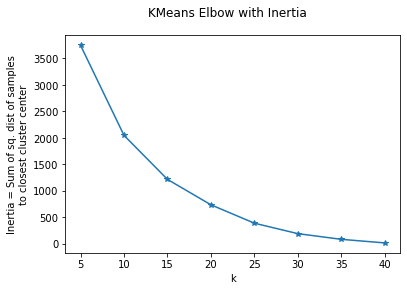

In [37]:
# cluster
all_raw_clusters = clustering_raw_features(df.to_numpy(), feature_names=df.columns)

### Examine Raw Clusters

set K equal to the **smallest possible value** to look for **broad** trends

The printouts will show the following information about the clusters:
- cluster order = decreasing cluster size
- IPs grouped by clusters
    - number of IPs
    - discriminating features
    - non-nan (not missing) non-discriminating features

In [38]:
K = 5
raw_clusters = all_raw_clusters[K]
examine_raw_clusters(raw_clusters)

Frame 0
orig_clust 1 (12, 38)
cluster 1 (12, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.port.0 services.port.1  \
0         70.130.212.40              80             443   
1         70.130.212.44              80             443   
2         70.130.212.48              80             443   
3         70.130.212.50              80             443   
4         70.130.212.51              80             443   
5         70.130.212.52              80             443   
6         70.130.212.54              80             443   
7         70.130.212.56              80             443   
8         70.130.212.59              80             443   
9         70.130.212.60              80             443   
10        70.130.212.61              80             443   
11        70.130.212.62              80             443   

   services.perspective.0 services.perspective.1 services.source_ip.0  \
0                      HE                   TATA      162.142.125.221   
1                      HE                   TATA      162.142.125.221   
2                   TELIA                     HE        167.94.146.60   
3                    TATA                     HE        167.94.138.61   
4                    TATA                   TATA        167.94.138.63   
5                      HE                     HE      162.142.125.219   
6                    TATA                   TATA        167.94.138.61   
7                  ORANGE                   TATA        167.94.145.59   
8                      HE                     HE      162.142.125.210   
9                      HE                     HE        162.142.125.9   
10                     HE                 ORANGE      162.142.125.211   
11                    NTT                   TATA       167.248.133.46   

   services.source_ip.1  
0         167.94.138.45  
1         167.94.138.63  
2       162.142.125.212  
3       162.142.125.211  
4         167.94.138.47  
5         162.142.125.8  
6        167.94.138.120  
7         167.94.138.45  
8         162.142.125.9  
9       162.142.125.213  
10        167.94.145.57  
11        167.94.138.63

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 1
orig_clust 4 (9, 38)
cluster 4 (9, 33)
non discr columns (w/ nan) 5
non discr columns (w/o nan) 0


host_identifier.ipv4 services.port.0 services.port.1 services.perspective.0  \
0        70.130.212.11              80             443                    NTT   
1        70.130.212.13              80             443                    NTT   
2        70.130.212.16              80             443                    NTT   
3        70.130.212.19              80             443                   TATA   
4        70.130.212.32              80             443                    NTT   
5        70.130.212.34              80             443                  TELIA   
6        70.130.212.42              80             443                    NTT   
7         70.130.212.5              80             443                 ORANGE   
8         70.130.212.8              80             443                  TELIA   

  services.perspective.1 services.source_ip.0 services.source_ip.1  \
0                     HE      167.248.133.119      162.142.125.222   
1                   TATA      167.248.133.117        167.94.138.63   
2                   TATA       167.248.133.63        167.94.138.45   
3                     HE       167.94.138.118        162.142.125.9   
4                     HE       167.248.133.63        162.142.125.9   
5                   TATA        167.94.146.59       167.94.138.118   
6                     HE      167.248.133.120        162.142.125.8   
7                   TATA        167.94.145.58        167.94.138.46   
8                     HE        167.94.146.60      162.142.125.220   

  services.extended_service_name.0 services.extended_service_name.1  \
0                             HTTP                             HTTP   
1                             HTTP                             HTTP   
2                             HTTP                             HTTP   
3                             HTTP                             HTTP   
4                             HTTP                            HTTPS   
5                             HTTP                            HTTPS   
6                             HTTP                             HTTP   
7                             HTTP                             HTTP   
8                             HTTP                             HTTP   

  services.tls.certificates.chain_fps_sha_256.1  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4  k8SeCZ4/QNmQmg2yOpvm1jmoMj3QhpsredgDJljZhhU=   
5  k8SeCZ4/QNmQmg2yOpvm1jmoMj3QhpsredgDJljZhhU=   
6                                           NaN   
7                                           NaN   
8                                           NaN   

  services.tls.certificates.leaf_data.names.1  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4            distribution.cloudfront-test.net   
5            distribution.cloudfront-test.net   
6                                         NaN   
7                                         NaN   
8                                         NaN   

  services.tls.certificates.leaf_data.issuer.common_name.1  \
0                                                NaN         
1                                                NaN         
2                                                NaN         
3                                                NaN         
4                   distribution.cloudfront-test.net         
5                   distribution.cloudfront-test.net         
6                                                NaN         
7                                                NaN         
8                                                NaN         

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                NaN      
1                                     

Empty DataFrame
Columns: []
Index: [0]

Frame 2
orig_clust 0 (9, 38)
cluster 0 (9, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.port.0 services.port.1 services.perspective.0  \
0        70.130.212.43              80             443                   TATA   
1        70.130.212.45              80             443                 ORANGE   
2        70.130.212.46              80             443                    NTT   
3        70.130.212.47              80             443                  TELIA   
4        70.130.212.49              80             443                   TATA   
5        70.130.212.53              80             443                    NTT   
6        70.130.212.55              80             443                   TATA   
7        70.130.212.57              80             443                   TATA   
8        70.130.212.58              80             443                   TATA   

  services.perspective.1 services.source_ip.0 services.source_ip.1  
0                  TELIA        167.94.138.62        167.94.146.58  
1                  TELIA        167.94.145.58        167.94.146.59  
2                    NTT       167.248.133.46      167.248.133.117  
3                   TATA        167.94.146.60       167.94.138.119  
4                  TELIA        167.94.138.61        167.94.146.57  
5                    NTT       167.248.133.46      167.248.133.118  
6                    NTT        167.94.138.46       167.248.133.61  
7                    NTT        167.94.138.62      167.248.133.119  
8                    NTT       167.94.138.119       167.248.133.46

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 3
orig_clust 3 (7, 38)
cluster 3 (7, 26)
non discr columns (w/ nan) 12
non discr columns (w/o nan) 0


host_identifier.ipv4 services.port.0 services.port.1 services.perspective.0  \
0        70.130.212.33              80             443                     HE   
1        70.130.212.35              80             443                    NTT   
2        70.130.212.36              80             443                    NTT   
3        70.130.212.37              80             443                    NTT   
4        70.130.212.38              80             443                   TATA   
5        70.130.212.39              80             443                     HE   
6        70.130.212.41              80             443                    NTT   

  services.perspective.1 services.source_ip.0 services.source_ip.1  \
0                  TELIA      162.142.125.221        167.94.146.57   
1                    NTT       167.248.133.47       167.248.133.46   
2                 ORANGE      167.248.133.118        167.94.145.59   
3                    NTT      167.248.133.118      167.248.133.119   
4                    NTT        167.94.138.63       167.248.133.47   
5                  TELIA      162.142.125.212        167.94.146.60   
6                    NTT      167.248.133.117       167.248.133.46   

  services.extended_service_name.0 services.extended_service_name.1  \
0                             HTTP                            HTTPS   
1                             HTTP                            HTTPS   
2                             HTTP                            HTTPS   
3                             HTTP                            HTTPS   
4                             HTTP                            HTTPS   
5                             HTTP                            HTTPS   
6                             HTTP                            HTTPS   

  services.tls.certificates.chain_fps_sha_256.1  \
0  9V+f/Lg8c0UyYWAcfgRNsVoPA0uTwFgw8oY174ic9nA=   
1  9V+f/Lg8c0UyYWAcfgRNsVoPA0uTwFgw8oY174ic9nA=   
2  9V+f/Lg8c0UyYWAcfgRNsVoPA0uTwFgw8oY174ic9nA=   
3  9V+f/Lg8c0UyYWAcfgRNsVoPA0uTwFgw8oY174ic9nA=   
4  9V+f/Lg8c0UyYWAcfgRNsVoPA0uTwFgw8oY174ic9nA=   
5  efH1q2l96/GV9bfaZflTmWgu2uuAEVudQqauXi+piAI=   
6  j6xXZDnJ/T7xU7Ufnt0NOBtd97h1Wc6+ygQpfdRKY5s=   

  services.tls.certificates.leaf_data.names.1  \
0                      download.epicgames.com   
1                       *.cf-vps.cf-embed.net   
2                    *.eu-west-2.cf-embed.net   
3                            *.cloudfront.net   
4           load-test6.eu-west-2.cf-embed.net   
5                                   *.2144.cn   
6               d1s31zyz7dcc2d.cloudfront.net   

  services.tls.certificates.leaf_data.issuer.common_name.1  \
0                                             Amazon         
1                                             Amazon         
2                                             Amazon         
3                                             Amazon         
4                                             Amazon         
5                               TrustAsia TLS RSA CA         
6                              DigiCert Global CA G2         

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                                             Amazon          
1                                             Amazon          
2                                             Amazon          
3                                             Amazon          
4                                             Amazon          
5                       TrustAsia Technologies, Inc.          
6                                       DigiCert Inc          

  services.tls.certificates.leaf_data.issuer.organizational_unit.1  \
0                                       Server CA 1B                 
1                                       Server CA 1B                 
2                                       Server CA 1B                 
3                                       Server CA 1B                 
4                                       Server CA 1B                 

Empty DataFrame
Columns: []
Index: [0]

Frame 4
orig_clust 2 (6, 38)
cluster 2 (6, 12)
non discr columns (w/ nan) 26
non discr columns (w/o nan) 2


host_identifier.ipv4 services.port.0 services.port.1 services.perspective.0  \
0        70.130.212.15              80             443                     HE   
1        70.130.212.18              80             443                   TATA   
2         70.130.212.2              80             443                   TATA   
3        70.130.212.20              80             443                     HE   
4        70.130.212.21              80             443                     HE   
5        70.130.212.22              80             443                     HE   

  services.perspective.1    services.software.uniform_resource_identifier.0  \
0                   TATA                                                NaN   
1                    NTT                                                NaN   
2                  TELIA                                                NaN   
3                    NTT                                                NaN   
4                  TELIA  cpe:2.3:a:amazon:amazon_cloudfront:*:*:*:*:*:*...   
5                    NTT                                                NaN   

  services.software.part.0 services.software.vendor.0  \
0                      NaN                        NaN   
1                      NaN                        NaN   
2                      NaN                        NaN   
3                      NaN                        NaN   
4                        a                     Amazon   
5                      NaN                        NaN   

  services.software.product.0 services.software.source.0 services.source_ip.0  \
0                         NaN                        NaN      162.142.125.219   
1                         NaN                        NaN        167.94.138.63   
2                         NaN                        NaN       167.94.138.120   
3                         NaN                        NaN      162.142.125.212   
4    CloudFront Load Balancer      OSI_APPLICATION_LAYER      162.142.125.213   
5                         NaN                        NaN      162.142.125.212   

  services.source_ip.1  
0        167.94.138.47  
1       167.248.133.62  
2        167.94.146.58  
3      167.248.133.119  
4        167.94.146.57  
5      167.248.133.120

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

First, a note on the discriminating features. They can be split into two groups:  
- common features (associated with **all** of the IPs)
    - port: e.g. 80, 443
    - perspective: the Tier-1 ISPs (NTT, Tata, Hurricane Electric, Telia, Orange) that Censys probes went through to reach the IPs

    - source_ip: the IP Censys saw the service runnin on the IP from
        
- rare features (associated with **some** of the IPs)
    - services.tls.*
    - services.jarm.*: JARM is a TLS server fingerprinting tool

**Finding 1**: IPs in the range 30-41 have TLS/JARM encryption features. This is an indication that the network operators for this prefix reserves a section of the available IP range for a specific task, namely accepting client connections to HTTPS services.

**Observation**: the IPs for the *source_ip* feature come from a common set of /24 subnetworks: 167.94.138.0/24, 162.142.125.0/24, 167.94.146.0/24, 167.94.145.0/24, 167.248.133.0/24  

**(Non-)Observation**: So far, there isn't any pattern to the *perspective* feature. Let's dig deeper!

set K equal to the point where the Inertia curve starts degrading at a linear rate (**Elbow Method**) to look for **finer** trends

In [39]:
K = 20
raw_clusters = all_raw_clusters[K]
examine_raw_clusters(raw_clusters, columns=[
    "host_identifier.ipv4",
    "services.perspective.0",
    "services.perspective.1",
    "services.source_ip.0",
    "services.source_ip.1"
])

Frame 0
orig_clust 1 (4, 38)
cluster 1 (4, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.47                  TELIA                   TATA   
1        70.130.212.51                   TATA                   TATA   
2        70.130.212.54                   TATA                   TATA   
3        70.130.212.56                 ORANGE                   TATA   

  services.source_ip.0 services.source_ip.1  
0        167.94.146.60       167.94.138.119  
1        167.94.138.63        167.94.138.47  
2        167.94.138.61       167.94.138.120  
3        167.94.145.59        167.94.138.45

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 1
orig_clust 8 (3, 38)
cluster 8 (3, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.11                    NTT                     HE   
1        70.130.212.13                    NTT                   TATA   
2        70.130.212.16                    NTT                   TATA   

  services.source_ip.0 services.source_ip.1  
0      167.248.133.119      162.142.125.222  
1      167.248.133.117        167.94.138.63  
2       167.248.133.63        167.94.138.45

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 2
orig_clust 3 (3, 38)
cluster 3 (3, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.18                   TATA                    NTT   
1        70.130.212.20                     HE                    NTT   
2        70.130.212.22                     HE                    NTT   

  services.source_ip.0 services.source_ip.1  
0        167.94.138.63       167.248.133.62  
1      162.142.125.212      167.248.133.119  
2      162.142.125.212      167.248.133.120

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 3
orig_clust 19 (3, 38)
cluster 19 (3, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0         70.130.212.2                   TATA                  TELIA   
1         70.130.212.5                 ORANGE                   TATA   
2         70.130.212.8                  TELIA                     HE   

  services.source_ip.0 services.source_ip.1  
0       167.94.138.120        167.94.146.58  
1        167.94.145.58        167.94.138.46  
2        167.94.146.60      162.142.125.220

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 4
orig_clust 4 (3, 38)
cluster 4 (3, 26)
non discr columns (w/ nan) 12
non discr columns (w/o nan) 7


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.34                  TELIA                   TATA   
1        70.130.212.36                    NTT                 ORANGE   
2        70.130.212.41                    NTT                    NTT   

  services.source_ip.0 services.source_ip.1  
0        167.94.146.59       167.94.138.118  
1      167.248.133.118        167.94.145.59  
2      167.248.133.117       167.248.133.46

services.jarm.cipher_and_version_fingerprint.1  \
0                           KdKdAAKdKdIcKdKdKdKd   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                     29d29d00029d29d21c29d29d29d29d   

                    services.jarm.fingerprint.1  \
0  KdKdAAKdKdIcKdKdKdKda/n+UFEBBC1boeLPB2sVxQ==   

                     services.jarm.fingerprint_hex.1  \
0  29d29d00029d29d21c29d29d29d29d6bf9fe505101042d...   

  services.jarm.tls_extensions_sha256.1  \
0              a/n+UFEBBC1boeLPB2sVxQ==   

  services.jarm.tls_extensions_sha256_hex.1  \
0          6bf9fe505101042d5ba1e2cf076b15c5   

  services.tls.certificates.leaf_data.issuer.country.1  
0                                                 US

Frame 5
orig_clust 10 (3, 38)
cluster 10 (3, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.43                   TATA                  TELIA   
1        70.130.212.45                 ORANGE                  TELIA   
2        70.130.212.49                   TATA                  TELIA   

  services.source_ip.0 services.source_ip.1  
0        167.94.138.62        167.94.146.58  
1        167.94.145.58        167.94.146.59  
2        167.94.138.61        167.94.146.57

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 6
orig_clust 5 (3, 38)
cluster 5 (3, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.55                   TATA                    NTT   
1        70.130.212.57                   TATA                    NTT   
2        70.130.212.58                   TATA                    NTT   

  services.source_ip.0 services.source_ip.1  
0        167.94.138.46       167.248.133.61  
1        167.94.138.62      167.248.133.119  
2       167.94.138.119       167.248.133.46

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 7
orig_clust 17 (2, 38)
cluster 17 (2, 12)
non discr columns (w/ nan) 26
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.15                     HE                   TATA   
1        70.130.212.21                     HE                  TELIA   

  services.source_ip.0 services.source_ip.1  
0      162.142.125.219        167.94.138.47  
1      162.142.125.213        167.94.146.57

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 8
orig_clust 0 (2, 38)
cluster 0 (2, 12)
non discr columns (w/ nan) 26
non discr columns (w/o nan) 14


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.33                     HE                  TELIA   
1        70.130.212.38                   TATA                    NTT   

  services.source_ip.0 services.source_ip.1  
0      162.142.125.221        167.94.146.57  
1        167.94.138.63       167.248.133.47

services.jarm.cipher_and_version_fingerprint.1  \
0                           KdKdAAKdKdIcKdKdKdKd   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                     29d29d00029d29d21c29d29d29d29d   

                    services.jarm.fingerprint.1  \
0  KdKdAAKdKdIcKdKdKdKda/n+UFEBBC1boeLPB2sVxQ==   

                     services.jarm.fingerprint_hex.1  \
0  29d29d00029d29d21c29d29d29d29d6bf9fe505101042d...   

  services.jarm.tls_extensions_sha256.1  \
0              a/n+UFEBBC1boeLPB2sVxQ==   

  services.jarm.tls_extensions_sha256_hex.1  \
0          6bf9fe505101042d5ba1e2cf076b15c5   

       services.tls.certificates.chain.fingerprint.1  \
0  f55f9ffcb83c73453261601c7e044db15a0f034b93c058...   

  services.tls.certificates.chain.issuer_dn.1  \
0         C=US, O=Amazon, CN=Amazon Root CA 1   

  services.tls.certificates.chain.subject_dn.1  \
0   C=US, O=Amazon, OU=Server CA 1B, CN=Amazon   

  services.tls.certificates.chain_fps_sha_256.1  \
0  9V+f/Lg8c0UyYWAcfgRNsVoPA0uTwFgw8oY174ic9nA=   

  services.tls.certificates.leaf_data.issuer.common_name.1  \
0                                             Amazon         

  services.tls.certificates.leaf_data.issuer.country.1  \
0                                                 US     

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                                             Amazon          

  services.tls.certificates.leaf_data.issuer.organizational_unit.1  
0                                       Server CA 1B

Frame 9
orig_clust 18 (2, 38)
cluster 18 (2, 11)
non discr columns (w/ nan) 27
non discr columns (w/o nan) 8


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.35                    NTT                    NTT   
1        70.130.212.37                    NTT                    NTT   

  services.source_ip.0 services.source_ip.1  
0       167.248.133.47       167.248.133.46  
1      167.248.133.118      167.248.133.119

services.tls.certificates.chain.fingerprint.1  \
0  f55f9ffcb83c73453261601c7e044db15a0f034b93c058...   

  services.tls.certificates.chain.issuer_dn.1  \
0         C=US, O=Amazon, CN=Amazon Root CA 1   

  services.tls.certificates.chain.subject_dn.1  \
0   C=US, O=Amazon, OU=Server CA 1B, CN=Amazon   

  services.tls.certificates.chain_fps_sha_256.1  \
0  9V+f/Lg8c0UyYWAcfgRNsVoPA0uTwFgw8oY174ic9nA=   

  services.tls.certificates.leaf_data.issuer.common_name.1  \
0                                             Amazon         

  services.tls.certificates.leaf_data.issuer.country.1  \
0                                                 US     

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                                             Amazon          

  services.tls.certificates.leaf_data.issuer.organizational_unit.1  
0                                       Server CA 1B

Frame 10
orig_clust 11 (2, 38)
cluster 11 (2, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.40                     HE                   TATA   
1        70.130.212.44                     HE                   TATA   

  services.source_ip.0 services.source_ip.1  
0      162.142.125.221        167.94.138.45  
1      162.142.125.221        167.94.138.63

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 11
orig_clust 6 (2, 38)
cluster 6 (2, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.42                    NTT                     HE   
1        70.130.212.48                  TELIA                     HE   

  services.source_ip.0 services.source_ip.1  
0      167.248.133.120        162.142.125.8  
1        167.94.146.60      162.142.125.212

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 12
orig_clust 13 (2, 38)
cluster 13 (2, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.46                    NTT                    NTT   
1        70.130.212.53                    NTT                    NTT   

  services.source_ip.0 services.source_ip.1  
0       167.248.133.46      167.248.133.117  
1       167.248.133.46      167.248.133.118

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 13
orig_clust 9 (2, 38)
cluster 9 (2, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.50                   TATA                     HE   
1        70.130.212.52                     HE                     HE   

  services.source_ip.0 services.source_ip.1  
0        167.94.138.61      162.142.125.211  
1      162.142.125.219        162.142.125.8

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 14
orig_clust 14 (2, 38)
cluster 14 (2, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.59                     HE                     HE   
1        70.130.212.60                     HE                     HE   

  services.source_ip.0 services.source_ip.1  
0      162.142.125.210        162.142.125.9  
1        162.142.125.9      162.142.125.213

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 15
orig_clust 2 (1, 38)
cluster 2 (1, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.19                   TATA                     HE   

  services.source_ip.0 services.source_ip.1  
0       167.94.138.118        162.142.125.9

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 16
orig_clust 16 (1, 38)
cluster 16 (1, 9)
non discr columns (w/ nan) 29
non discr columns (w/o nan) 24


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.32                    NTT                     HE   

  services.source_ip.0 services.source_ip.1  
0       167.248.133.63        162.142.125.9

services.jarm.cipher_and_version_fingerprint.1  \
0                           KdKdAAKdKdIcKdKdKdKd   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                     29d29d00029d29d21c29d29d29d29d   

                    services.jarm.fingerprint.1  \
0  KdKdAAKdKdIcKdKdKdKda/n+UFEBBC1boeLPB2sVxQ==   

                     services.jarm.fingerprint_hex.1  \
0  29d29d00029d29d21c29d29d29d29d6bf9fe505101042d...   

      services.jarm.observed_at.1 services.jarm.tls_extensions_sha256.1  \
0  2022-02-21 01:37:02.194559 UTC              a/n+UFEBBC1boeLPB2sVxQ==   

  services.jarm.tls_extensions_sha256_hex.1  \
0          6bf9fe505101042d5ba1e2cf076b15c5   

       services.tls.certificates.chain.fingerprint.1  \
0  93c49e099e3f40d9909a0db23a9be6d639a8323dd0869b...   

         services.tls.certificates.chain.issuer_dn.1  \
0  C=US, ST=Washington, L=Seattle, O=Amazon Inc.,...   

        services.tls.certificates.chain.subject_dn.1  \
0  C=US, ST=Washington, L=Seattle, O=Amazon Inc.,...   

  services.tls.certificates.chain_fps_sha_256.1  \
0  k8SeCZ4/QNmQmg2yOpvm1jmoMj3QhpsredgDJljZhhU=   

  services.tls.certificates.leaf_data.issuer.common_name.1  \
0                   distribution.cloudfront-test.net         

  services.tls.certificates.leaf_data.issuer.country.1  \
0                                                 US     

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                            Seattle      

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                                        Amazon Inc.          

  services.tls.certificates.leaf_data.issuer.organizational_unit.1  \
0                                         CloudFront                 

  services.tls.certificates.leaf_data.issuer.province.1  \
0                                         Washington      

  services.tls.certificates.leaf_data.names.1  \
0            distribution.cloudfront-test.net   

  services.tls.certificates.leaf_data.subject.common_name.1  \
0                   distribution.cloudfront-test.net          

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                 US      

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                            Seattle       

  services.tls.certificates.leaf_data.subject.organization.1  \
0                                        Amazon Inc.           

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                         CloudFront                  

  services.tls.certificates.leaf_data.subject.province.1  
0                                         Washington

Frame 17
orig_clust 15 (1, 38)
cluster 15 (1, 9)
non discr columns (w/ nan) 29
non discr columns (w/o nan) 10


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.39                     HE                  TELIA   

  services.source_ip.0 services.source_ip.1  
0      162.142.125.212        167.94.146.60

services.tls.certificates.chain.fingerprint.1  \
0  79f1f5ab697debf195f5b7da65f95399682edaeb80115b...   

         services.tls.certificates.chain.issuer_dn.1  \
0  C=US, O=DigiCert Inc, OU=www.digicert.com, CN=...   

        services.tls.certificates.chain.subject_dn.1  \
0  C=CN, O=TrustAsia Technologies\, Inc., OU=Doma...   

  services.tls.certificates.chain_fps_sha_256.1  \
0  efH1q2l96/GV9bfaZflTmWgu2uuAEVudQqauXi+piAI=   

  services.tls.certificates.leaf_data.issuer.common_name.1  \
0                               TrustAsia TLS RSA CA         

  services.tls.certificates.leaf_data.issuer.country.1  \
0                                                 CN     

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                       TrustAsia Technologies, Inc.          

  services.tls.certificates.leaf_data.issuer.organizational_unit.1  \
0                               Domain Validated SSL                 

  services.tls.certificates.leaf_data.names.1  \
0                                   *.2144.cn   

  services.tls.certificates.leaf_data.subject.common_name.1  
0                                 *.cdn.myqcloud.com

Frame 18
orig_clust 7 (1, 38)
cluster 7 (1, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.61                     HE                 ORANGE   

  services.source_ip.0 services.source_ip.1  
0      162.142.125.211        167.94.145.57

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Frame 19
orig_clust 12 (1, 38)
cluster 12 (1, 7)
non discr columns (w/ nan) 31
non discr columns (w/o nan) 2


host_identifier.ipv4 services.perspective.0 services.perspective.1  \
0        70.130.212.62                    NTT                   TATA   

  services.source_ip.0 services.source_ip.1  
0       167.248.133.46        167.94.138.63

services.extended_service_name.0 services.extended_service_name.1
0                             HTTP                             HTTP

Again we see evidence of **Finding 1**. We also see finer details regarding the IPs running HTTPS (roughly the IPs 30-41) can be categorized along two dimensions:
- TLS features vs TLS+JARM features
- Non-US certificate issuer (TrustAsia Technologies, Inc.) vs unknown US certificate issuer vs known US certificate issuer (Amazon Certificate Authority server)

**Finding 2**: *perspective* feature actually has a pattern; it is **correlated with the *source_ip* feature**. The generated clusters focus on the 2nd service for each IP. Specifically, IPs in the same cluster tend to have the same *perspective* feature for their 2nd service **and** the *source_ip* for those services will come from the **same /24 subnetwork**.

   - we can verify Finding 2 by mapping all *perspective* values to their respective *source_ip*. Indeed, we can make an observation about the way Censys probes make their way through Tier-1 ISPs to their target IPs. Specifically, the Tier-1 ISPs tend to use IPs from a dedicate /24 subnetwork.

In [40]:
persp_source_ip = df[["services.perspective.0", "services.perspective.1", "services.source_ip.0", "services.source_ip.1"]]
encoder.decode_dataframe(persp_source_ip)

persp2sip = defaultdict(set)
for i in range(2):
    persp = persp_source_ip[persp_source_ip.columns[i]]
    source_ip = persp_source_ip[persp_source_ip.columns[i+2]]
    for p, sip in zip(persp, source_ip):
        subnet = ipaddress.ip_network(f'{sip}/255.255.255.0', strict=False)
        persp2sip[p].add(str(subnet.network_address))
dict(persp2sip)

/var/folders/hn/c513m6w94jbfqlpm0_fy7klc0000gn/T/ipykernel_30164/3566749319.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = self.label_encoder.inverse_transform(df[c].astype(int)) # cast back to int
/var/folders/hn/c513m6w94jbfqlpm0_fy7klc0000gn/T/ipykernel_30164/3566749319.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = self.label_encoder.inverse_transform(df[c]) #Label Encoding --> IP Order
/var/folders/hn/c513m6w94jbfqlpm0_fy7klc0000gn/T/ipykernel_30164/3566749319.py:113: Sett

{'NTT': {'167.248.133.0'},
 'HE': {'162.142.125.0'},
 'TATA': {'167.94.138.0'},
 'TELIA': {'167.94.146.0'},
 'ORANGE': {'167.94.145.0'}}

## Train AE

We can also cluster in a latent space (as opposed to the raw feature space). We choose to cluster in the Deep AutoEncoder latent embedding space. This requires training an autoencoder to reconstruct the raw feature matrix by learning two mappings: (1) mapping from the raw feature space to a lower dimensional latent embedding space, aka encoder, and (2) the reverse mapping, aka decoder. 

The `DenseAE` class is design to allow the following hyperparameters:
- Dense layer sizes in the encoder/decoder (`encoder_dims`)
    - the decoder will have the same sizes, but in reverse order
- The activation layer before the embedding layer (`final_sigmoid`)
    - if `final_sigmoid=True`, then a [sigmoid activation](https://en.wikipedia.org/wiki/Sigmoid_function) is used for the last encoder layer.
        - embedding values will be between 0 and 1
    - if `final_sigmoid=True`, then a [ReLU activation](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) is used in the last encoder layer.
        - embedding values will be non-negative

In [41]:
class DenseAE(nn.Module):
    """
    https://stackoverflow.com/questions/65551280/using-pytorch-nn-sequential-to-define-a-network-in-a-flexible-way-but-with-res
    """

    def __init__(self, encoder_dims, final_sigmoid):
        super().__init__()
        
        
        self.args = (encoder_dims, final_sigmoid)
        
        self.encoder_dims = encoder_dims
        self.decoder_dims = encoder_dims[::-1]
        
        self.encoder = self.build_sequential(self.encoder_dims, final_sigmoid=final_sigmoid) #bound embedding to [0, 1]
        self.decoder = self.build_sequential(self.decoder_dims)
        
    def build_sequential(self, dims, final_sigmoid=False):
        layers = [nn.Linear(dims[0], dims[1]), nn.ReLU()]
        for i, curr_dim in enumerate(dims):
            if i <= 1: continue
            prev_dim = layers[-2].out_features
            layers.append(nn.Linear(prev_dim, curr_dim))
            layers.append(nn.ReLU())
        if final_sigmoid:
            layers[-1] = nn.Sigmoid()
        return nn.Sequential(*layers)
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    
    
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        pass
    def forward(self, x):
        return x

The AE is trained using the [Adam](https://arxiv.org/abs/1412.6980) optimizer on Mean-Squared-Error Loss or [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy) Loss. The training method allows the following hyperparameters:
- loss type 
- number of epochs
- learning rate
- toggle exponential learning rate scheduling (learning rate decays exponentially, $\gamma = 0.9$

In [42]:
def train_network(network, X, num_epochs, loss_type, lr=None, schedule=None):
    """
    LR scheduler: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
    """
    loss_list = []
    if loss_type == "mse":
        criterion = torch.nn.MSELoss(reduction='sum')
    elif loss_type == "ce":
        criterion = torch.nn.CrossEntropyLoss(reduction='sum')
    if lr:
        optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(network.parameters())
    if schedule:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    print_freq = int(num_epochs/5)
    for t in range(int(num_epochs)):
        # forward pass
        y_pred = network(X)
        
        # compute loss
        loss = criterion(y_pred, X)
        loss_list.append(loss.item())
        if t % print_freq == 0 or t == (num_epochs - 1):
            print(t, loss.item())

        # backpass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if schedule:
            scheduler.step()
    
    plt.plot(range(int(num_epochs)), loss_list)
    plt.xlabel("epochs")
    plt.ylabel(f"{loss} loss")
    plt.show()
    
    return loss_list

Convert the raw feature matrix (pandas DataFrame) to a PyTorch Tensor

In [43]:
if not DEMO:
    # encode dataframe
    encoder = DataEncoder(order_ip=False)
    df = prefix_to_df[prefix][2].copy()
    encoder.encode_dataframe(df) #inplace

    # # convert dataframe to torch tensor
    X_train = torch.from_numpy(df.to_numpy()).type(torch.FloatTensor)
    X_train.shape

Manually set the model architecture to match X_train dimensions, i.e. the first encoder layer should match the number of columns in X_train. *Verify* the AE architecture using the summary printout.

In [44]:
if not DEMO:
    # define model arch
    encoder_dims = [X_train.shape[-1], 32, 16, 8, 4]
    net2 = DenseAE(encoder_dims, final_sigmoid=False)

    # check model arch
    print("X_train", X_train.shape)
    print("encoder_dims", encoder_dims)
    print(summary(net2, X_train))

In [45]:
if not DEMO:
    num_epochs=5e4
    lr=0.001
    loss="ce"
    loss_values = train_network(net2, X=X_train, num_epochs=num_epochs, lr=lr, loss_type=loss)

Save the trained AE

In [46]:
def save_dense_ae(net, training_args):
    
    epochs = training_args["epochs"]
    lr = training_args["lr"]
    loss = training_args["loss"]
    name = f"clean_net_{epochs}_{lr}_{loss}"
    
    with open(f"{name}-args.pickle", "wb") as f:
        tupl = (net.args, training_args)
        pickle.dump(tupl, f)
    torch.save(net.state_dict(), f"{name}-params.pth")
    print("saved AE", name)

def load_dense_ae(model_name):
    with open(f"{model_name}-args.pickle", "rb") as f:
        ((encoder_dims, final_sigmoid), training_args) = pickle.load(f)
    net_loaded = DenseAE(encoder_dims, final_sigmoid=final_sigmoid)
    net_loaded.load_state_dict(torch.load(f"{model_name}-params.pth"))
    print("loaded AE", model_name)
    return net_loaded
        

In [47]:
class OriginalDenseAE(nn.Module):
    """
    For demo purposes...the AE presented in the slides used this architecture.
    We need its original definition to load in the saved weights
    """
    def __init__(self, encoder_dims):
        super().__init__()
        
        self.encoder_dims = encoder_dims
        self.decoder_dims = encoder_dims[::-1]
        
        self.encoder = self.build_sequential(self.encoder_dims) #bound embedding to [0, 1]
        self.decoder = self.build_sequential(self.decoder_dims)
        
    def build_sequential(self, dims):
        layers = [nn.Linear(dims[0], dims[1]), nn.ReLU()]
        for i, curr_dim in enumerate(dims):
            if i <= 1: continue
            prev_dim = layers[-2].out_features
            layers.append(nn.Linear(prev_dim, curr_dim))
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [48]:
if DEMO:
    
    # layer sizes from presentation
    encoder_dims = [39, 32, 16, 8, 4]
    net2 = OriginalDenseAE(encoder_dims)
    
    # weights SIMILAR to AE weights from presentation
    net2.load_state_dict(torch.load("demo_net/demo_net.pth"))
    
    # columns from presentation
    net2_columns = [
        "host_identifier.ipv4",
        "services.perspective.0",
        "services.perspective.1",
        "services.observed_at.0",
        "services.observed_at.1",
        "services.banner.0",
        "services.banner.1",
        
        "services.software.uniform_resource_identifier.0",
        "services.software.part.0",
        "services.software.vendor.0",
        "services.software.product.0",
        "services.software.source.0",
        "services.source_ip.0",
        "services.source_ip.1",
        "services.extended_service_name.1",
        "services.tls.certificates.chain_fps_sha_256.1",
        
        "services.tls.certificates.leaf_data.names.1",
        
        "services.tls.certificates.leaf_data.issuer.common_name.1",
        "services.tls.certificates.leaf_data.issuer.locality.1",
        "services.tls.certificates.leaf_data.issuer.organization.1",
        "services.tls.certificates.leaf_data.issuer.organizational_unit.1",
        "services.tls.certificates.leaf_data.issuer.province.1",
        "services.tls.certificates.leaf_data.issuer.country.1",
        
        "services.tls.certificates.leaf_data.subject.common_name.1",
        "services.tls.certificates.leaf_data.subject.locality.1",
        "services.tls.certificates.leaf_data.subject.organization.1",
        "services.tls.certificates.leaf_data.subject.organizational_unit.1",
        "services.tls.certificates.leaf_data.subject.province.1",
        "services.tls.certificates.leaf_data.subject.country.1",
        
        "services.tls.certificates.chain.fingerprint.1",
        "services.tls.certificates.chain.subject_dn.1",
        "services.tls.certificates.chain.issuer_dn.1",
        
        "services.jarm.fingerprint.1",
        "services.jarm.cipher_and_version_fingerprint.1",
        "services.jarm.tls_extensions_sha256.1",
        "services.jarm.observed_at.1",
        "services.jarm.fingerprint_hex.1",
        "services.jarm.cipher_and_version_fingerprint_hex.1",
        "services.jarm.tls_extensions_sha256_hex.1",
    ]
    
    meta_list = [
        ["host_identifier", "ipv4"],
        ["location", "country"],
        ["location", "timezone"]
    ]
    prefix_drop_list = [
        "services.http",
        "services.software.other",
        "services.software.component_uniform_resource_identifiers",
    ]
    prefix_to_df = dict()
    for prefix, data_list in prefix_to_data.items():
        prefix_to_df[prefix] = json_to_pandas(data_list, meta_list=meta_list, prefix_drop_list=prefix_drop_list)

    df = prefix_to_df[prefix][2].copy()
    df = df[net2_columns].copy()
    encoder = DataEncoder(order_ip = False)
    encoder.encode_dataframe(df)
    X_train = torch.from_numpy(df.to_numpy()).type(torch.FloatTensor)
        
else:
    save_dense_ae(net2, dict(epochs=num_epochs, lr=lr, loss=loss))
    loaded_net2 = load_dense_ae(f"demo_net/clean_net_{num_epochs}_{lr}_{loss}")

### Clustering in Embedding Space

In [49]:
def clustering_embeddings(X_data, network, k_list=None):
    
    if k_list is None:
        k_list = range(5, X_data.shape[0], 5)
    
    ## TODO: look up "hooks" and extracting features
    # https://stackoverflow.com/questions/52796121/how-to-get-the-output-from-a-specific-layer-from-a-pytorch-model
    X_embed = network.encode(X_data).detach().numpy()
    
    cluster_ids = dict() #K -> cluster IDs (int)
    inertia_list = []
    for k in k_list:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X_embed)
        cluster_ids[k] = kmeans.labels_
        inertia_list.append(kmeans.inertia_)
        
    # convert cluster IDs to actual np.array
    ## k -> cid -> list(IP np arrays) x2
    clusters = defaultdict(lambda: defaultdict(list))
    for k, cid_list in cluster_ids.items():
        for i in range(len(cid_list)):
            cid = cid_list[i]
            raw_ip = X_data.numpy()[i].reshape((1, -1))
            embed_ip = X_embed[i].reshape((1, -1))
            clusters[k][cid].append( (raw_ip, embed_ip) )
#         for cid, arr in zip(cid_list, X_data.numpy()):
#             clusters[k][cid].append(arr.reshape((1, -1)))
    ## k -> cid -> concat(list(IP np arrays)) x2
    for k, cid2list in clusters.items():
        for cid, arr_list in cid2list.items():
            raw_arr = np.concatenate([tup[0] for tup in arr_list], axis=0)
            embed_arr = np.concatenate([tup[1] for tup in arr_list], axis=0)
            clusters[k][cid] = (raw_arr, embed_arr)
        
    
    plt.suptitle("KMeans Elbow with Inertia")
    plt.plot(k_list, inertia_list, "*-")
    plt.xlabel("k")
    plt.ylabel("Inertia = Sum of sq. dist of samples\nto closest cluster center")
    plt.show()
    
    return clusters


KMeans trained with *MSE* net fails to converge due to duplicate points (possibly due to different IPs  being compressed into the same latent representation). KMeans trained with *CrossEntropy* net has a nice elbow curve *most of the time* (below).

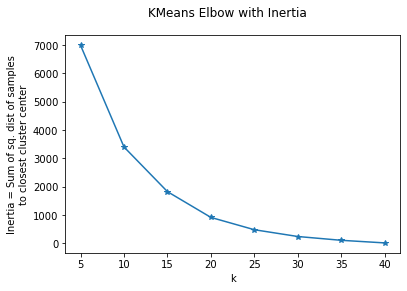

In [50]:
embed_clusters = clustering_embeddings(X_train, net2)

In [51]:
# set K equal to point where elbow curves starts degrading at a linear rate
K = 15
clusters = embed_clusters[K]

# Visualizing Embedding Clusters
Look at the latent representation of all IPs in each cluster. A heatmap gives a quick idea of the relative magnitude of the latent values. We can re-use the heatmap later for examining feature attribution values.

In [52]:

# https://matplotlib.org/3.5.0/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", fontsize=None, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=fontsize)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels, fontsize=fontsize)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels, fontsize=fontsize)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def visualize_heatmap(data, row_labels, col_labels, legend=None, cmap="YlGn", figsize=None, fontsize=None):
    fig, ax = plt.subplots(figsize=figsize)

    im, cbar = heatmap(data, row_labels, col_labels, ax=ax,
                       cmap=cmap, cbarlabel=legend, fontsize=fontsize)
    texts = annotate_heatmap(im, valfmt="{x:.2f}")

    fig.tight_layout()
    plt.show()

(2, 39) (2, 4)


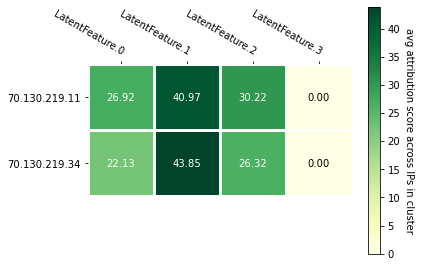

(6, 39) (6, 4)


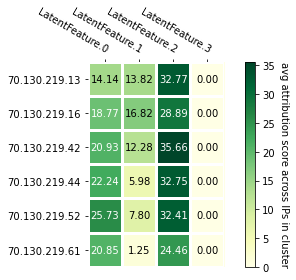

(6, 39) (6, 4)


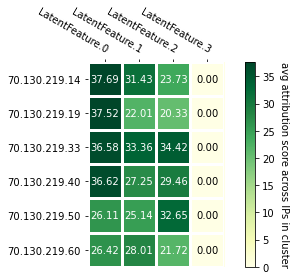

(4, 39) (4, 4)


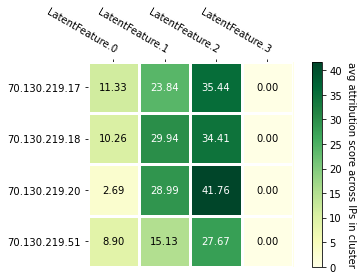

(2, 39) (2, 4)


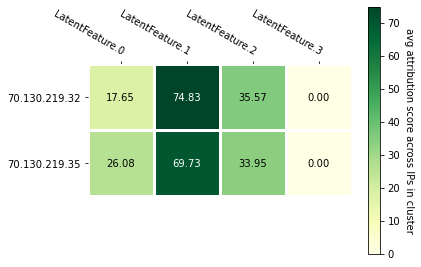

(1, 39) (1, 4)


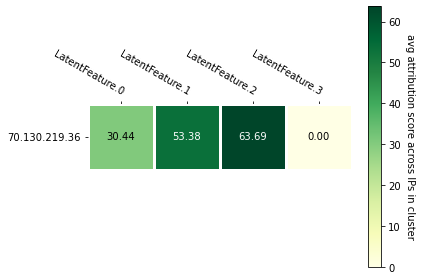

(1, 39) (1, 4)


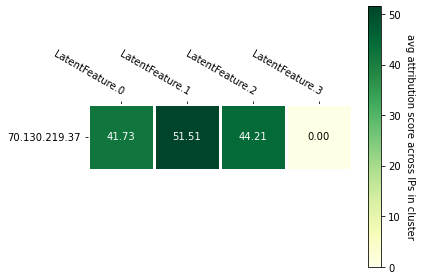

(2, 39) (2, 4)


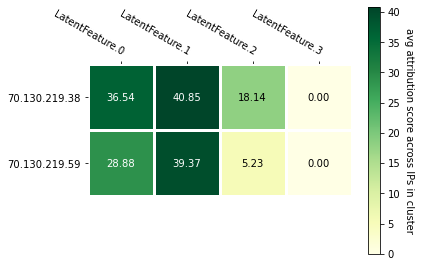

(2, 39) (2, 4)


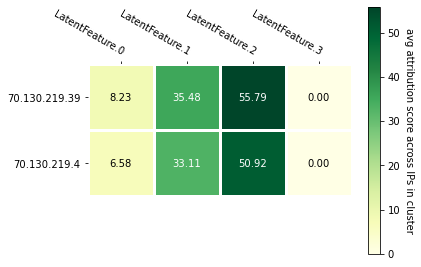

(1, 39) (1, 4)


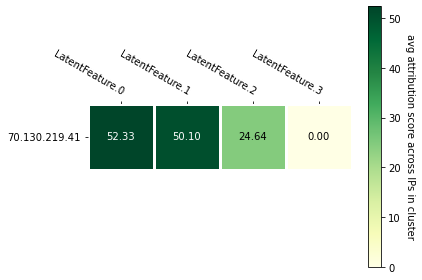

(3, 39) (3, 4)


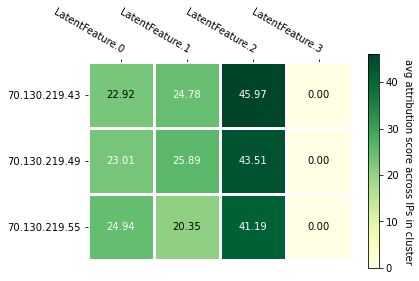

(6, 39) (6, 4)


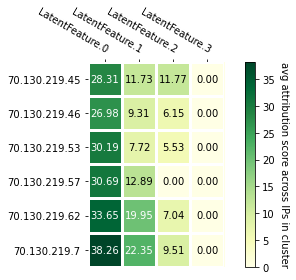

(1, 39) (1, 4)


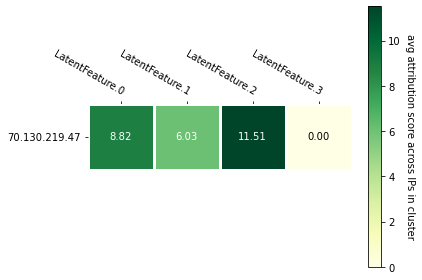

(3, 39) (3, 4)


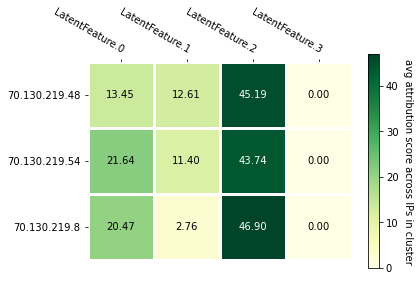

(3, 39) (3, 4)


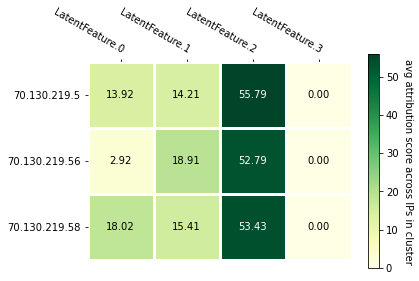

In [53]:
for cid in clusters:
    raw_ips, embed_ips = clusters[cid]
    print(raw_ips.shape, embed_ips.shape)
    
    # DONE: DataEncoder, method for inverse_transform, e.g. encoder.decode(raw_ips) to get real ips
    raw_ip_df = pd.DataFrame(raw_ips, columns=df.columns)
    encoder.decode_dataframe(raw_ip_df)
    ip_addresses = raw_ip_df["host_identifier.ipv4"]
    
    latent_features = [f"LatentFeature.{i}" for i in range(embed_ips.shape[1])] #TODO: DataEncoder, method for inverse_transform, e.g. encoder.decode(raw_ips) to get real ips
    visualize_heatmap(data=embed_ips, row_labels=ip_addresses, col_labels=latent_features, legend="avg attribution score across IPs in cluster")

## Captum: Feature Importance

Leverage [Captum](https://captum.ai) library for determining feature importance. Specifically, we will look at the [NeuronGradient](https://captum.ai/api/neuron.html#neuron-gradient) attribution values. Then, we can look for patterns for "important" features at various levels: all clusters, individual clusters, individual IPs, etc

In [54]:
def compute_attr(cluster, net):
    
    X = torch.from_numpy(cluster).type(torch.FloatTensor)
    attr_method = NeuronGradient(net, layer=net.encoder[-2]) #-1 is activation layer
    
    attr_list = []
    for i in range(net.encoder[-2].out_features):
        attr = attr_method.attribute(X, neuron_selector=(i,)).numpy()
        attr_list.append(attr.reshape((-1, attr.shape[-1], 1)))
    
    return np.concatenate(attr_list, axis=-1)

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def boxplot_cluster_attr(cluster_attr):

    plt.figure(figsize=(5, 50))
    plt.suptitle("")
    plt.boxplot(cluster_attr.transpose(), vert=False)
    plt.xlabel("attribution scores")
    plt.yticks(ticks=np.arange(attr.shape[1]), labels=list(df.columns))
    plt.show()

Given an IP, NeuronGradient measures the gradient of each latent variable w.r.t the IP features. For example, if the latent dimension was 4 and each IP had 40 features, then and a cluster with 10 IPs would have a total of `40x10x4=1600` total feature attribution values.

We can aggregate the values by averaging across the last two dimensions to get three different views for a **single cluster**:
- num_features x (num_IPs x 4 latent dims) #all attributions
- num_features x num_IPs # average across latent dims for each IP
- num_features x 1 (a single cluster) # average across IPs in a cluster

We can re-use the heatmap visualization from previous sections to study the feature attributions at these three levels.

In [55]:
def aggregate_cluster_attr(clusters, filter_latent_variables=False, net=None):
    
    if net is None:
        raise ValueError("missing param `net`")
    
    # single cluster case
    if isinstance(clusters, tuple):
        clusters = {"single_cluster" : clusters}
    
    avg_attr_list = []
    for clust in clusters.values():
        raw_ips, embed_ips = clust
        all_attr = normalize(compute_attr(cluster=raw_ips, net=net))

        # only filter latent_variables when looking at a single cluster
        # cannot filter when looking at all clusters 
        # since clusters will have different filters (not apples to apples)
        if filter_latent_variables:
            non_zero_latent_dims = np.argwhere(np.any(embed_ips[..., :] != 0, axis=0)).squeeze()
            attr = all_attr[:, :, non_zero_latent_dims]
        else:
            attr = all_attr

        avg_across_latent_dims = np.mean(attr, axis=-1) #avg latent dims first?

        if raw_ips.shape[0] > 1:
            # avg across IPs second?
            avg_across_IPs = np.mean(avg_across_latent_dims.squeeze(), axis=0).reshape(1, -1)
            avg_attr_list.append(avg_across_IPs)
        else:
            # only 1 IP in cluster
            avg_attr_list.append(avg_across_latent_dims)
            
    avg_attr = np.concatenate(avg_attr_list, axis=0)
    return avg_attr

def visualize_attr_single_cluster(clusters, index, net, raw_feature_names, filter_latent_variables):
    
    # look at all attributions (dim=latent dim)
    # row = raw features
    # col = ip's
    raw_ips, embed_ips = clusters[index]
    all_attr = normalize(compute_attr(cluster=raw_ips, net=net))
    
    # optionally filter out latent variables
    if filter_latent_variables:
        non_zero_latent_dims = np.argwhere(np.any(embed_ips[..., :] != 0, axis=0)).squeeze()
        all_attr = all_attr[:, :, non_zero_latent_dims]
    
    ## get axis label info
    # get ipv4
    raw_ip_df = pd.DataFrame(raw_ips, columns=raw_feature_names)
    encoder.decode_dataframe(raw_ip_df)
    ip_addresses = raw_ip_df["host_identifier.ipv4"]
    
    # get wide ipv4 labels
    wide_ip_addresses = []
    for ip in ip_addresses:
        for i in range(all_attr.shape[-1]):
            wide_ip_addresses.append(f"{ip}.lv.{i+1}")
    
    ## wide method
    # each ip gets (num_latent_features) columns
    all_attr_wide = np.swapaxes(all_attr, 0, 1) # n_ip, n_raw, n_latent -> n_raw, n_ip, n_latent
    n_raw, n_ip, n_latent = all_attr_wide.shape
    all_attr_wide = all_attr_wide.reshape((n_raw, n_ip*n_latent), order="C")
    visualize_heatmap(
        data=all_attr_wide,
        row_labels=raw_feature_names,
        col_labels=wide_ip_addresses,
        legend="avg attribution score across IPs in cluster",
        figsize=(15, 100),
        fontsize=10
    )
    
    
    ## aggregation method
    all_attr = np.mean(all_attr, axis=-1).squeeze() # average across latent dims
    visualize_heatmap(
        data=all_attr.transpose(),
        row_labels=raw_feature_names,
        col_labels=ip_addresses,
        legend="avg attribution score across IPs in cluster",
        figsize=(10, 20),
        fontsize=10
    )
    
    # average across non-zero latent_variables
    avg_attr = aggregate_cluster_attr(clusters[index], filter_latent_variables=filter_latent_variables, net=net)
    visualize_heatmap(
        data=avg_attr.transpose(),
        row_labels=raw_feature_names,
        col_labels=["average attributions"],
        legend="avg attribution score across IPs in cluster",
        figsize=(10, 20),
        fontsize=10
    )

/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


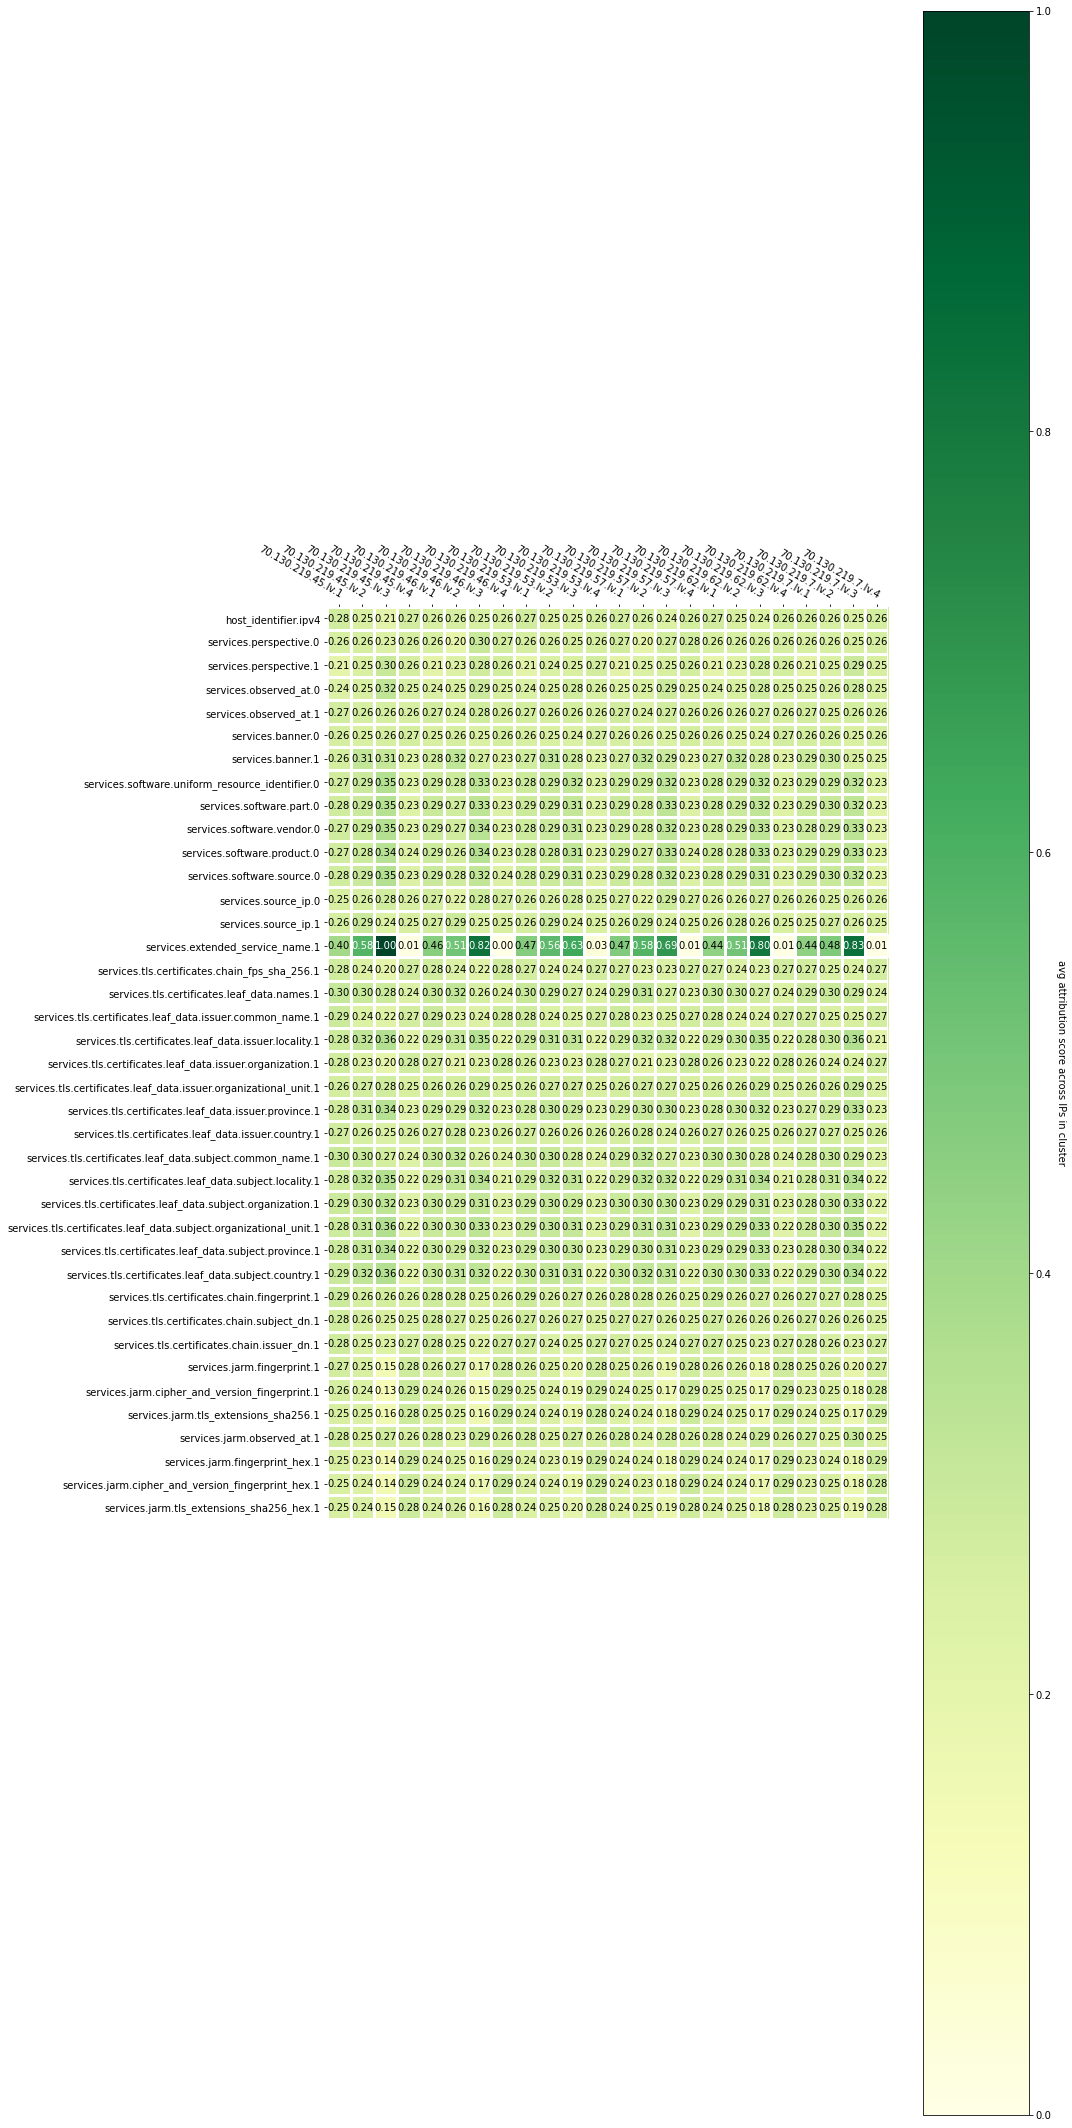

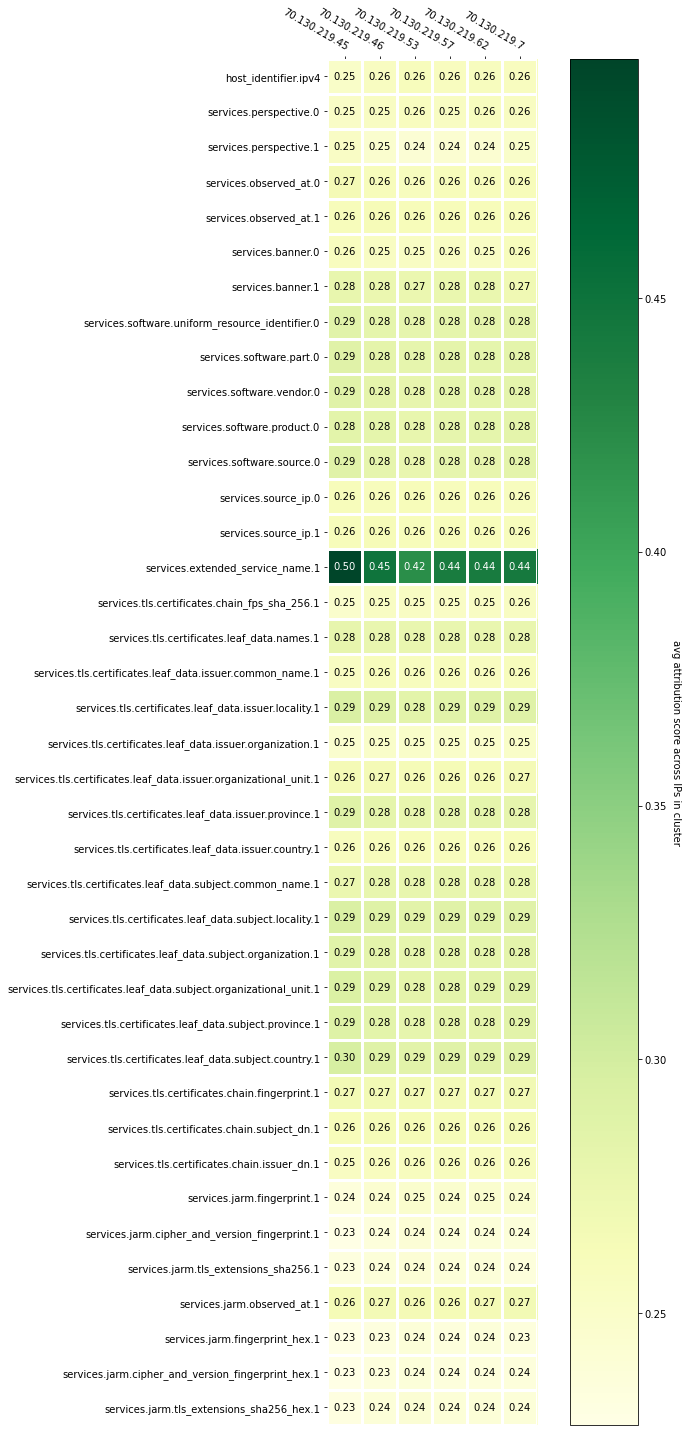

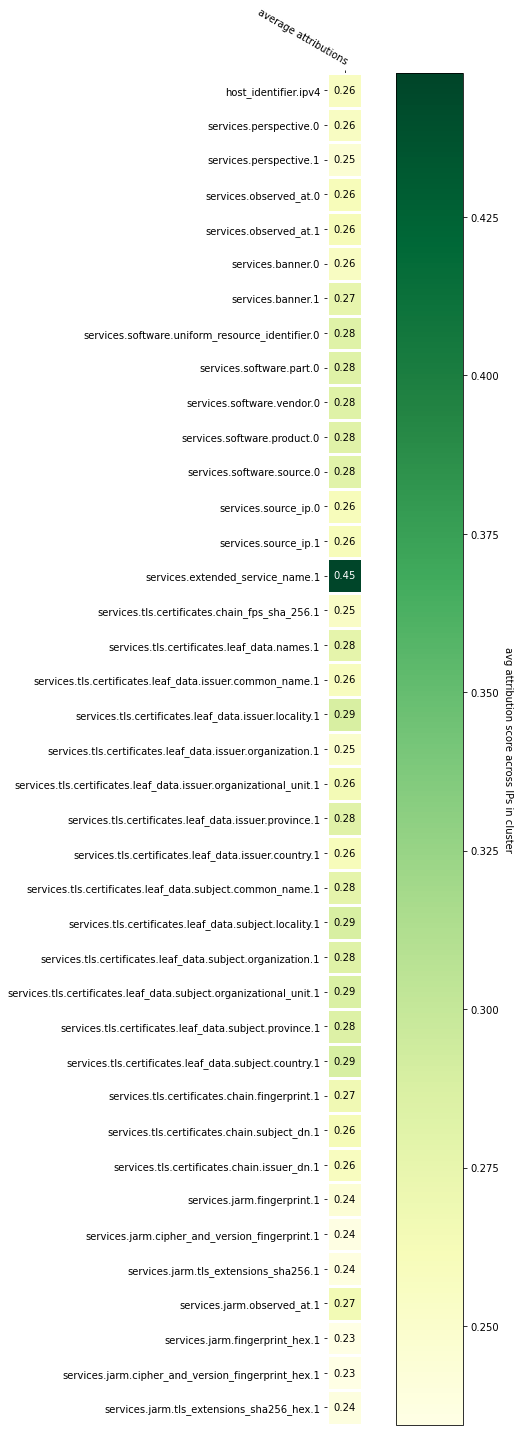

In [56]:
visualize_attr_single_cluster(clusters, index=0, net=net2, raw_feature_names=df.columns, filter_latent_variables=False)

Finally, we can look at attributions for all clusters together in one heatmap by averaging attributions across the latent dimensions and IP addresses. The birds-eye-view heatmap has:  
- rows = features
- columns = avg. attributions for each cluster

In [57]:
def visualize_attr_all_clusters(clusters, net, raw_feature_names):
    
    avg_attr = aggregate_cluster_attr(clusters, filter_latent_variables=False, net=net)
    
    cluster_names = [f"C-{i+1}" for i in range(len(clusters))]
    visualize_heatmap(
        data=avg_attr.transpose(),
        row_labels=raw_feature_names,
        col_labels=cluster_names,
        legend="avg attribution score across IPs in cluster",
        figsize=(15, 100),
        fontsize=15
    )

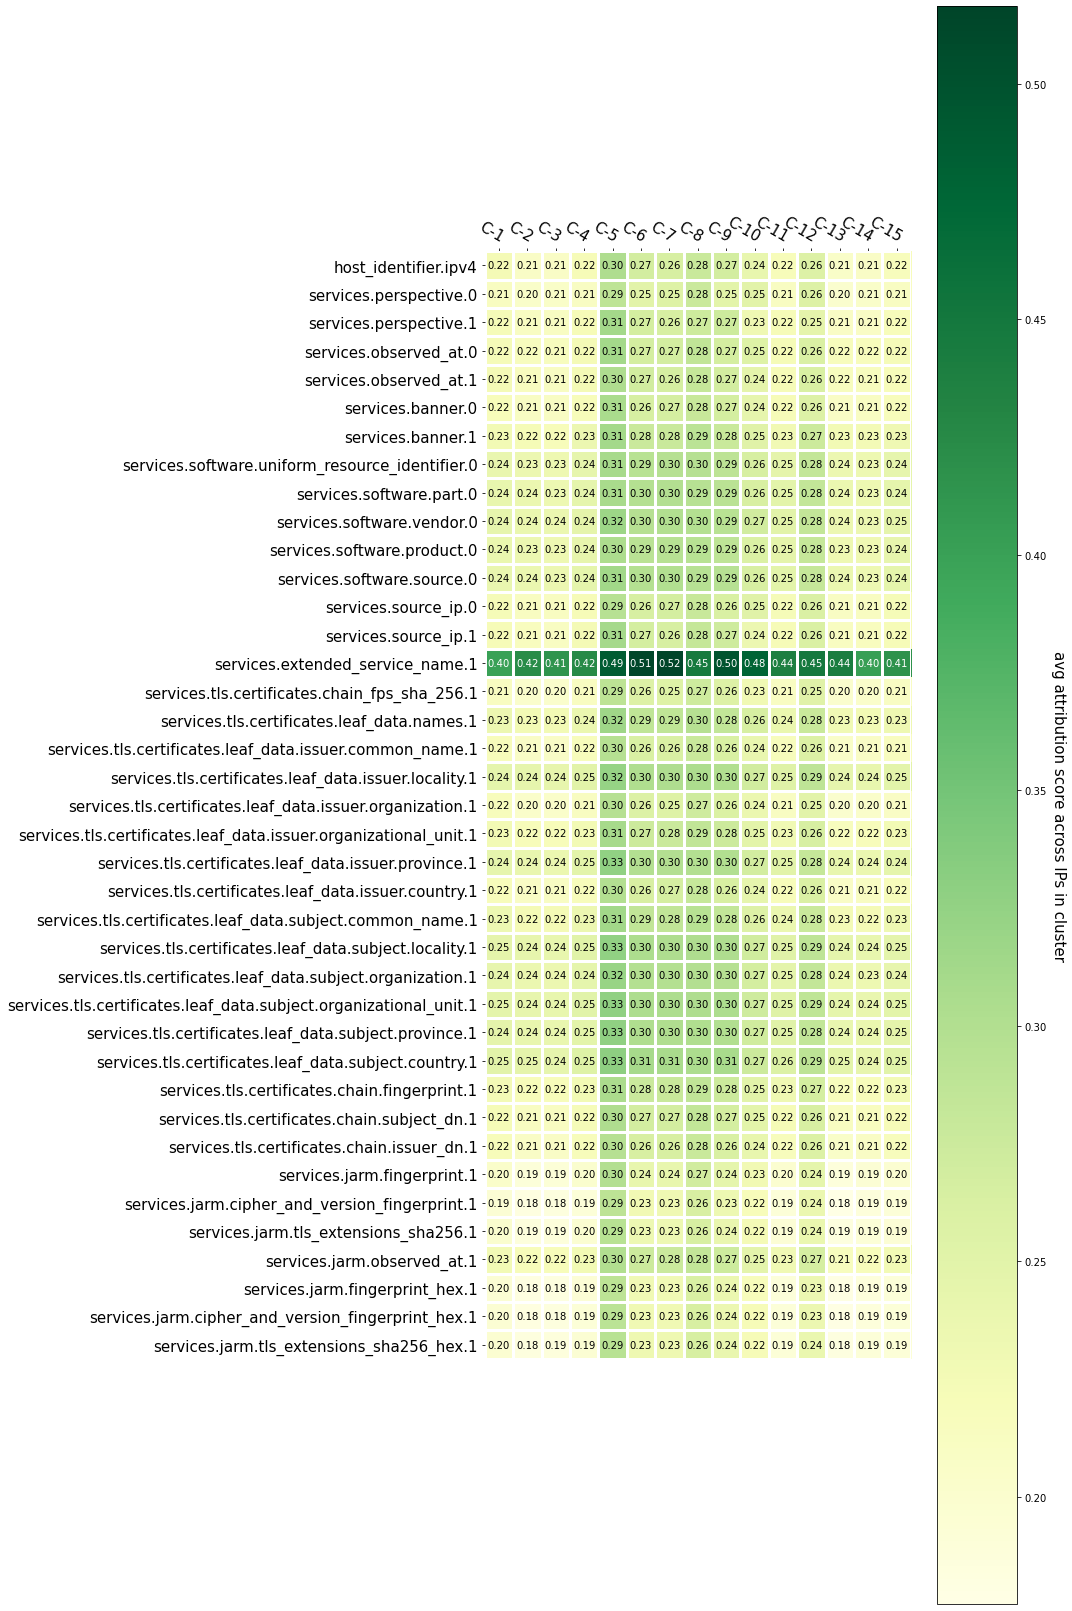

In [58]:
visualize_attr_all_clusters(clusters, net=net2, raw_feature_names=df.columns)

**NOTE**: Due to a failure to save the original autoencoder (AE) model weights, the weights for the AE shown in the presentation slides was lost. Only, **similar** weights were saved (the AE was trained for more epochs with different hyperparameters).

Attempts to replicate the original AE training were unsuccessful, likely due to different pseudo-random initializations of the AE weights and using different data encoding schemes.

For these reasons, the **feature importance heatmaps** will have slightly different values than those shown in the project presentation. However, since the weights were not changed too much, **the overall trends/findings remain the same**. Those trends will be covered starting in the text cell

---

**ORIGINAL OBSERVATIONS** (as presented in class and as shown if `DEMO=True`)  

**Observation 1**: AE learns that *extended_feature_name* is important for representing IPs in a lower dimensional space. More on this in the following cells.  
**Observation 2**: We can group clusters into two groups: (1) those that consider many features to be important (columns of darker green) and (2) those that consider a few important features (columns of lighter green). Looking at the IPs in the first category, we notice that they are IPs with the extra TLS/JARM features. This is evidence that the AE is learning broad patterns in this prefix.

---
Here is the original attribution heatmap:
![alt text](plots/original_embedding_attributions.png "Title")

So far, we know which features are important for specific clusters, but we don't know what those features look like. The next few cells show the actual values for the  **top k** important features for each cluster.

In [59]:
def view_raw_features(clusters, index, features_list, raw_feature_names):
    if isinstance(features_list, str):
        features_list = [features_list]
    raw_ips, _ = clusters[index]
    raw_ip_df = pd.DataFrame(raw_ips, columns=raw_feature_names)
    encoder.decode_dataframe(raw_ip_df)
    
    print("cluster", index)
    display(raw_ip_df[["host_identifier.ipv4"]+features_list])

def view_topk_raw_features(clusters, index, raw_feature_names, net, k=5):
    avg_attr = aggregate_cluster_attr(clusters[index], filter_latent_variables=False, net=net).flatten()
    feature_list = list(raw_feature_names[np.argsort(-avg_attr)[:k]])
    view_raw_features(clusters, index, feature_list, raw_feature_names)

In [60]:
topk = None
for i in range(len(clusters)):
    view_topk_raw_features(clusters, i, raw_feature_names=df.columns, k=topk, net=net2)

cluster 0


host_identifier.ipv4 services.extended_service_name.1  \
0        70.130.219.45                             HTTP   
1        70.130.219.46                             HTTP   
2        70.130.219.53                             HTTP   
3        70.130.219.57                             HTTP   
4        70.130.219.62                             HTTP   
5         70.130.219.7                             HTTP   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                nan      
1                                                nan      
2                                                nan      
3                                                nan      
4                                                nan      
5                                                nan      

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                                nan       
1                                                nan       
2                                                nan       
3                                                nan       
4                                                nan       
5                                                nan       

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                nan      
1                                                nan      
2                                                nan      
3                                                nan      
4                                                nan      
5                                                nan      

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                                nan                  
1                                                nan                  
2                                                nan                  
3                                                nan                  
4                                                nan                  
5                                                nan                  

  services.tls.certificates.leaf_data.subject.province.1  \
0                                                nan       
1                                                nan       
2                                                nan       
3                                                nan       
4                                                nan       
5                                                nan       

  services.software.vendor.0 services.software.part.0  \
0                        nan                      nan   
1                        nan                      nan   
2                        nan                      nan   
3                        nan                      nan   
4                        nan                      nan   
5                        nan                      nan   

  services.software.uniform_resource_identifier.0  ... services.perspective.0  \
0                                             nan  ...                   TATA   
1                                             nan  ...                     HE   
2                                             nan  ...                   TATA   
3                                             nan  ...                     HE   
4                                             nan  ...                   TATA   
5                                             nan  ...                     HE   

  services.tls.certificates.chain_fps_sha_256.1  \
0                                           nan   
1                                           nan   
2                                           nan   
3                                           nan   
4                                           nan   
5                                           nan   

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                              

cluster 1


/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


host_identifier.ipv4 services.extended_service_name.1  \
0        70.130.219.39                            HTTPS   
1         70.130.219.4                             HTTP   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                nan      
1                                                nan      

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                                nan                  
1                                                nan                  

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                                nan       
1                                                nan       

  services.tls.certificates.leaf_data.subject.province.1  \
0                                                nan       
1                                                nan       

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                nan      
1                                                nan      

  services.tls.certificates.leaf_data.issuer.province.1  \
0                                                nan      
1                                                nan      

  services.tls.certificates.leaf_data.subject.organization.1  \
0                                                nan           
1                                                nan           

  services.software.source.0  ... services.source_ip.0  \
0                        nan  ...       167.248.133.63   
1                        nan  ...       167.94.138.120   

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                       TrustAsia Technologies, Inc.          
1                                                nan          

  services.tls.certificates.chain_fps_sha_256.1 services.perspective.0  \
0  efH1q2l96/GV9bfaZflTmWgu2uuAEVudQqauXi+piAI=                    NTT   
1                                           nan                   TATA   

                    services.jarm.fingerprint.1  \
0  KdKdAAKdKdIcKdKdKdKda/n+UFEBBC1boeLPB2sVxQ==   
1                                           nan   

  services.jarm.tls_extensions_sha256.1  \
0              a/n+UFEBBC1boeLPB2sVxQ==   
1                                   nan   

  services.jarm.tls_extensions_sha256_hex.1  \
0          6bf9fe505101042d5ba1e2cf076b15c5   
1                                       nan   

                     services.jarm.fingerprint_hex.1  \
0  29d29d00029d29d21c29d29d29d29d6bf9fe505101042d...   
1                                                nan   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                     29d29d00029d29d21c29d29d29d29d   
1                                                nan   

  services.jarm.cipher_and_version_fingerprint.1  
0                           KdKdAAKdKdIcKdKdKdKd  
1                                            nan  

[2 rows x 40 columns]

cluster 2


/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


host_identifier.ipv4 services.extended_service_name.1  \
0        70.130.219.14                             HTTP   
1        70.130.219.19                             HTTP   
2        70.130.219.33                            HTTPS   
3        70.130.219.40                             HTTP   
4        70.130.219.50                             HTTP   
5        70.130.219.60                             HTTP   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                nan      
1                                                nan      
2                                                nan      
3                                                nan      
4                                                nan      
5                                                nan      

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                nan      
1                                                nan      
2                                                nan      
3                                                nan      
4                                                nan      
5                                                nan      

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                                nan                  
1                                                nan                  
2                                                nan                  
3                                                nan                  
4                                                nan                  
5                                                nan                  

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                                nan       
1                                                nan       
2                                                nan       
3                                                nan       
4                                                nan       
5                                                nan       

  services.tls.certificates.leaf_data.subject.province.1  \
0                                                nan       
1                                                nan       
2                                                nan       
3                                                nan       
4                                                nan       
5                                                nan       

  services.tls.certificates.leaf_data.issuer.province.1  \
0                                                nan      
1                                                nan      
2                                                nan      
3                                                nan      
4                                                nan      
5                                                nan      

  services.software.vendor.0  \
0                        nan   
1                        nan   
2                        nan   
3                        nan   
4                        nan   
5                        nan   

  services.tls.certificates.leaf_data.subject.organization.1  ...  \
0                                                nan          ...   
1                                                nan          ...   
2                                                nan          ...   
3                                                nan          ...   
4                                                nan          ...   
5                                                nan          ...   

  services.tls.certificates.chain.issuer_dn.1 services.perspective.0  \
0                                         nan                   TATA   
1                                         nan                    NTT   
2         C=US, O=Amazon, CN=Amazon Root CA 1                    NTT   
3        

cluster 3


/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


host_identifier.ipv4 services.extended_service_name.1  \
0        70.130.219.17                             HTTP   
1        70.130.219.18                             HTTP   
2        70.130.219.20                             HTTP   
3        70.130.219.51                             HTTP   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                nan      
1                                                nan      
2                                                nan      
3                                                nan      

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                                nan       
1                                                nan       
2                                                nan       
3                                                nan       

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                                nan                  
1                                                nan                  
2                                                nan                  
3                                                nan                  

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                nan      
1                                                nan      
2                                                nan      
3                                                nan      

  services.tls.certificates.leaf_data.subject.province.1  \
0                                                nan       
1                                                nan       
2                                                nan       
3                                                nan       

  services.tls.certificates.leaf_data.issuer.province.1  \
0                                                nan      
1                                                nan      
2                                                nan      
3                                                nan      

  services.software.vendor.0 services.software.source.0  ...  \
0                        nan                        nan  ...   
1                        nan                        nan  ...   
2                        nan                        nan  ...   
3                        nan                        nan  ...   

  services.tls.certificates.leaf_data.issuer.common_name.1  \
0                                                nan         
1                                                nan         
2                                                nan         
3                                                nan         

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                                                nan          
1                                                nan          
2                                                nan          
3                                                nan          

  services.tls.certificates.chain_fps_sha_256.1 services.perspective.0  \
0                                           nan                    NTT   
1                                           nan                    NTT   
2                                           nan                     HE   
3                                           nan                  TELIA   

  services.jarm.fingerprint.1 services.jarm.tls_extensions_sha256.1  \
0                         nan                                   nan   
1                         nan                                   nan   
2                         nan                                   nan   
3                         nan                                   nan   

  services.jarm.tls_extensions_sha256_hex.1 services.jarm.fingerprint_hex.1  \
0                                       nan                             nan   
1                          

cluster 4


/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


host_identifier.ipv4 services.extended_service_name.1  \
0        70.130.219.32                            HTTPS   
1        70.130.219.35                            HTTPS   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                 US      
1                                                nan      

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                         CloudFront                  
1                                                nan                  

  services.tls.certificates.leaf_data.subject.province.1  \
0                                         Washington       
1                                                nan       

  services.tls.certificates.leaf_data.issuer.province.1  \
0                                         Washington      
1                                                nan      

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                            Seattle       
1                                                nan       

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                            Seattle      
1                                                nan      

  services.tls.certificates.leaf_data.subject.organization.1  \
0                                        Amazon Inc.           
1                                                nan           

  services.software.vendor.0  ...  \
0                        nan  ...   
1                        nan  ...   

         services.tls.certificates.chain.issuer_dn.1  \
0  C=US, ST=Washington, L=Seattle, O=Amazon Inc.,...   
1                C=US, O=Amazon, CN=Amazon Root CA 1   

  services.tls.certificates.leaf_data.issuer.common_name.1  \
0                   distribution.cloudfront-test.net         
1                                             Amazon         

  services.source_ip.0 services.jarm.tls_extensions_sha256.1  \
0      162.142.125.212              a/n+UFEBBC1boeLPB2sVxQ==   
1       162.142.125.10                                   nan   

  services.jarm.tls_extensions_sha256_hex.1  \
0          6bf9fe505101042d5ba1e2cf076b15c5   
1                                       nan   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                     29d29d00029d29d21c29d29d29d29d   
1                                                nan   

  services.jarm.cipher_and_version_fingerprint.1  \
0                           KdKdAAKdKdIcKdKdKdKd   
1                                            nan   

                     services.jarm.fingerprint_hex.1  \
0  29d29d00029d29d21c29d29d29d29d6bf9fe505101042d...   
1                                                nan   

  services.tls.certificates.chain_fps_sha_256.1 services.perspective.0  
0  k8SeCZ4/QNmQmg2yOpvm1jmoMj3QhpsredgDJljZhhU=                     HE  
1  9V+f/Lg8c0UyYWAcfgRNsVoPA0uTwFgw8oY174ic9nA=                     HE  

[2 rows x 40 columns]

cluster 5


/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


host_identifier.ipv4 services.extended_service_name.1  \
0        70.130.219.43                             HTTP   
1        70.130.219.49                             HTTP   
2        70.130.219.55                             HTTP   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                nan      
1                                                nan      
2                                                nan      

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                                nan                  
1                                                nan                  
2                                                nan                  

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                nan      
1                                                nan      
2                                                nan      

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                                nan       
1                                                nan       
2                                                nan       

  services.tls.certificates.leaf_data.subject.province.1  \
0                                                nan       
1                                                nan       
2                                                nan       

  services.software.vendor.0  \
0                        nan   
1                        nan   
2                        nan   

  services.tls.certificates.leaf_data.issuer.province.1  \
0                                                nan      
1                                                nan      
2                                                nan      

  services.software.source.0  ...  \
0                        nan  ...   
1                        nan  ...   
2                        nan  ...   

  services.tls.certificates.leaf_data.issuer.common_name.1  \
0                                                nan         
1                                                nan         
2                                                nan         

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                                                nan          
1                                                nan          
2                                                nan          

  services.perspective.0 services.tls.certificates.chain_fps_sha_256.1  \
0                    NTT                                           nan   
1                     HE                                           nan   
2                     HE                                           nan   

  services.jarm.fingerprint.1 services.jarm.tls_extensions_sha256.1  \
0                         nan                                   nan   
1                         nan                                   nan   
2                         nan                                   nan   

  services.jarm.tls_extensions_sha256_hex.1  \
0                                       nan   
1                                       nan   
2                                       nan   

  services.jarm.cipher_and_version_fingerprint.1  \
0                                            nan   
1                                            nan   
2                                            nan   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                                                nan   
1                                                nan   
2                                                nan   

  services.jarm.fingerprint_hex.1  
0                             nan  
1                             nan  
2                             nan  

[3 rows x 40 columns]

/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


cluster 6


host_identifier.ipv4 services.extended_service_name.1  \
0        70.130.219.11                             HTTP   
1        70.130.219.34                            HTTPS   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                nan      
1                                                 US      

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                                nan                  
1                                         CloudFront                  

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                                nan       
1                                            Seattle       

  services.tls.certificates.leaf_data.subject.province.1  \
0                                                nan       
1                                         Washington       

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                nan      
1                                            Seattle      

  services.tls.certificates.leaf_data.issuer.province.1  \
0                                                nan      
1                                         Washington      

  services.software.vendor.0  \
0                        nan   
1                        nan   

  services.tls.certificates.leaf_data.subject.organization.1  ...  \
0                                                nan          ...   
1                                        Amazon Inc.          ...   

  services.tls.certificates.leaf_data.issuer.common_name.1  \
0                                                nan         
1                   distribution.cloudfront-test.net         

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                                                nan          
1                                        Amazon Inc.          

  services.tls.certificates.chain_fps_sha_256.1 services.perspective.0  \
0                                           nan                     HE   
1  k8SeCZ4/QNmQmg2yOpvm1jmoMj3QhpsredgDJljZhhU=                 ORANGE   

                    services.jarm.fingerprint.1  \
0                                           nan   
1  KdKdAAKdKdIcKdKdKdKda/n+UFEBBC1boeLPB2sVxQ==   

  services.jarm.tls_extensions_sha256.1  \
0                                   nan   
1              a/n+UFEBBC1boeLPB2sVxQ==   

  services.jarm.tls_extensions_sha256_hex.1  \
0                                       nan   
1          6bf9fe505101042d5ba1e2cf076b15c5   

                     services.jarm.fingerprint_hex.1  \
0                                                nan   
1  29d29d00029d29d21c29d29d29d29d6bf9fe505101042d...   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                                                nan   
1                     29d29d00029d29d21c29d29d29d29d   

  services.jarm.cipher_and_version_fingerprint.1  
0                                            nan  
1                           KdKdAAKdKdIcKdKdKdKd  

[2 rows x 40 columns]

cluster 7


/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


host_identifier.ipv4 services.extended_service_name.1  \
0        70.130.219.48                             HTTP   
1        70.130.219.54                             HTTP   
2         70.130.219.8                             HTTP   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                nan      
1                                                nan      
2                                                nan      

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                nan      
1                                                nan      
2                                                nan      

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                                nan       
1                                                nan       
2                                                nan       

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                                nan                  
1                                                nan                  
2                                                nan                  

  services.tls.certificates.leaf_data.subject.province.1  \
0                                                nan       
1                                                nan       
2                                                nan       

  services.tls.certificates.leaf_data.issuer.province.1  \
0                                                nan      
1                                                nan      
2                                                nan      

  services.software.vendor.0 services.software.source.0  ...  \
0                        nan                        nan  ...   
1                        nan                        nan  ...   
2                        nan                        nan  ...   

  host_identifier.ipv4 services.perspective.0  \
0        70.130.219.48                   TATA   
1        70.130.219.54                     HE   
2         70.130.219.8                     HE   

  services.tls.certificates.chain_fps_sha_256.1  \
0                                           nan   
1                                           nan   
2                                           nan   

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                                                nan          
1                                                nan          
2                                                nan          

  services.jarm.fingerprint.1 services.jarm.tls_extensions_sha256.1  \
0                         nan                                   nan   
1                         nan                                   nan   
2                         nan                                   nan   

  services.jarm.tls_extensions_sha256_hex.1  \
0                                       nan   
1                                       nan   
2                                       nan   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                                                nan   
1                                                nan   
2                                                nan   

  services.jarm.fingerprint_hex.1  \
0                             nan   
1                             nan   
2                             nan   

  services.jarm.cipher_and_version_fingerprint.1  
0                                            nan  
1                                            nan  
2                                            nan  

[3 rows x 40 columns]

cluster 8


/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


host_identifier.ipv4 services.extended_service_name.1  \
0        70.130.219.36                            HTTPS   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                nan      

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                                nan                  

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                                nan       

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                nan      

  services.tls.certificates.leaf_data.subject.province.1  \
0                                                nan       

  services.tls.certificates.leaf_data.issuer.province.1  \
0                                                nan      

  services.tls.certificates.leaf_data.subject.organization.1  \
0                                                nan           

  services.software.source.0  ...  \
0                        nan  ...   

  services.tls.certificates.leaf_data.issuer.common_name.1  \
0                                             Amazon         

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                                             Amazon          

  services.tls.certificates.chain_fps_sha_256.1 services.perspective.0  \
0  9V+f/Lg8c0UyYWAcfgRNsVoPA0uTwFgw8oY174ic9nA=                    NTT   

                    services.jarm.fingerprint.1  \
0  KdKdAAKdKdIcKdKdKdKda/n+UFEBBC1boeLPB2sVxQ==   

  services.jarm.tls_extensions_sha256.1  \
0              a/n+UFEBBC1boeLPB2sVxQ==   

  services.jarm.tls_extensions_sha256_hex.1  \
0          6bf9fe505101042d5ba1e2cf076b15c5   

                     services.jarm.fingerprint_hex.1  \
0  29d29d00029d29d21c29d29d29d29d6bf9fe505101042d...   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                     29d29d00029d29d21c29d29d29d29d   

  services.jarm.cipher_and_version_fingerprint.1  
0                           KdKdAAKdKdIcKdKdKdKd  

[1 rows x 40 columns]

/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


cluster 9


host_identifier.ipv4 services.extended_service_name.1  \
0        70.130.219.41                            HTTPS   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                nan      

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                                nan                  

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                                nan       

  services.tls.certificates.leaf_data.subject.province.1  \
0                                                nan       

  services.software.vendor.0  \
0                        nan   

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                nan      

  services.tls.certificates.leaf_data.issuer.province.1  \
0                                                nan      

  services.tls.certificates.leaf_data.subject.organization.1  ...  \
0                                                nan          ...   

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                                       DigiCert Inc          

  services.source_ip.1 services.perspective.1  \
0      167.248.133.120                    NTT   

  services.tls.certificates.chain_fps_sha_256.1  \
0  j6xXZDnJ/T7xU7Ufnt0NOBtd97h1Wc6+ygQpfdRKY5s=   

                    services.jarm.fingerprint.1  \
0  KdKdAAKdKdIcKdKdKdKda/n+UFEBBC1boeLPB2sVxQ==   

  services.jarm.tls_extensions_sha256.1  \
0              a/n+UFEBBC1boeLPB2sVxQ==   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                     29d29d00029d29d21c29d29d29d29d   

  services.jarm.tls_extensions_sha256_hex.1  \
0          6bf9fe505101042d5ba1e2cf076b15c5   

  services.jarm.cipher_and_version_fingerprint.1  \
0                           KdKdAAKdKdIcKdKdKdKd   

                     services.jarm.fingerprint_hex.1  
0  29d29d00029d29d21c29d29d29d29d6bf9fe505101042d...  

[1 rows x 40 columns]

/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


cluster 10


host_identifier.ipv4 services.extended_service_name.1  \
0        70.130.219.38                            HTTPS   
1        70.130.219.59                             HTTP   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                nan      
1                                                nan      

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                nan      
1                                                nan      

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                                nan       
1                                                nan       

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                                nan                  
1                                                nan                  

  services.tls.certificates.leaf_data.subject.province.1  \
0                                                nan       
1                                                nan       

  services.tls.certificates.leaf_data.subject.organization.1  \
0                                                nan           
1                                                nan           

  services.tls.certificates.leaf_data.issuer.province.1  \
0                                                nan      
1                                                nan      

  services.software.vendor.0  ... services.perspective.0  \
0                        nan  ...                   TATA   
1                        nan  ...                     HE   

  services.perspective.1 services.tls.certificates.chain_fps_sha_256.1  \
0                   TATA  9V+f/Lg8c0UyYWAcfgRNsVoPA0uTwFgw8oY174ic9nA=   
1                   TATA                                           nan   

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                                             Amazon          
1                                                nan          

                    services.jarm.fingerprint.1  \
0  KdKdAAKdKdIcKdKdKdKda/n+UFEBBC1boeLPB2sVxQ==   
1                                           nan   

  services.jarm.tls_extensions_sha256.1  \
0              a/n+UFEBBC1boeLPB2sVxQ==   
1                                   nan   

  services.jarm.tls_extensions_sha256_hex.1  \
0          6bf9fe505101042d5ba1e2cf076b15c5   
1                                       nan   

  services.jarm.cipher_and_version_fingerprint.1  \
0                           KdKdAAKdKdIcKdKdKdKd   
1                                            nan   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                     29d29d00029d29d21c29d29d29d29d   
1                                                nan   

                     services.jarm.fingerprint_hex.1  
0  29d29d00029d29d21c29d29d29d29d6bf9fe505101042d...  
1                                                nan  

[2 rows x 40 columns]

/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


cluster 11


host_identifier.ipv4 services.extended_service_name.1  \
0        70.130.219.37                            HTTPS   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                nan      

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                                nan                  

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                                nan       

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                nan      

  services.tls.certificates.leaf_data.subject.province.1  \
0                                                nan       

  services.software.source.0 services.software.vendor.0  \
0                        nan                        nan   

  services.software.part.0  ...  \
0                      nan  ...   

  services.tls.certificates.leaf_data.issuer.common_name.1  \
0                                             Amazon         

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                                             Amazon          

  services.tls.certificates.chain_fps_sha_256.1 services.perspective.0  \
0  9V+f/Lg8c0UyYWAcfgRNsVoPA0uTwFgw8oY174ic9nA=                   TATA   

                    services.jarm.fingerprint.1  \
0  KdKdAAKdKdIcKdKdKdKda/n+UFEBBC1boeLPB2sVxQ==   

  services.jarm.tls_extensions_sha256.1  \
0              a/n+UFEBBC1boeLPB2sVxQ==   

  services.jarm.tls_extensions_sha256_hex.1  \
0          6bf9fe505101042d5ba1e2cf076b15c5   

  services.jarm.cipher_and_version_fingerprint.1  \
0                           KdKdAAKdKdIcKdKdKdKd   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                     29d29d00029d29d21c29d29d29d29d   

                     services.jarm.fingerprint_hex.1  
0  29d29d00029d29d21c29d29d29d29d6bf9fe505101042d...  

[1 rows x 40 columns]

cluster 12


/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


host_identifier.ipv4 services.extended_service_name.1  \
0         70.130.219.5                             HTTP   
1        70.130.219.56                             HTTP   
2        70.130.219.58                             HTTP   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                nan      
1                                                nan      
2                                                nan      

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                nan      
1                                                nan      
2                                                nan      

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                                nan                  
1                                                nan                  
2                                                nan                  

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                                nan       
1                                                nan       
2                                                nan       

  services.tls.certificates.leaf_data.subject.province.1  \
0                                                nan       
1                                                nan       
2                                                nan       

  services.software.vendor.0 services.software.source.0  \
0                        nan                        nan   
1                        nan                        nan   
2                        nan                        nan   

  services.tls.certificates.leaf_data.issuer.province.1  ...  \
0                                                nan     ...   
1                                                nan     ...   
2                                                nan     ...   

  services.tls.certificates.leaf_data.issuer.common_name.1  \
0                                                nan         
1                                                nan         
2                                                nan         

  services.perspective.0 services.tls.certificates.chain_fps_sha_256.1  \
0                  TELIA                                           nan   
1                   TATA                                           nan   
2                   TATA                                           nan   

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                                                nan          
1                                                nan          
2                                                nan          

  services.jarm.fingerprint.1 services.jarm.tls_extensions_sha256.1  \
0                         nan                                   nan   
1                         nan                                   nan   
2                         nan                                   nan   

  services.jarm.tls_extensions_sha256_hex.1  \
0                                       nan   
1                                       nan   
2                                       nan   

  services.jarm.cipher_and_version_fingerprint.1  \
0                                            nan   
1                                            nan   
2                                            nan   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                                                nan   
1                                                nan   
2                                                nan   

  services.jarm.fingerprint_hex.1  
0                             nan  
1                             nan  
2                             nan  

[3 rows x 40 columns]

cluster 13


/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


host_identifier.ipv4 services.extended_service_name.1  \
0        70.130.219.13                             HTTP   
1        70.130.219.16                             HTTP   
2        70.130.219.42                             HTTP   
3        70.130.219.44                             HTTP   
4        70.130.219.52                             HTTP   
5        70.130.219.61                             HTTP   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                nan      
1                                                nan      
2                                                nan      
3                                                nan      
4                                                nan      
5                                                nan      

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                nan      
1                                                nan      
2                                                nan      
3                                                nan      
4                                                nan      
5                                                nan      

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                                nan                  
1                                                nan                  
2                                                nan                  
3                                                nan                  
4                                                nan                  
5                                                nan                  

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                                nan       
1                                                nan       
2                                                nan       
3                                                nan       
4                                                nan       
5                                                nan       

  services.tls.certificates.leaf_data.subject.province.1  \
0                                                nan       
1                                                nan       
2                                                nan       
3                                                nan       
4                                                nan       
5                                                nan       

  services.tls.certificates.leaf_data.issuer.province.1  \
0                                                nan      
1                                                nan      
2                                                nan      
3                                                nan      
4                                                nan      
5                                                nan      

  services.software.vendor.0 services.software.source.0  ...  \
0                        nan                        nan  ...   
1                        nan                        nan  ...   
2                     Amazon      OSI_APPLICATION_LAYER  ...   
3                        nan                        nan  ...   
4                        nan                        nan  ...   
5                        nan                        nan  ...   

  services.tls.certificates.chain.issuer_dn.1 services.perspective.0  \
0                                         nan                    NTT   
1                                         nan                   TATA   
2                                         nan                   TATA   
3                                         nan                    NTT   
4                                         nan                   TATA   
5                                         nan                    NTT   

  services.tls.certificates.leaf_data.issuer.organiz

cluster 14


/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


host_identifier.ipv4 services.extended_service_name.1  \
0        70.130.219.47                             HTTP   

  services.tls.certificates.leaf_data.subject.country.1  \
0                                                nan      

  services.tls.certificates.leaf_data.subject.locality.1  \
0                                                nan       

  services.tls.certificates.leaf_data.subject.organizational_unit.1  \
0                                                nan                  

  services.tls.certificates.leaf_data.issuer.locality.1  \
0                                                nan      

  services.tls.certificates.leaf_data.issuer.province.1  \
0                                                nan      

  services.tls.certificates.leaf_data.subject.province.1  \
0                                                nan       

  services.tls.certificates.leaf_data.subject.organization.1  \
0                                                nan           

  services.software.part.0  ... host_identifier.ipv4  \
0                      nan  ...        70.130.219.47   

  services.tls.certificates.chain_fps_sha_256.1  \
0                                           nan   

  services.tls.certificates.leaf_data.issuer.organization.1  \
0                                                nan          

  services.perspective.0 services.jarm.fingerprint.1  \
0                   TATA                         nan   

  services.jarm.tls_extensions_sha256.1  \
0                                   nan   

  services.jarm.tls_extensions_sha256_hex.1 services.jarm.fingerprint_hex.1  \
0                                       nan                             nan   

  services.jarm.cipher_and_version_fingerprint_hex.1  \
0                                                nan   

  services.jarm.cipher_and_version_fingerprint.1  
0                                            nan  

[1 rows x 40 columns]

**NOTE**: Due to a failure to save the original autoencoder (AE) model weights, the weights for the AE shown in the presentation slides was lost. Only, **similar** weights were saved (the AE was trained for more epochs with different hyperparameters).

Attempts to replicate the original AE training were unsuccessful, likely due to different pseudo-random initializations of the AE weights and using different data encoding schemes.

For these reasons, the **feature importance heatmaps** will have slightly different values than those shown in the project presentation. However, since the weights were not changed too much, **the overall trends/findings remain the same**. Those trends will be covered in this notebook's text cells.

---

**ORIGINAL OBSERVATIONS** (as presented in class and as shown if `DEMO=True`)  

More on **Observation 1**: AE learns that *extended_feature_name* is a good indicator of whether an IP is sparse or not. As seen in the previous cell, the possible values for that feature are ["HTTP", or "HTTPS"]. Whenever an IP has HTTPS, it will inevitably have many of the TLS/JARM features and its vector encoding will be more dense compared to IPs with HTTP as the extended_feature_name.

We saw earlier that having or not having TLS/JARM features was an important part of Raw Feature Clustering. The AE is also able to identify this.

## Create Hilbert Map


### Tools
In a prior [paper](https://www.caida.org/catalog/papers/2014_coordinated_view_internet_events/coordinated_view_internet_events.pdf), Dr. Dainotti used [ipv4-heatmap](https://github.com/measurement-factory/ipv4-heatmap), but it's in C.

This notebook will use [numpy-hilbert-curve](https://github.com/PrincetonLIPS/numpy-hilbert-curve)

### Implementation Details
We will construct a Hilbert feature map for each IP prefix with dimensions: (`num_ch` x `num_rows` x `num_cols`). Channels come first because PyTorch requires that order.

- Each channel is a particular **feature value**
    - Thus, each feature is split into `num_unique_values` channels
    - e.g. `extended_service_name` feature becomes *2 channels* `HTTP` and `HTTPS`
- Each IP prefix into a set of smaller subnets
    - Each subnet will be a pixel in the Hilbert Map
    - Pixel intensity = % of IPs in subnet with a particular **feature value**
    - e.g.
        - prefix: `123.123.123.0/26`
        - subnets: `123.123.123.32/30`
            - IP + extended_service_name
                - 123.123.123.32/30, HTTP
                - 123.123.123.33/30, HTTPS
                - 123.123.123.34/30, HTTPS
                - 123.123.123.35/30, HTTPS
            - channel[0] pixel intensity for subnet = *0.25*
            - channel[1] pixel intensity for subnet = *0.75*
        - image dimensions: (`2` x `4` x `4`)
- The motivation for extracting patterns from Hilbert feature maps is to leverage the spatial property of the Hilbert curve which preserves IP address order; IPs contiguous in IP address space will be adjacent in the Hilbert map. In our case, the images are of adjacent subnetworks.
- In the next cells, we follow this scheme to construct Hilbert images for all available /26 prefixes where the subnetworks are /30's. 
            
            

In [61]:
def get_hilbert_locs(prefix):
    # returns dict: ipv4 (str) -> 2d coords (np array)
    
    if isinstance(prefix, int):
        max_h = 2**(32-prefix)
    elif isinstance(prefix, str):
        max_h = ipaddress.ip_network(prefix).num_addresses
    else:
        raise ValueError(f"prefix {prefix} should be `70.130.206.0/26` or 26")
        
    
    # Compute num_bits
    hilberts = np.arange(max_h)
    num_bits = np.log2(np.sqrt(max_h)).astype(int)

    # Compute the 2-dimensional locations.
    locs = decode(
        hilberts=hilberts,
        num_dims=2,
        num_bits=num_bits
    )
    return locs
    if False:
        # plot to verify num_bits computation
        cmap = matplotlib.cm.get_cmap('copper')
        fig = plt.figure(figsize=(16,4))
        ax = fig.add_subplot(1,4,1)
        for ii in range(max_h-1):
            ax.plot([locs[ii,0], locs[ii+1,0]],
                    [locs[ii,1], locs[ii+1,1]],
                    '-', color=cmap(ii/max_h))
            ax.set_aspect('equal')
            ax.set_title('%d bits per dimension' % (num_bits))
            ax.set_xlabel('dim 1')
            ax.set_ylabel('dim 2')
        plt.show()

def compute_subnet_slash(num_ip_per_pixel):
    subnet_bits = int(np.log2(num_ip_per_pixel))
    if 2**subnet_bits != num_ip_per_pixel:
        raise ValueError(f"num_ip_per_pixel ({num_ip_per_pixel}) should be perfect square AND power of 2, e.g. 4, 16")
    subnet_slash = 32 - subnet_bits
    return subnet_slash
        
def initialize_channel(prefix, num_ip_per_pixel):
    net_slash = ipaddress.ip_network(prefix).prefixlen
    subnet_slash = compute_subnet_slash(num_ip_per_pixel)
    N = int(np.sqrt(2**(subnet_slash-net_slash)))
    return np.zeros((N, N, 2**(32-subnet_slash))).astype(np.float32)
    
def get_hilbert_image(decoded_df, feature_list, prefix, num_ip_per_pixel, verbose=False):
    IP_COL = "host_identifier.ipv4"
    ip_set = set(decoded_df[IP_COL])
    
    net_slash = ipaddress.ip_network(prefix).prefixlen
    subnet_slash = compute_subnet_slash(num_ip_per_pixel)
    num_subnets = 2**(subnet_slash - net_slash)
    
    if verbose:
        print(f"/{net_slash} broken into {num_subnets} /{subnet_slash}'s'")
    
    subnet_index_to_subnet = {idx:subnet for idx, subnet in enumerate(netaddr.IPNetwork(prefix).subnet(subnet_slash))}
    ip_to_subnet_index = {}
    for ip in ip_set:
        for idx, subnet in subnet_index_to_subnet.items():
            if ip in subnet:
                ip_to_subnet_index[ip] = idx
    
    ip_to_index_within_subnet = {}
    for ip in ip_set:
        subnet = subnet_index_to_subnet[ip_to_subnet_index[ip]]
        ip_obj = netaddr.IPAddress(ip)
        for idx, other_ip in enumerate(subnet):
            if ip_obj == other_ip:
                ip_to_index_within_subnet[ip] = idx
                
    locs = get_hilbert_locs(32 - (subnet_slash - net_slash))
    subnet_index_to_loc_index = {idx:locs[idx] for idx in subnet_index_to_subnet}
    assert(locs.shape[0] == len(subnet_index_to_loc_index))
    
    image = [] # list of NxNx1 channels to be concatenated at the end
    for feat in feature_list:
        
        # create a channel for each unique value in a single feature
        for u_val in decoded_df[feat].unique():
            
            # loop IPs and tally when IP has a matching feature
            image_channel = initialize_channel(prefix, num_ip_per_pixel) # N x N x num IPs in subnet
            if verbose:
                print("initial image channel", image_channel.shape)
            for row in decoded_df[[IP_COL, feat]].itertuples():
                ip, ft = row._1, row._2
                loc = subnet_index_to_loc_index[ip_to_subnet_index[ip]]
                image_channel[loc[0]][loc[1]][ip_to_index_within_subnet[ip]] = bool(ft == u_val)
                if verbose:
                    print(ip, u_val, ft, loc, image_channel[loc[0]][loc[1]][ip_to_index_within_subnet[ip]])
            
            # pixel intensity = % of IPs in each subnet with a unique feature value
            image_channel = np.mean(image_channel, axis=-1, keepdims=True) # N x N x 1 
            if verbose:
                print("final image channel", image_channel.shape)
        
            # add channel to image
            image.append(image_channel)
      
    if verbose:
        print("# channels in image", len(image))
        
    # save helper dicts
    hilbert_dict = {
        "subnet_slash": subnet_slash,
        "num_subnets": num_subnets,
        "locs": locs,
        "subnet_index_to_subnet": subnet_index_to_subnet,
        "ip_to_subnet_index": ip_to_subnet_index,
        "ip_to_index_within_subnet": ip_to_index_within_subnet,
        "subnet_index_to_loc_index": subnet_index_to_loc_index,
    }
        
    # compose final image from channels
    image = np.concatenate(image, axis=-1)
    return image, hilbert_dict
        
        

In [62]:
# sanity checks

assert(np.array_equal(get_hilbert_locs('70.130.206.0/26'), get_hilbert_locs(26)))

assert(initialize_channel('70.130.206.0/26', 4).shape == (4, 4, 4))
assert(initialize_channel('70.130.0.0/16', 256).shape == (16, 16, 256))

In [63]:
# def json_to_ip_list():
#     ips = set()
#     for prefix, data in prefix_to_data.items():
#         for d in data:
#             ips.add(d["host_identifier"]["ipv4"])
#     return list(ips)

# def json_to_pandas_prefix2ip():
#     rows = []
#     for prefix, data in prefix_to_data.items():
#         for d in data:
#             rows.append([prefix, d["host_identifier"]["ipv4"]])
    
#     return pd.DataFrame(rows, columns=["prefix", "host_identifier.ipv4"])

# def get_raw_prefix_for_ip(ip_list):
#     if isinstance(ip_list, str):
#         ip_list = [ip_list]
#     try:
#         prefix2ip
#     except NameError as e:
#         prefix2ip = json_to_pandas_prefix2ip()
#     return prefix2ip[prefix2ip["host_identifier.ipv4"].isin(ip_list)]["prefix"].tolist()

# ip_list = json_to_ip_list()
# dense_prefix_list = [raw_prefix_to_dense_prefix[pfx] for pfx in get_raw_prefix_for_ip(ip_list)]

In [64]:
decoded_df = df.copy()
encoder.decode_dataframe(decoded_df)

image, hilbert_dict = get_hilbert_image(
    decoded_df,
    feature_list=["services.extended_service_name.1"],
    prefix=raw_prefix_to_dense_prefix[prefix], #remember to use the smallest prefix
    num_ip_per_pixel=4,
    verbose=False
)
image.shape

(4, 4, 2)

In [65]:
dense_prefix_to_hilbert_image = {}
dense_prefix_to_hilbert_dict = {}
for pfx, decoded_df in prefix_to_df.items():
    
    dense_pfx = raw_prefix_to_dense_prefix[pfx]
    
    decoded_df = decoded_df[2] #look at IPs with 2 services
    
    if "services.extended_service_name.1" not in decoded_df.columns:
        print(pfx, "-->", dense_pfx, "does not have", "services.extended_service_name.1")
    if netaddr.IPNetwork(dense_pfx).prefixlen != 26:
        print(pfx, "-->", dense_pfx, "is not a /26")
    else:
        h_images, h_dict = get_hilbert_image(
            decoded_df,
            feature_list=["services.extended_service_name.1"],
            prefix=dense_pfx,
            num_ip_per_pixel=4,
            verbose=False
        )
        dense_prefix_to_hilbert_image[dense_pfx] = h_images
        dense_prefix_to_hilbert_dict[dense_pfx] = h_dict

70.130.225.0/24 --> 70.130.225.0/27 does not have services.extended_service_name.1
70.130.225.0/24 --> 70.130.225.0/27 is not a /26


In [66]:
for dense_pfx, img in dense_prefix_to_hilbert_image.items():
    print(dense_pfx, img.shape)

70.130.206.0/26 (4, 4, 2)
70.130.212.0/26 (4, 4, 2)
70.130.224.0/26 (4, 4, 2)
70.130.227.0/26 (4, 4, 2)
70.130.200.0/26 (4, 4, 2)
70.130.208.0/26 (4, 4, 2)
70.130.192.0/26 (4, 4, 2)
70.130.205.0/26 (4, 4, 2)
70.130.209.0/26 (4, 4, 2)
70.130.203.0/26 (4, 4, 2)
70.130.202.0/26 (4, 4, 2)
70.130.226.0/26 (4, 4, 2)
70.130.217.0/26 (4, 4, 2)
70.130.216.0/26 (4, 4, 2)
70.130.211.0/26 (4, 4, 2)
70.130.199.0/26 (4, 4, 2)
70.130.198.0/26 (4, 4, 2)
70.130.218.0/26 (4, 4, 2)
70.130.193.0/26 (4, 4, 2)
70.130.196.0/26 (4, 4, 2)
70.130.197.0/26 (4, 4, 2)
70.130.194.0/26 (4, 4, 2)
70.130.201.0/26 (4, 4, 2)
70.130.210.0/26 (4, 4, 2)
70.130.195.0/26 (4, 4, 2)
70.130.207.0/26 (4, 4, 2)
70.130.213.0/26 (4, 4, 2)
70.130.204.0/26 (4, 4, 2)
70.130.219.0/26 (4, 4, 2)


## Train ConvAE

In this section, we train an AE with [convolutional layers](https://cs231n.github.io/convolutional-networks/) which are good at learning from images using local feature patterns.

Conceptually, a convolutional layer uses kernels like sliding windows across the input image and apply a cross-correlation operation on the kernel and the image patch covered by the kernel.

We keep the stride and dilation of the kernels to 1 in order to focus on local features. This should maximize the Hilbert curve structure (having consecutive IPs being adjacent in the Hilbert map).

In [67]:
class ConvAE(nn.Module):
    def __init__(self, img_dim, num_channels, kernel_sizes):
        super(ConvAE, self).__init__()
        
        self.args = (img_dim, num_channels, kernel_sizes)
        
        depth = len(num_channels)
        if isinstance(kernel_sizes, int):
            kernel_sizes = [kernel_sizes] * depth

        self.encoder = []
        for i in range(1, depth):
            prev_channels = num_channels[i-1]
            curr_channels = num_channels[i]
            kernel_size = kernel_sizes[i]
            self.encoder.append(nn.Conv2d(prev_channels, curr_channels, kernel_size, padding=1))
            self.encoder.append(nn.ReLU(inplace=True))
            self.encoder.append(nn.MaxPool2d(2, 2)) # reduce dims by 2
            n_ch = curr_channels
            img_dim /= 2
        self.encoder = nn.Sequential(*self.encoder)
        
        ## Dense Layers ##
        n_ch = int(n_ch)
        img_dim = int(img_dim)
        dims = n_ch*img_dim**2
        self.dense = [nn.Flatten()]
        self.dense.append(nn.Linear(dims, dims))
        self.dense.append(nn.LeakyReLU(inplace=True))
        self.dense.append(nn.Unflatten(1, (n_ch, img_dim, img_dim)))
        self.dense = nn.Sequential(*self.dense)
        
        ## decoder layers ##
        self.decoder = []
        for i in range(depth-1, 0, -1):
            prev_channels = num_channels[i]
            curr_channels = num_channels[i-1]
            self.decoder.append(nn.ConvTranspose2d(prev_channels, curr_channels, kernel_size=2, stride=2))
            self.decoder.append(nn.ReLU(inplace=True))
        self.decoder[-1] = nn.Sigmoid()
        self.decoder = nn.Sequential(*self.decoder)


    def forward(self, x):
        x = self.encoder(x)
        x = self.dense(x)
        x = self.decoder(x)
        return x

We can train ConvAE in two ways:
- a single hilbert image for one AS
    - can help verify patterns found with previous methods (clustering in raw/embedding space)
- hilbert images for all prefixes in an AS
    - can look for patterns across prefixes within a single AS

In [68]:
class HilbertDataset(torch.utils.data.IterableDataset):
    def __init__(self, images, transform=None):
        super(MyIterableDataset).__init__()
        self.images = images
        self.transform = transform
        
    def __iter__(self):
        batch = next(self.images)
        if self.transform:
            return self.transform(batch)
        return batch

In [69]:
def get_dataloader(prefix_to_image, prefix=None, batch_size = 4):

    if prefix is None:
        images = [img[np.newaxis, :] for img in prefix_to_image.values()]
        images = np.concatenate(images, axis=0)
    else:
        images = prefix_to_image[prefix][np.newaxis, :]
        
    images = np.transpose(images, [0, 3, 1, 2]) #CNN expects (batch, C, H, W)
    images = torch.from_numpy(images)
    
    hilbert_dataset = torch.utils.data.TensorDataset(images)
    dataloader = torch.utils.data.DataLoader(hilbert_dataset, batch_size=batch_size)
    
    return dataloader

    

In [70]:
def train_convolutional_network(network, dataloader, train_args):
    
    num_epochs = train_args["epochs"]
    loss_type = train_args["loss"]
    lr = train_args["lr"]
    schedule = train_args["do_schedule"]

    if loss_type == "mse":
        criterion = torch.nn.MSELoss(reduction='sum')
    elif loss_type == "bce":
        criterion = torch.nn.BCELoss(reduction='sum')
    if lr:
        optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(network.parameters())
    if schedule:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    loss_list = []
    print_freq = int(num_epochs/5)
    for t in range(int(num_epochs)):
        
        running_loss = 0
        for batch in dataloader:
            X = batch[0]
        
            # forward pass
            y_pred = network(X)

            # compute loss
            L = criterion(y_pred, X)
            running_loss += L.item()
            
            # backpass
            optimizer.zero_grad()
            L.backward()
            optimizer.step()
        
        if schedule: #adjust LR after full epoch
            scheduler.step()
        
        loss_list.append(running_loss)
        if t % print_freq == 0 or t == (num_epochs - 1):
            print(t, loss_list[-1])
            
    plt.plot(range(int(num_epochs)), loss_list)
    plt.xlabel("epochs")
    plt.ylabel(f"{loss_type} loss")
    plt.show()
    
    return loss_list

def save_conv_ae(net, training_args):
    
    epochs = training_args["epochs"]
    lr = training_args["lr"]
    loss = training_args["loss"]
    prefix = training_args["prefix"]
    try:
        ipaddress.ip_network(prefix)
    except ValueError as e:
        if prefix != "many":
            raise e
    prefix = prefix.replace(os.path.sep, "_")
    name = f"clean_conv_net_{epochs}_{lr}_{loss}_{prefix}"
    
    with open(f"{name}-args.pickle", "wb") as f:
        tupl = (net.args, training_args)
        pickle.dump(tupl, f)
    torch.save(net.state_dict(), f"{name}-params.pth")
    print("saved Conv AE", name)

def load_conv_ae(model_name):
    with open(f"{model_name}-args.pickle", "rb") as f:
        net_args, training_args = pickle.load(f)
    net_loaded = ConvAE(*net_args)
    net_loaded.load_state_dict(torch.load(f"{model_name}-params.pth"))
    print("loaded Conv AE", model_name)
    return net_loaded
        

Training scheme 1: train AE on a single image for a single AS prefix in order to reconfirm the findings from the previous clustering methods

If `DEMO=True`, the notebook loads in the pre-trained weights. Otherwise a new network is trained from scratch.

Here is the loss curve for the original pre-trained network:
![alt text](plots/conv_ae_single_loss.png "Title")

In [71]:
# pick a prefix
prefix = "70.130.212.0/24" # has 70% IP data availability
dense_prefix = raw_prefix_to_dense_prefix[prefix]
dataloader = get_dataloader(dense_prefix_to_hilbert_image, prefix=dense_prefix)
single_image = next(iter(dataloader))[0]
if DEMO:
    # load conv AE
    conv_net_single = load_conv_ae("demo_net/clean_conv_net_5000_None_bce_70.130.212.0_26")
    print(single_image.shape)
    print(summary(conv_net_single, single_image))
else:
    num_channels = [images.shape[1], 16, 32]
    kernel_sizes = 3
    conv_net_single = ConvAE(images.shape[-1], num_channels, kernel_sizes)
    print(single_image.shape)
    print(summary(conv_net_single, single_image))
    
    # train conv AE
    train_args = {
        "epochs": 5000,
        "loss": "bce",
        "lr": None,
        "do_schedule": False, 
        "prefix": dense_prefix,
    }
    loss_values = train_convolutional_network(conv_net_single, dataloader, train_args)
    save_conv_ae(conv_net_single, training_args=train_args)

loaded Conv AE demo_net/clean_conv_net_5000_None_bce_70.130.212.0_26
torch.Size([1, 2, 4, 4])
--------------------------------------------------------------------------
         Layer (type)        Output Shape         Param #     Tr. Param #
             Conv2d-1       [1, 16, 4, 4]             304             304
               ReLU-2       [1, 16, 4, 4]               0               0
          MaxPool2d-3       [1, 16, 2, 2]               0               0
             Conv2d-4       [1, 32, 2, 2]           4,640           4,640
               ReLU-5       [1, 32, 2, 2]               0               0
          MaxPool2d-6       [1, 32, 1, 1]               0               0
            Flatten-7             [1, 32]               0               0
             Linear-8             [1, 32]           1,056           1,056
          LeakyReLU-9             [1, 32]               0               0
         Unflatten-10       [1, 32, 1, 1]               0               0
   ConvTranspose2

Training scheme 2: train AE on many images (1 per IP prefix) in order to find patterns across the entire AS.

If `DEMO=True`, the notebook loads in the pre-trained weights. Otherwise a new network is trained from scratch.

Here is the loss curve for the original pre-trained network:
![alt text](plots/conv_ae_many_loss.png "Title")

In [72]:
images = [img[np.newaxis, :] for img in dense_prefix_to_hilbert_image.values()]
images = np.concatenate(images, axis=0)
images = np.transpose(images, (0, 3, 1, 2))
images = torch.from_numpy(images)

if DEMO:
    conv_net_many = load_conv_ae("demo_net/clean_conv_net_5000_None_bce_many")
    print(images.shape)
    print(summary(conv_net_many, images))
else:
    num_channels = [images.shape[1], 16, 32]
    kernel_sizes = 3
    conv_net_many = ConvAE(images.shape[-1], num_channels, kernel_sizes)
    print(images.shape)
    print(summary(conv_net_many, images))

    
    train_args = {
        "epochs": 5000,
        "loss": "bce",
        "lr": None,
        "do_schedule": False, 
        "prefix": "many",
    }
    loss_values_many = train_convolutional_network(conv_net_many, dataloader, train_args)
    save_conv_ae(conv_net_many, training_args=train_args)

loaded Conv AE demo_net/clean_conv_net_5000_None_bce_many
torch.Size([29, 2, 4, 4])
--------------------------------------------------------------------------
         Layer (type)        Output Shape         Param #     Tr. Param #
             Conv2d-1      [29, 16, 4, 4]             304             304
               ReLU-2      [29, 16, 4, 4]               0               0
          MaxPool2d-3      [29, 16, 2, 2]               0               0
             Conv2d-4      [29, 32, 2, 2]           4,640           4,640
               ReLU-5      [29, 32, 2, 2]               0               0
          MaxPool2d-6      [29, 32, 1, 1]               0               0
            Flatten-7            [29, 32]               0               0
             Linear-8            [29, 32]           1,056           1,056
          LeakyReLU-9            [29, 32]               0               0
         Unflatten-10      [29, 32, 1, 1]               0               0
   ConvTranspose2d-11      

## Hilbert ConvAE: feature attribution

The attributions have dimensions (`num_prefixes` x `num_ch` x `num_rows` x `num_cols` x `num_latent_dims`).

In visualization method, we view in 2D by averaging across the `num_ch` and `num_latent_dims` for each prefix in the `num_prefixes` dimension. Here, each grid is the average attribution across latent dims and channels for a subnetwork within the prefix. By hovering over each grid, you can see the corresponding subnet and the IPs within it. The notebook leverages [plotly](https://plotly.com/python/) for interactively selecting a prefix to view using [dropdown menus](https://plotly.com/python/dropdowns/).

Recall, when training Hilbert images, we broke down a feature (column in the original feature matrix, e.g. `services.extended_service_name`) into `num_ch` channels (1 per unique value, e.g. `HTTP` and `HTTPS`). This was the only way to make the Hilbert Image construction and only makes sense when studying a single original feature.

In [73]:
def compute_hilbert_attributions(X, net):
    
    embedding_layer = net.dense[-3] #dense[-3], LeakyReLU[-2], unflatten[-1]
    
    attr_list = []
    attr_method = NeuronGradient(net, layer=embedding_layer) 
    for i in range(embedding_layer.out_features):
        attr = attr_method.attribute(X, neuron_selector=(i,)).numpy()
        attr = attr[:, :, :, :, np.newaxis]
        attr_list.append(attr)
    return np.concatenate(attr_list, axis=-1)

In [74]:
import plotly.graph_objects as go


def visualize_heatmap_many_prefixes(conv_attr, prefix_list, prefix_to_hilbert_dict):
    
    suptitle = "Hilbert Attr. (Avg across channels and latent dims)"
    fig = go.Figure()
    
    num_prefixes, num_channels, nrows, ncols, latent_dims = conv_attr.shape
    
    ## create hover text
    hovertext_list = []
    for i, prefix in enumerate(prefix_list):
        h_dict = prefix_to_hilbert_dict[prefix]
        subnet_index_to_subnet = h_dict["subnet_index_to_subnet"]
        loc_index_to_subnet_index = {tuple(li):si for si, li in h_dict["subnet_index_to_loc_index"].items()}
        ip_to_subnet_index = h_dict["ip_to_subnet_index"]
        subnet_index_to_ip_list = defaultdict(list)
        for ip, subnet_i in ip_to_subnet_index.items():
            subnet_index_to_ip_list[subnet_i].append(ip)
        for k in subnet_index_to_ip_list:
            subnet_index_to_ip_list[k] = sorted(
                subnet_index_to_ip_list[k],
                key=lambda s: ipaddress.ip_address(s)
            )
        
        hovertext_matrix = []
        for r in range(nrows):
            hover_row = []
            for c in range(ncols):
                subnet_i = loc_index_to_subnet_index[(r, c)]
                subnet = subnet_index_to_subnet[subnet_i]
                    
                ip_list = "<br>".join(subnet_index_to_ip_list[subnet_i])
                hover_row.append(f"<b>subnet:</b> {subnet}<br>"+ip_list)
            hovertext_matrix.append(hover_row)
        hovertext_list.append(hovertext_matrix)
        
    
    ## create trace for each attribution heatmap
    heatmaps = []
    for i, attr in enumerate(conv_attr):
        attr = np.mean(attr, axis=-1) #latent space
        attr = np.mean(attr, axis=0) #channels
        hmap = go.Heatmap(
            z=attr,
            text=attr,
            texttemplate="%{text:.5f}",
            textfont={"size":20},
            hovertext=hovertext_list[i],
            hoverinfo="text",
            hoverongaps = False,
            visible=bool(i==0),
            colorscale="YlGn",
            hoverlabel = dict(namelength = -1)
        )
        heatmaps.append(hmap)
        fig.add_trace(hmap)
        
    ## create button for each trace
    buttons = []
    for i, (prefix, attr) in enumerate(zip(prefix_list, conv_attr)):
        visibility = [False] * len(prefix_list)
        visibility[i] = True
        buttons.append(dict(
            label=prefix,
            method="update",
            args=[
                {"visible": visibility},
                {"title": suptitle+": "+prefix, "annotations": []},
                {"data": heatmaps[i]},
            ] 
        ))
    
    # Add dropdown
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=buttons,
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
        ]
    )
    
    ## add title + show figure
    fig.update_layout(
        title_text=suptitle,
        showlegend=False,
        hoverlabel_namelength=-1
    )
    fig.show()


def visualize_heatmap_select_prefix(conv_attr, prefix_list, prefix_to_hilbert_dict):
    
    suptitle = "Hilbert Attributions<br>(Avg across channels and latent dims)"
    fig = go.Figure()
    
    num_prefixes, num_channels, nrows, ncols, latent_dims = conv_attr.shape
    
    ## create hover text
    hovertext_list = []
    for i, prefix in enumerate(prefix_list):
        h_dict = prefix_to_hilbert_dict[prefix]
        subnet_index_to_subnet = h_dict["subnet_index_to_subnet"]
        loc_index_to_subnet_index = {tuple(li):si for si, li in h_dict["subnet_index_to_loc_index"].items()}
        ip_to_subnet_index = h_dict["ip_to_subnet_index"]
        subnet_index_to_ip_list = defaultdict(list)
        for ip, subnet_i in ip_to_subnet_index.items():
            subnet_index_to_ip_list[subnet_i].append(ip)
        for k in subnet_index_to_ip_list:
            subnet_index_to_ip_list[k] = sorted(
                subnet_index_to_ip_list[k],
                key=lambda s: ipaddress.ip_address(s)
            )
        
        hovertext_matrix = []
        for r in range(nrows):
            hover_row = []
            for c in range(ncols):
                subnet_i = loc_index_to_subnet_index[(r, c)]
                subnet = subnet_index_to_subnet[subnet_i]
                    
                ip_list = "<br>".join(subnet_index_to_ip_list[subnet_i])
                hover_row.append(f"<b>subnet:</b> {subnet}<br>"+ip_list)
            hovertext_matrix.append(hover_row)
        hovertext_list.append(hovertext_matrix)
        
    
    ## create trace for each attribution heatmap
    heatmaps = []
    for i, attr in enumerate(conv_attr):
        attr = np.mean(attr, axis=-1) #latent space
        attr = np.mean(attr, axis=0) #channels
        hmap = go.Heatmap(
            z=attr,
            text=attr,
            texttemplate="%{text:.5f}",
            textfont={"size":20},
            hovertext=hovertext_list[i],
            hoverinfo="text",
            hoverongaps = False,
            visible=bool(i==0),
            colorscale="YlGn",
            hoverlabel = dict(namelength = -1)
        )
        heatmaps.append(hmap)
        fig.add_trace(hmap)
        
    ## create button for each trace
    buttons = []
    for i, (prefix, attr) in enumerate(zip(prefix_list, conv_attr)):
        visibility = [False] * len(prefix_list)
        visibility[i] = True
        buttons.append(dict(
            label=prefix,
            method="update",
            args=[
                {"visible": visibility},
                {"title": suptitle+"<br>Prefix: "+prefix, "annotations": []},
                {"data": heatmaps[i]},
            ] 
        ))
    
    # Add dropdown
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=buttons,
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.9,
                xanchor="left",
                y=1.2,
                yanchor="top"
            ),
        ]
    )
    
    ## add title + show figure
    fig.update_layout(
        title_text=suptitle,
        showlegend=False,
        hoverlabel_namelength=-1
    )
    fig.show()

Compute attributions for the ConvAEs trained using the two training schemes. Then visualize the attribution scores in a heatmap. Recall, each grid in the heatmap is a smaller subnet (e.g.`70.130.212.20/30`) within the selected prefix (e.g. `70.130.212.0/26`).

In [75]:
single_image = torch.from_numpy(np.transpose(dense_prefix_to_hilbert_image[dense_prefix][np.newaxis, :], [0,3,2,1]))
conv_attr_single = normalize(compute_hilbert_attributions(single_image, conv_net_single))
conv_attr_many = normalize(compute_hilbert_attributions(images, conv_net_many))

/Users/reagankan/miniconda3/envs/ids/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [76]:
images.shape, conv_attr_single.shape, conv_attr_many.shape

(torch.Size([29, 2, 4, 4]), (1, 2, 4, 4, 32), (29, 2, 4, 4, 32))

In [77]:
print(dense_prefix)
visualize_heatmap_select_prefix(
    conv_attr_single,
    [dense_prefix],
    dense_prefix_to_hilbert_dict
)

70.130.212.0/26


In [78]:
print(dense_prefix)
visualize_heatmap_select_prefix(
    conv_attr_many,
    sorted(list(dense_prefix_to_hilbert_image.keys())),
    dense_prefix_to_hilbert_dict
)

70.130.212.0/26


We don't see any notable patterns using the Hilbert Attribution method. This could be attributed to a few reasons:
- The granularity for splitting a prefix into subnetworks...
    - needs tweaking
    - is a fundamentally un-informative feature encoding
- The ConvAE architecture needs more dense layers to learn the embedding
    - currently, there is a single layer with 32 neurons; hence the latent space has 32 dims.
- Averaging attributions across the `num_ch` and `num_latent_dims` channels smoothes out the trends, making them harder to pick out. 

# Low Data Availability Prevents 2nd Case Study

The original plan was to conduct a second case study on ASN 16509 (first half (456000 IPs) of data are hosted [here](https://drive.google.com/drive/folders/1dKL_Axh_4__bBPlDoNeJNQGzHQN79T9F?usp=sharing)). This is a far larger AS with 9507868 IPs. Due to compute resources constraints, a sample of **19122** IPs was to be analyzed in this section.

However, we see that the data availability for the prefixes are *very low* (below 5%) which makes it unlikely for there to be continguous IPs in the data. Since the goal of the notebook is to identify IPv4 address block patterns, this case study will be forgone.

Instead, this section will be document the Google Cloud actions taken to store large Censys query results into the free Google Drive storage (first 15GB are free) for future reference.

In [79]:
# asn16509-services-000000000000.json can be downloaded from the Google Drive link above
services_list = load_json("bigquery_data/ASN16509-services-splits/asn16509-services-000000000000.json")

In [80]:
raw_prefix_to_ip = defaultdict(set)
for d in services_list:
    ip = d["ipv4"]
    prefix = d["bgp_prefix"]
    raw_prefix_to_ip[prefix].add(ip)

dense_prefix_to_ip = {}
raw_prefix_to_dense_prefix = {}
i = 0
N = 10
print("Printing first 10 prefixes")
print("original\t\tsmallest success\tnum IPs")
for pfx, ip_set in raw_prefix_to_ip.items():
    if len(ip_set) > 2:
        ip1, ip2 = pfx, netaddr.spanning_cidr([str(ip) for ip in ip_set])
        ip1 = ipaddress.ip_network(ip1)
        ip2 = ipaddress.ip_network(ip2)
        dense_prefix_to_ip[str(ip2)] = ip_set
        raw_prefix_to_dense_prefix[str(ip1)] = str(ip2)
        
        if i < N:
            print(ip1, "-->", ip2, ip1.num_addresses > ip2.num_addresses, "\t\t", len(ip_set))
        i += 1

Printing first 10 prefixes
original		smallest success	num IPs
13.244.0.0/15 --> 13.244.0.0/15 False 		 47
15.152.0.0/16 --> 15.152.0.0/16 False 		 14
15.160.0.0/16 --> 15.160.0.0/16 False 		 16
13.40.0.0/14 --> 13.40.0.0/16 True 		 33
13.246.0.0/16 --> 13.246.0.0/17 True 		 8
13.126.0.0/15 --> 13.126.0.0/15 False 		 89
18.116.0.0/14 --> 18.116.0.0/14 False 		 181
63.32.0.0/14 --> 63.32.0.0/14 False 		 111
99.80.0.0/15 --> 99.80.0.0/15 False 		 52
13.125.0.0/16 --> 13.125.0.0/16 False 		 53


Text(0, 0.5, 'number of prefixes')

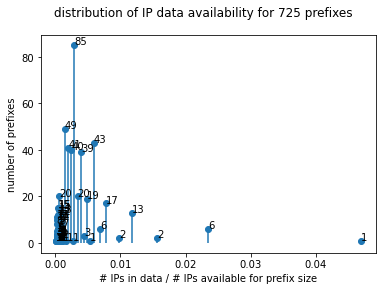

In [81]:
cnt = Counter([len(ips)/ipaddress.ip_network(pfx).num_addresses for pfx, ips in dense_prefix_to_ip.items()])
xs = list(cnt.keys())
ys = list(cnt.values())
scatter_plot(xs, ys) 
plt.suptitle(f"distribution of IP data availability for {len(dense_prefix_to_ip)} prefixes")
plt.xlabel("# IPs in data / # IPs available for prefix size")
plt.ylabel("number of prefixes")

### Save Large Query from Censys BigQuery Table into Permanent BigQuery Table

For queries that are > 1GB of data:
- create a Google Storage table 
- follow [directions](https://cloud.google.com/bigquery/docs/writing-results#writing_query_results) for setting the destination table
  - e.g. dataset: `lithe-resource-340823.ids_final`
  - e.g. table id: `ASN16509-services`
- run the query, and the results should populate the destination table

```mysql
-- This will grab 1.1-1.3 GB of data, ~9M IPs; too big to store in BigQuery temp table
SELECT
    dataset.autonomous_system.asn,
    dataset.autonomous_system.bgp_prefix,
    dataset.host_identifier.ipv4,
    dataset.services 
FROM `censys-io.research_1m.universal_internet_dataset` as dataset
WHERE DATE(dataset.snapshot_date) = '2022-02-22'
AND dataset.autonomous_system.asn = 16509
```

### Transfer Data: BiqQuery Table -> Google Cloud Storage
https://cloud.google.com/bigquery/docs/exporting-data#exporting_table_data
```mysql
  EXPORT DATA
  OPTIONS(
      -- (optional) uri wildcard (*) shards the data into multiple files
    uri='gs://asn16509-services-splits/attempt1/asn16509-services-*.json', 
    format='JSON',
    overwrite=true
  )
  AS SELECT * FROM `lithe-resource-340823.ids_final.ASN16509-services`
```

### Transfer Data: Google Cloud Storage --> Local --> Google Drive

- on local machine:
  - [install](https://cloud.google.com/storage/docs/gsutil_install) `gsutil`
  - authenticate: `gcloud auth login`
- download data:
```bash
gsutil -m cp \
  "gs://asn16509-services-splits/attempt1/asn16509-services-000000000000.json" \
  "gs://asn16509-services-splits/attempt1/asn16509-services-000000000001.json" \
  "gs://asn16509-services-splits/attempt1/asn16509-services-000000000002.json" \
  "gs://asn16509-services-splits/attempt1/asn16509-services-000000000003.json" \
  "gs://asn16509-services-splits/attempt1/asn16509-services-000000000004.json" \
  "gs://asn16509-services-splits/attempt1/asn16509-services-000000000005.json" \
  "gs://asn16509-services-splits/attempt1/asn16509-services-000000000006.json" \
  "gs://asn16509-services-splits/attempt1/asn16509-services-000000000007.json" \
  "gs://asn16509-services-splits/attempt1/asn16509-services-000000000008.json" \
  "gs://asn16509-services-splits/attempt1/asn16509-services-000000000009.json" \
  ./path/to/local/destination/directory
```
- upload to Google Drive to use free 15GB storage
